In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pygan.generative_adversarial_networks import GenerativeAdversarialNetworks
from pygan.gansvaluefunction.mini_max import MiniMax

In [3]:
from pygan.generativemodel.conditionalgenerativemodel.conditional_convolutional_model import ConditionalConvolutionalModel as Generator
from pygan.generativemodel.deconvolution_model import DeconvolutionModel

In [4]:
from pygan.discriminativemodel.cnn_model import CNNModel as Discriminator

In [5]:
from pygan.truesampler.image_true_sampler import ImageTrueSampler
from pygan.truesampler.conditionaltruesampler.conditional_image_true_sampler import ConditionalImageTrueSampler

In [6]:
from pygan.noisesampler.image_noise_sampler import ImageNoiseSampler
from pygan.noisesampler.gauss_noise_sampler import GaussNoiseSampler

In [7]:
# First convolution layer.
from pydbm.cnn.layerablecnn.convolution_layer import ConvolutionLayer as ConvolutionLayer1
# Second convolution layer.
from pydbm.cnn.layerablecnn.convolution_layer import ConvolutionLayer as ConvolutionLayer2
# Computation graph in output layer.
from pydbm.synapse.cnn_output_graph import CNNOutputGraph
# Computation graph for first convolution layer.
from pydbm.synapse.cnn_graph import CNNGraph as ConvGraph1
# Computation graph for second convolution layer.
from pydbm.synapse.cnn_graph import CNNGraph as ConvGraph2
# Logistic Function as activation function.
from pydbm.activation.logistic_function import LogisticFunction
# Tanh Function as activation function.
from pydbm.activation.tanh_function import TanhFunction
# ReLu Function as activation function.
from pydbm.activation.relu_function import ReLuFunction
# SGD optimizer.
from pydbm.optimization.optparams.sgd import SGD

In [8]:
from logging import getLogger, StreamHandler, NullHandler, DEBUG, ERROR

logger = getLogger("pygan")
handler = StreamHandler()
handler.setLevel(DEBUG)
logger.setLevel(DEBUG)
logger.addHandler(handler)

In [9]:
batch_size = 20
width = 100
height = 100
channel = 1

image_dir = "../../../../Downloads/gray/"
seq_len = None
gray_scale_flag = True
wh_size_tuple = (width, height)
norm_mode = None

In [10]:
true_sampler = ImageTrueSampler(
    batch_size=batch_size,
    image_dir=image_dir,
    seq_len=seq_len,
    gray_scale_flag=gray_scale_flag,
    wh_size_tuple=wh_size_tuple,
    norm_mode=norm_mode
)

conditional_image_true_sampler = ConditionalImageTrueSampler(true_sampler)

(20, 1, 100, 100)


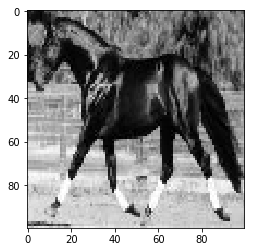

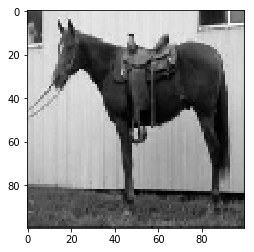

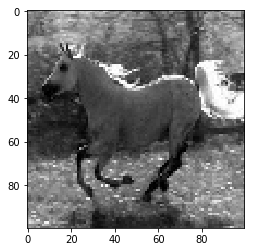

In [11]:
arr = true_sampler.draw()
print(arr.shape)
def plot(arr):
    #arr = 255 * (arr - arr.min()) / (arr.max() - arr.min())
    #arr = arr.transpose(0, 2, 3, 1).astype(np.uint8)
    for i in range(3):
        plt.imshow(arr[i, 0], cmap="gray");
        plt.show()
        plt.close()
plot(arr)

In [12]:
noise_sampler = ImageNoiseSampler(
    batch_size,
    image_dir,
    seq_len=None,
    gray_scale_flag=gray_scale_flag,
    wh_size_tuple=wh_size_tuple,
    norm_mode=norm_mode
)

In [13]:
noise_sampler.generate().shape

(20, 1, 100, 100)

In [14]:
from pydbm.cnn.convolutional_neural_network import ConvolutionalNeuralNetwork as CNN
from pydbm.cnn.layerablecnn.convolution_layer import ConvolutionLayer as ConvolutionLayer1
from pydbm.cnn.layerablecnn.convolution_layer import ConvolutionLayer as ConvolutionLayer2
from pydbm.synapse.cnn_graph import CNNGraph as ConvGraph1
from pydbm.synapse.cnn_graph import CNNGraph as ConvGraph2
from pydbm.activation.tanh_function import TanhFunction
from pydbm.activation.logistic_function import LogisticFunction
from pydbm.activation.identity_function import IdentityFunction
from pydbm.loss.mean_squared_error import MeanSquaredError
from pydbm.optimization.optparams.sgd import SGD
from pydbm.optimization.optparams.adam import Adam
from pydbm.cnn.layerablecnn.convolutionlayer.deconvolution_layer import DeconvolutionLayer
from pydbm.synapse.cnn_graph import CNNGraph as DeCNNGraph

from pydbm.verification.verificate_function_approximation import VerificateFunctionApproximation

from pygan.noisesampler.uniform_noise_sampler import UniformNoiseSampler

if gray_scale_flag is True:
    channel = 1
else:
    channel = 3
scale = 0.1

convolution_layer_list = [ConvolutionLayer1(
    ConvGraph1(
        activation_function=IdentityFunction(),
        filter_num=batch_size,
        channel=channel,
        kernel_size=3,
        scale=scale,
        stride=1,
        pad=1
    )
)]

deconvolution_layer_list = [DeconvolutionLayer(
    DeCNNGraph(
        activation_function=IdentityFunction(),
        filter_num=batch_size,
        channel=channel,
        kernel_size=3,
        scale=scale,
        stride=1,
        pad=1
    )
)]

opt_params_deconv = Adam()
deconvolution_model = DeconvolutionModel(
    deconvolution_layer_list=deconvolution_layer_list,
    opt_params=opt_params_deconv,
    learning_rate=1e-05,
    verbose_mode=False
)

opt_params=Adam()
opt_params.dropout_rate = 0.0

generator = Generator(
    batch_size=batch_size,
    learning_rate=1e-05,
    layerable_cnn_list=convolution_layer_list,
    deconvolution_model=deconvolution_model,
    conditon_noise_sampler=UniformNoiseSampler(low=-1, high=1, output_shape=(20, 1, 100, 100)),
    verbose_mode=False
)
generator.noise_sampler = noise_sampler

(20, 2, 100, 100)


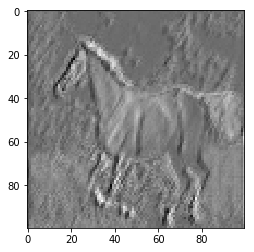

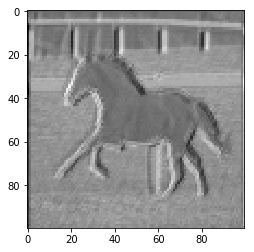

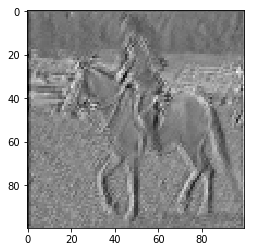

In [15]:
arr = generator.draw()
print(arr.shape)
plot(np.expand_dims(arr[:, 0], axis=1))

In [16]:
# First convolution layer.
conv2 = ConvolutionLayer2(
    # Computation graph for first convolution layer.
    ConvGraph2(
        # Logistic function as activation function.
        activation_function=TanhFunction(),
        # The number of `filter`.
        filter_num=batch_size,
        # The number of channel.
        channel=channel*2,
        # The size of kernel.
        kernel_size=3,
        # The filter scale.
        scale=0.001,
        # The nubmer of stride.
        stride=1,
        # The number of zero-padding.
        pad=1
    )
)

# Stack.
layerable_cnn_list=[
    conv2
]

opt_params = Adam()
opt_params.dropout_rate = 0.0

In [17]:
scale = 0.01
cnn_output_graph = CNNOutputGraph(
    hidden_dim=200000, 
    output_dim=1, 
    activating_function=LogisticFunction(), 
    scale=scale
)

discriminator = Discriminator(
    batch_size=batch_size,
    layerable_cnn_list=layerable_cnn_list,
    cnn_output_graph=cnn_output_graph,
    learning_rate=1e-05,
    opt_params=opt_params,
    verbose_mode=False
)

In [18]:
GAN = GenerativeAdversarialNetworks(gans_value_function=MiniMax())

In [19]:
generator, discriminator = GAN.train(
    true_sampler=conditional_image_true_sampler,
    generative_model=generator,
    discriminative_model=discriminator,
    iter_n=100,
    k_step=10
)

----------------------------------------------------------------------------------------------------
Iterations: (1/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6040943491743037
And update the `discriminator` by descending its stochastic gradient(means): -3.5636309953866587
Probability inferenced by the `discriminator` (mean): 0.4798511881786032
And update the `discriminator` by descending its stochastic gradient(means): -3.635577687036352
Probability inferenced by the `discriminator` (mean): 0.7934550253862891
And update the `discriminator` by descending its stochastic gradient(means): -5.316265717725734
Probability inferenced by the `discriminator` (mean): 0.4323743710868996
And update the `discriminator` by descending its stochastic gradient

And update the `discriminator` by descending its stochastic gradient(means): -3.4377554267535873
Probability inferenced by the `discriminator` (mean): 0.4160521180337048
And update the `discriminator` by descending its stochastic gradient(means): -2.947139897233682
Probability inferenced by the `discriminator` (mean): 0.5656412590528156
And update the `discriminator` by descending its stochastic gradient(means): -3.8365081162908723
Probability inferenced by the `discriminator` (mean): 0.5494100899421938
And update the `discriminator` by descending its stochastic gradient(means): -3.7446531185754757
Probability inferenced by the `discriminator` (mean): 0.3965264564636379
And update the `discriminator` by descending its stochastic gradient(means): -3.3149066024520373
Probability inferenced by the `discriminator` (mean): 0.48747512690233236
And update the `discriminator` by descending its stochastic gradient(means): -2.994249816829243
Probability inferenced by the `discriminator` (mean): 

Probability inferenced by the `discriminator` (mean): 0.6269292387089909
And update the `discriminator` by descending its stochastic gradient(means): -3.916485961892709
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.46924797183187145
And update the `generator` by descending its stochastic gradient(means): -5.884948369590166e-06
----------------------------------------------------------------------------------------------------
Iterations: (8/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3893511853704729
And update 

Probability inferenced by the `discriminator` (mean): 0.5505331291999627
And update the `discriminator` by descending its stochastic gradient(means): -3.323298710515636
Probability inferenced by the `discriminator` (mean): 0.5067698029394787
And update the `discriminator` by descending its stochastic gradient(means): -3.135832416423349
Probability inferenced by the `discriminator` (mean): 0.4607561451159611
And update the `discriminator` by descending its stochastic gradient(means): -3.2383329761104056
Probability inferenced by the `discriminator` (mean): 0.5186390900656994
And update the `discriminator` by descending its stochastic gradient(means): -3.614824795246166
Probability inferenced by the `discriminator` (mean): 0.6383341242761239
And update the `discriminator` by descending its stochastic gradient(means): -3.198375291949987
Probability inferenced by the `discriminator` (mean): 0.5430448903946464
And update the `discriminator` by descending its stochastic gradient(means): -3.1

And update the `discriminator` by descending its stochastic gradient(means): -3.457076670123744
Probability inferenced by the `discriminator` (mean): 0.4806690416152833
And update the `discriminator` by descending its stochastic gradient(means): -2.8890800179283267
Probability inferenced by the `discriminator` (mean): 0.46988771109205035
And update the `discriminator` by descending its stochastic gradient(means): -3.5047672760329682
Probability inferenced by the `discriminator` (mean): 0.4756936851200944
And update the `discriminator` by descending its stochastic gradient(means): -3.14136289891104
Probability inferenced by the `discriminator` (mean): 0.4197791810649356
And update the `discriminator` by descending its stochastic gradient(means): -3.410960153867909
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------


The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6025220825553137
And update the `generator` by descending its stochastic gradient(means): -7.211972212858069e-06
----------------------------------------------------------------------------------------------------
Iterations: (18/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6323909748589345
And update the `discriminator` by descending its stochastic gradient(means): -3.707212251140009
Probability inferenced by the `discriminator` (mean): 0.5271414305209478
And update the `discriminator` by descending its stochastic gradient(means): -3.514316156392579
Probability infe

And update the `discriminator` by descending its stochastic gradient(means): -3.200593905990344
Probability inferenced by the `discriminator` (mean): 0.5199373939083418
And update the `discriminator` by descending its stochastic gradient(means): -3.130531160569968
Probability inferenced by the `discriminator` (mean): 0.5355807356039185
And update the `discriminator` by descending its stochastic gradient(means): -3.024397943436205
Probability inferenced by the `discriminator` (mean): 0.6194694376786815
And update the `discriminator` by descending its stochastic gradient(means): -3.304822314740318
Probability inferenced by the `discriminator` (mean): 0.560747609974097
And update the `discriminator` by descending its stochastic gradient(means): -3.301117069862957
Probability inferenced by the `discriminator` (mean): 0.5429599835880309
And update the `discriminator` by descending its stochastic gradient(means): -3.078647290343157
Probability inferenced by the `discriminator` (mean): 0.5418

Probability inferenced by the `discriminator` (mean): 0.447868394585248
And update the `discriminator` by descending its stochastic gradient(means): -3.0565502947794667
Probability inferenced by the `discriminator` (mean): 0.5559120163126343
And update the `discriminator` by descending its stochastic gradient(means): -3.4853065504052396
Probability inferenced by the `discriminator` (mean): 0.5168872725831086
And update the `discriminator` by descending its stochastic gradient(means): -3.224883395515927
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5139303683382223
And update the `generator` by descending its stochastic gradient(means): -6.17326915056026e-06
--------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Iterations: (28/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5427672533998342
And update the `discriminator` by descending its stochastic gradient(means): -3.2413712017445726
Probability inferenced by the `discriminator` (mean): 0.5814404851709546
And update the `discriminator` by descending its stochastic gradient(means): -4.3272805553417335
Probability inferenced by the `discriminator` (mean): 0.5419917479534958
And update the `discriminator` by descending its stochastic gradient(means): -3.6650112489609272
Probability inferenced by the `discriminator` (mean): 0.5672584325356502
And update the `discriminator` by descending its stochastic gradi

And update the `discriminator` by descending its stochastic gradient(means): -3.1583169346703173
Probability inferenced by the `discriminator` (mean): 0.6398898264408179
And update the `discriminator` by descending its stochastic gradient(means): -3.7524887471325052
Probability inferenced by the `discriminator` (mean): 0.5182043314820679
And update the `discriminator` by descending its stochastic gradient(means): -3.4565854308587296
Probability inferenced by the `discriminator` (mean): 0.6040609545121113
And update the `discriminator` by descending its stochastic gradient(means): -3.6767515617621647
Probability inferenced by the `discriminator` (mean): 0.6781298439605007
And update the `discriminator` by descending its stochastic gradient(means): -3.5836245880362734
Probability inferenced by the `discriminator` (mean): 0.637115321255693
And update the `discriminator` by descending its stochastic gradient(means): -3.457897407757217
Probability inferenced by the `discriminator` (mean): 0

Probability inferenced by the `discriminator` (mean): 0.6938211623322327
And update the `discriminator` by descending its stochastic gradient(means): -4.691505605837265
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.7254217588883918
And update the `generator` by descending its stochastic gradient(means): -1.2255021293151182e-05
----------------------------------------------------------------------------------------------------
Iterations: (35/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.7036108857544403
And update

Probability inferenced by the `discriminator` (mean): 0.6162457239512447
And update the `discriminator` by descending its stochastic gradient(means): -3.687618905064105
Probability inferenced by the `discriminator` (mean): 0.5527050788165027
And update the `discriminator` by descending its stochastic gradient(means): -3.5693677684344287
Probability inferenced by the `discriminator` (mean): 0.6854367029405222
And update the `discriminator` by descending its stochastic gradient(means): -4.006211554567121
Probability inferenced by the `discriminator` (mean): 0.6364363685290917
And update the `discriminator` by descending its stochastic gradient(means): -3.3834548271376645
Probability inferenced by the `discriminator` (mean): 0.6296139591003561
And update the `discriminator` by descending its stochastic gradient(means): -3.530820678608167
Probability inferenced by the `discriminator` (mean): 0.5763416192579907
And update the `discriminator` by descending its stochastic gradient(means): -3.

And update the `discriminator` by descending its stochastic gradient(means): -3.9244942686421993
Probability inferenced by the `discriminator` (mean): 0.6696717703545918
And update the `discriminator` by descending its stochastic gradient(means): -4.154302761709312
Probability inferenced by the `discriminator` (mean): 0.5311997739467859
And update the `discriminator` by descending its stochastic gradient(means): -3.3602957438038397
Probability inferenced by the `discriminator` (mean): 0.5839885675343246
And update the `discriminator` by descending its stochastic gradient(means): -3.3617389800500286
Probability inferenced by the `discriminator` (mean): 0.616827595812513
And update the `discriminator` by descending its stochastic gradient(means): -3.715452696591258
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------


The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6555594280724184
And update the `generator` by descending its stochastic gradient(means): -8.722379243267851e-06
----------------------------------------------------------------------------------------------------
Iterations: (45/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.552428668672676
And update the `discriminator` by descending its stochastic gradient(means): -3.517851685259256
Probability inferenced by the `discriminator` (mean): 0.5081294353840926
And update the `discriminator` by descending its stochastic gradient(means): -4.084634987882287
Probability infer

And update the `discriminator` by descending its stochastic gradient(means): -3.796781200175771
Probability inferenced by the `discriminator` (mean): 0.5872956608591549
And update the `discriminator` by descending its stochastic gradient(means): -3.4835335012089708
Probability inferenced by the `discriminator` (mean): 0.5009716869795225
And update the `discriminator` by descending its stochastic gradient(means): -3.544840604073984
Probability inferenced by the `discriminator` (mean): 0.5972665318963548
And update the `discriminator` by descending its stochastic gradient(means): -4.022063806819746
Probability inferenced by the `discriminator` (mean): 0.5851556316531763
And update the `discriminator` by descending its stochastic gradient(means): -3.2219712418025255
Probability inferenced by the `discriminator` (mean): 0.3717751334722845
And update the `discriminator` by descending its stochastic gradient(means): -2.76282766633254
Probability inferenced by the `discriminator` (mean): 0.53

Probability inferenced by the `discriminator` (mean): 0.7171466220118176
And update the `discriminator` by descending its stochastic gradient(means): -4.054330794757734
Probability inferenced by the `discriminator` (mean): 0.6759428452656441
And update the `discriminator` by descending its stochastic gradient(means): -4.132564757517455
Probability inferenced by the `discriminator` (mean): 0.6127332880599368
And update the `discriminator` by descending its stochastic gradient(means): -4.04204678473556
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6538069058240273
And update the `generator` by descending its stochastic gradient(means): -1.1018815379827398e-05
--------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Iterations: (55/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.619247255422756
And update the `discriminator` by descending its stochastic gradient(means): -3.4967339823138452
Probability inferenced by the `discriminator` (mean): 0.7459087491021066
And update the `discriminator` by descending its stochastic gradient(means): -4.57679644787655
Probability inferenced by the `discriminator` (mean): 0.5803141415532526
And update the `discriminator` by descending its stochastic gradient(means): -3.7752971602199494
Probability inferenced by the `discriminator` (mean): 0.559802313412025
And update the `discriminator` by descending its stochastic gradient(

And update the `discriminator` by descending its stochastic gradient(means): -3.2051324772626613
Probability inferenced by the `discriminator` (mean): 0.569434233397288
And update the `discriminator` by descending its stochastic gradient(means): -3.6001818249479385
Probability inferenced by the `discriminator` (mean): 0.6109910972253234
And update the `discriminator` by descending its stochastic gradient(means): -3.5083224662623946
Probability inferenced by the `discriminator` (mean): 0.6537333391397444
And update the `discriminator` by descending its stochastic gradient(means): -4.007366636383029
Probability inferenced by the `discriminator` (mean): 0.5992301989795629
And update the `discriminator` by descending its stochastic gradient(means): -3.3497248803068373
Probability inferenced by the `discriminator` (mean): 0.6627283281151588
And update the `discriminator` by descending its stochastic gradient(means): -4.067273215747074
Probability inferenced by the `discriminator` (mean): 0.

Probability inferenced by the `discriminator` (mean): 0.5940438305433007
And update the `discriminator` by descending its stochastic gradient(means): -3.964705123567692
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6280962246938449
And update the `generator` by descending its stochastic gradient(means): -9.821539217040545e-06
----------------------------------------------------------------------------------------------------
Iterations: (62/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.7478051775385899
And update 

Probability inferenced by the `discriminator` (mean): 0.6354051311190407
And update the `discriminator` by descending its stochastic gradient(means): -3.734655193504738
Probability inferenced by the `discriminator` (mean): 0.44895549968742043
And update the `discriminator` by descending its stochastic gradient(means): -3.131568252616625
Probability inferenced by the `discriminator` (mean): 0.6431848659750051
And update the `discriminator` by descending its stochastic gradient(means): -3.711835635450432
Probability inferenced by the `discriminator` (mean): 0.637594884868373
And update the `discriminator` by descending its stochastic gradient(means): -3.824449537758626
Probability inferenced by the `discriminator` (mean): 0.7761682185517228
And update the `discriminator` by descending its stochastic gradient(means): -4.0744974072531255
Probability inferenced by the `discriminator` (mean): 0.6981477367102238
And update the `discriminator` by descending its stochastic gradient(means): -4.7

And update the `discriminator` by descending its stochastic gradient(means): -4.13996017139525
Probability inferenced by the `discriminator` (mean): 0.584635871707465
And update the `discriminator` by descending its stochastic gradient(means): -3.7098866533033243
Probability inferenced by the `discriminator` (mean): 0.49950887480096784
And update the `discriminator` by descending its stochastic gradient(means): -3.4204308048132233
Probability inferenced by the `discriminator` (mean): 0.643665293862673
And update the `discriminator` by descending its stochastic gradient(means): -3.7883400583503954
Probability inferenced by the `discriminator` (mean): 0.6047693367619625
And update the `discriminator` by descending its stochastic gradient(means): -4.097294699713682
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
P

----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5361453209625788
And update the `generator` by descending its stochastic gradient(means): -8.087590679018156e-07
----------------------------------------------------------------------------------------------------
Iterations: (72/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6051994320319719
And update the `discriminator` by descending its stochastic gradient(means): -4.142886523443677
Probability inferenced by the `discriminator` (mean): 0.7689008056339655
And update the `discriminator` by descending its stochastic gradient(means): -5.011615125230534
Probability inferenced by the `discrimin

Probability inferenced by the `discriminator` (mean): 0.4367758746826597
And update the `discriminator` by descending its stochastic gradient(means): -3.0358291162938076
Probability inferenced by the `discriminator` (mean): 0.5619723258053664
And update the `discriminator` by descending its stochastic gradient(means): -3.9571849703277424
Probability inferenced by the `discriminator` (mean): 0.6547903102983936
And update the `discriminator` by descending its stochastic gradient(means): -3.886930230859401
Probability inferenced by the `discriminator` (mean): 0.5689383074710773
And update the `discriminator` by descending its stochastic gradient(means): -3.579657765353757
Probability inferenced by the `discriminator` (mean): 0.4878495369066207
And update the `discriminator` by descending its stochastic gradient(means): -3.403892068335993
Probability inferenced by the `discriminator` (mean): 0.645002171198345
And update the `discriminator` by descending its stochastic gradient(means): -3.6

And update the `discriminator` by descending its stochastic gradient(means): -3.8165054790412176
Probability inferenced by the `discriminator` (mean): 0.49009413795954854
And update the `discriminator` by descending its stochastic gradient(means): -3.889741521033261
Probability inferenced by the `discriminator` (mean): 0.6118848495231808
And update the `discriminator` by descending its stochastic gradient(means): -3.5402616981355366
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6274716028882149
And update the `generator` by descending its stochastic gradient(means): -8.65006698212159e-06
----------------------------------------------------------------------------------------------------
Iterations: (79/100)
-----------------------------------------------

Iterations: (82/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6238647929034995
And update the `discriminator` by descending its stochastic gradient(means): -3.312412961554526
Probability inferenced by the `discriminator` (mean): 0.5180957587057027
And update the `discriminator` by descending its stochastic gradient(means): -3.5634609378147615
Probability inferenced by the `discriminator` (mean): 0.5055515589847861
And update the `discriminator` by descending its stochastic gradient(means): -3.6192191353255625
Probability inferenced by the `discriminator` (mean): 0.7003890967499767
And update the `discriminator` by descending its stochastic gradient(means): -4.495944252091798
Probability inferenced by the `discriminator` (mean): 0.408258866915386

Probability inferenced by the `discriminator` (mean): 0.49958131755241136
And update the `discriminator` by descending its stochastic gradient(means): -3.4095214237192772
Probability inferenced by the `discriminator` (mean): 0.44280042320014934
And update the `discriminator` by descending its stochastic gradient(means): -3.6740224387149185
Probability inferenced by the `discriminator` (mean): 0.5089321826805409
And update the `discriminator` by descending its stochastic gradient(means): -3.1078089765865142
Probability inferenced by the `discriminator` (mean): 0.4844739837621093
And update the `discriminator` by descending its stochastic gradient(means): -3.2349613350356927
Probability inferenced by the `discriminator` (mean): 0.6161451760711099
And update the `discriminator` by descending its stochastic gradient(means): -4.179153631120475
Probability inferenced by the `discriminator` (mean): 0.5179714051890472
And update the `discriminator` by descending its stochastic gradient(means):

And update the `discriminator` by descending its stochastic gradient(means): -3.454064662214492
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6517419841819506
And update the `generator` by descending its stochastic gradient(means): -4.697125169319484e-06
----------------------------------------------------------------------------------------------------
Iterations: (89/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.7452851975512693
And update the `discriminator` by descending its stochastic gradient(means): -4.3967

And update the `discriminator` by descending its stochastic gradient(means): -3.21304629794707
Probability inferenced by the `discriminator` (mean): 0.6679149183930867
And update the `discriminator` by descending its stochastic gradient(means): -4.820312430739675
Probability inferenced by the `discriminator` (mean): 0.6877340358258273
And update the `discriminator` by descending its stochastic gradient(means): -4.175305586166482
Probability inferenced by the `discriminator` (mean): 0.6485385438114303
And update the `discriminator` by descending its stochastic gradient(means): -3.738987942238938
Probability inferenced by the `discriminator` (mean): 0.49998704967890334
And update the `discriminator` by descending its stochastic gradient(means): -3.1707691484497302
Probability inferenced by the `discriminator` (mean): 0.6051766012989945
And update the `discriminator` by descending its stochastic gradient(means): -3.9354518984628606
Probability inferenced by the `discriminator` (mean): 0.6

Probability inferenced by the `discriminator` (mean): 0.648720169679389
And update the `discriminator` by descending its stochastic gradient(means): -4.168999277611951
Probability inferenced by the `discriminator` (mean): 0.5332317431065302
And update the `discriminator` by descending its stochastic gradient(means): -3.3209898829025932
Probability inferenced by the `discriminator` (mean): 0.38524651954900535
And update the `discriminator` by descending its stochastic gradient(means): -3.360761387230121
Probability inferenced by the `discriminator` (mean): 0.42487350807748514
And update the `discriminator` by descending its stochastic gradient(means): -3.164966469881866
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6532679763817126
And update the `generat

Probability inferenced by the `discriminator` (mean): 0.6091872009792996
And update the `generator` by descending its stochastic gradient(means): -9.81892705991327e-07
----------------------------------------------------------------------------------------------------
Iterations: (99/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6678120245610184
And update the `discriminator` by descending its stochastic gradient(means): -3.594283109585308
Probability inferenced by the `discriminator` (mean): 0.6494119970354726
And update the `discriminator` by descending its stochastic gradient(means): -3.7193319576063986
Probability inferenced by the `discriminator` (mean): 0.546270563133755
And update the `discriminator` by descending its stochastic gradient(

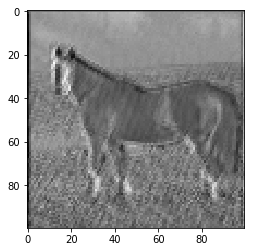

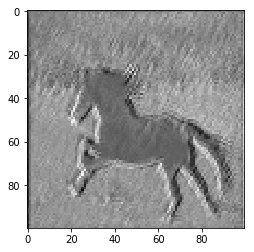

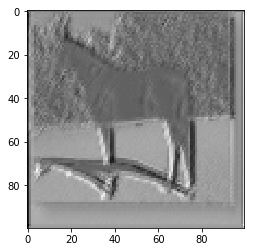

In [20]:
arr2 = generator.draw()
plot(np.expand_dims(arr2[:, 0], axis=1))

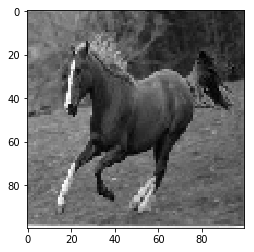

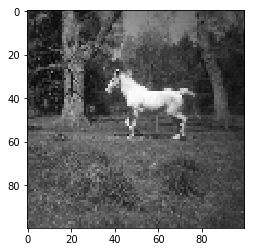

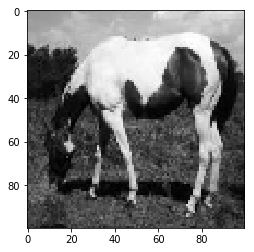

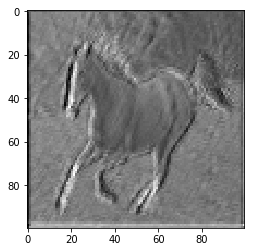

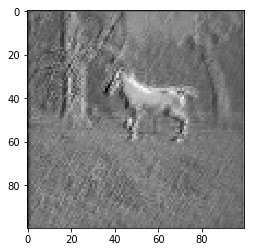

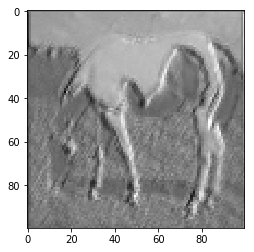

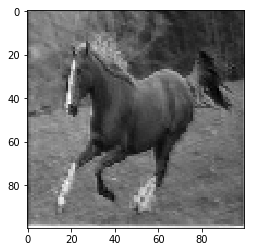

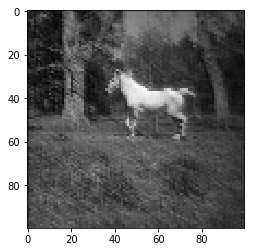

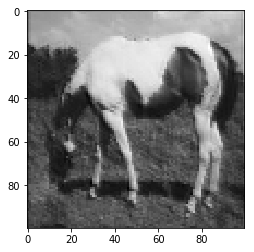

In [21]:
arr2 = generator.draw()
plot(np.expand_dims(arr2[:, 1], axis=1))
plot(np.expand_dims(arr2[:, 0], axis=1))
plot(np.expand_dims(np.sum(arr2, axis=1), axis=1))

In [22]:
d_logs_list, g_logs_list = GAN.extract_logs_tuple()

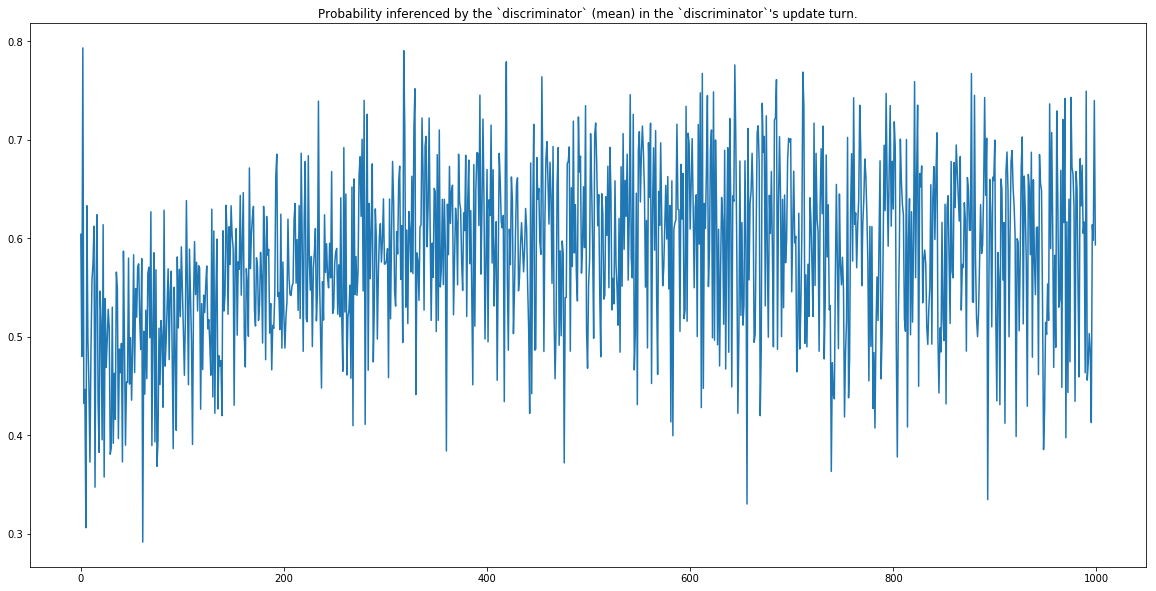

In [23]:
plt.figure(figsize=(20, 10))
plt.title("Probability inferenced by the `discriminator` (mean) in the `discriminator`'s update turn.")
plt.plot(d_logs_list)
plt.show()
plt.close()

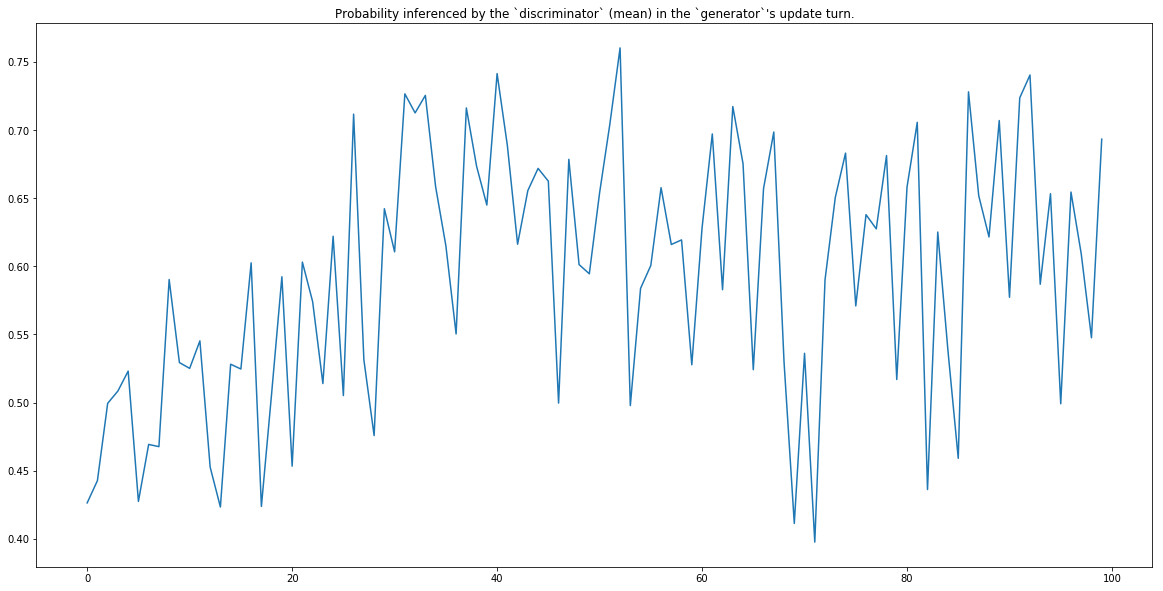

In [24]:
plt.figure(figsize=(20, 10))
plt.title("Probability inferenced by the `discriminator` (mean) in the `generator`'s update turn.")
plt.plot(g_logs_list)
plt.show()
plt.close()

In [25]:
generator, discriminator = GAN.train(
    true_sampler=conditional_image_true_sampler,
    generative_model=generator,
    discriminative_model=discriminator,
    iter_n=100,
    k_step=10
)

----------------------------------------------------------------------------------------------------
Iterations: (1/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5849182484673366
And update the `discriminator` by descending its stochastic gradient(means): -3.80933222835271
Probability inferenced by the `discriminator` (mean): 0.5908259882469604
And update the `discriminator` by descending its stochastic gradient(means): -3.820747872508113
Probability inferenced by the `discriminator` (mean): 0.678822396135196
And update the `discriminator` by descending its stochastic gradient(means): -4.1527441531806515
Probability inferenced by the `discriminator` (mean): 0.5469417512612381
And update the `discriminator` by descending its stochastic gradient(m

And update the `discriminator` by descending its stochastic gradient(means): -4.2753973954383495
Probability inferenced by the `discriminator` (mean): 0.5648156191344398
And update the `discriminator` by descending its stochastic gradient(means): -3.6143358219431256
Probability inferenced by the `discriminator` (mean): 0.625786010711338
And update the `discriminator` by descending its stochastic gradient(means): -3.5981673663370066
Probability inferenced by the `discriminator` (mean): 0.48920478179752963
And update the `discriminator` by descending its stochastic gradient(means): -3.151057444109279
Probability inferenced by the `discriminator` (mean): 0.4717073068684362
And update the `discriminator` by descending its stochastic gradient(means): -3.316455128945124
Probability inferenced by the `discriminator` (mean): 0.3753095507430871
And update the `discriminator` by descending its stochastic gradient(means): -3.038577054321291
Probability inferenced by the `discriminator` (mean): 0.

Probability inferenced by the `discriminator` (mean): 0.5632729956400053
And update the `discriminator` by descending its stochastic gradient(means): -3.6968006489616547
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4070730735666621
And update the `generator` by descending its stochastic gradient(means): -2.0739778178853445e-06
----------------------------------------------------------------------------------------------------
Iterations: (8/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6737535832273845
And update

Probability inferenced by the `discriminator` (mean): 0.6170249928555147
And update the `discriminator` by descending its stochastic gradient(means): -4.010313817585861
Probability inferenced by the `discriminator` (mean): 0.7181869437454883
And update the `discriminator` by descending its stochastic gradient(means): -4.327261913080042
Probability inferenced by the `discriminator` (mean): 0.5422435488702938
And update the `discriminator` by descending its stochastic gradient(means): -3.1126196250474276
Probability inferenced by the `discriminator` (mean): 0.5523577005117083
And update the `discriminator` by descending its stochastic gradient(means): -3.9309885220099567
Probability inferenced by the `discriminator` (mean): 0.6178430073513154
And update the `discriminator` by descending its stochastic gradient(means): -3.673493420140658
Probability inferenced by the `discriminator` (mean): 0.6834910567812496
And update the `discriminator` by descending its stochastic gradient(means): -3.

And update the `discriminator` by descending its stochastic gradient(means): -3.1441771117410706
Probability inferenced by the `discriminator` (mean): 0.6549550354057467
And update the `discriminator` by descending its stochastic gradient(means): -4.207036093846606
Probability inferenced by the `discriminator` (mean): 0.5343354351226708
And update the `discriminator` by descending its stochastic gradient(means): -3.458532844653503
Probability inferenced by the `discriminator` (mean): 0.5836083662298843
And update the `discriminator` by descending its stochastic gradient(means): -3.7510089965926126
Probability inferenced by the `discriminator` (mean): 0.615211312937493
And update the `discriminator` by descending its stochastic gradient(means): -3.7905175617664852
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------


The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.516325937841057
And update the `generator` by descending its stochastic gradient(means): 1.6926161061859283e-06
----------------------------------------------------------------------------------------------------
Iterations: (18/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.599293893177024
And update the `discriminator` by descending its stochastic gradient(means): -3.883032184663725
Probability inferenced by the `discriminator` (mean): 0.59721029895319
And update the `discriminator` by descending its stochastic gradient(means): -3.793183329935269
Probability inferenc

And update the `discriminator` by descending its stochastic gradient(means): -3.923759590738122
Probability inferenced by the `discriminator` (mean): 0.6020315555819807
And update the `discriminator` by descending its stochastic gradient(means): -3.814146642587526
Probability inferenced by the `discriminator` (mean): 0.47912215755195897
And update the `discriminator` by descending its stochastic gradient(means): -3.432404014246108
Probability inferenced by the `discriminator` (mean): 0.5699679015125678
And update the `discriminator` by descending its stochastic gradient(means): -3.3780887161695907
Probability inferenced by the `discriminator` (mean): 0.5201068606532673
And update the `discriminator` by descending its stochastic gradient(means): -3.6171349581684233
Probability inferenced by the `discriminator` (mean): 0.6015006292744556
And update the `discriminator` by descending its stochastic gradient(means): -3.948977838936174
Probability inferenced by the `discriminator` (mean): 0.

Probability inferenced by the `discriminator` (mean): 0.5453947110018886
And update the `discriminator` by descending its stochastic gradient(means): -3.374390430395887
Probability inferenced by the `discriminator` (mean): 0.44153328372260897
And update the `discriminator` by descending its stochastic gradient(means): -3.4225913142127595
Probability inferenced by the `discriminator` (mean): 0.44232106781184627
And update the `discriminator` by descending its stochastic gradient(means): -3.5071730530427514
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5438277457991042
And update the `generator` by descending its stochastic gradient(means): -5.781688260497256e-06
----------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Iterations: (28/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5888378212910493
And update the `discriminator` by descending its stochastic gradient(means): -3.9714798069170087
Probability inferenced by the `discriminator` (mean): 0.6488912046174111
And update the `discriminator` by descending its stochastic gradient(means): -4.265674809013847
Probability inferenced by the `discriminator` (mean): 0.5857492777258723
And update the `discriminator` by descending its stochastic gradient(means): -3.5802701283973994
Probability inferenced by the `discriminator` (mean): 0.5400032937680873
And update the `discriminator` by descending its stochastic gradie

And update the `discriminator` by descending its stochastic gradient(means): -3.7241278876725454
Probability inferenced by the `discriminator` (mean): 0.602692941798906
And update the `discriminator` by descending its stochastic gradient(means): -3.5584382144492204
Probability inferenced by the `discriminator` (mean): 0.5794693115214239
And update the `discriminator` by descending its stochastic gradient(means): -3.7154364481329125
Probability inferenced by the `discriminator` (mean): 0.594089367850254
And update the `discriminator` by descending its stochastic gradient(means): -3.439313415255151
Probability inferenced by the `discriminator` (mean): 0.44836482808186356
And update the `discriminator` by descending its stochastic gradient(means): -2.9854851420618624
Probability inferenced by the `discriminator` (mean): 0.5560078769745875
And update the `discriminator` by descending its stochastic gradient(means): -3.4911619650814236
Probability inferenced by the `discriminator` (mean): 0

Probability inferenced by the `discriminator` (mean): 0.659943077503759
And update the `discriminator` by descending its stochastic gradient(means): -3.745895568077097
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6152640426265797
And update the `generator` by descending its stochastic gradient(means): -1.0656455558456554e-05
----------------------------------------------------------------------------------------------------
Iterations: (35/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6802010878514111
And update 

Probability inferenced by the `discriminator` (mean): 0.6552956775457621
And update the `discriminator` by descending its stochastic gradient(means): -3.980601662380767
Probability inferenced by the `discriminator` (mean): 0.6375432537893793
And update the `discriminator` by descending its stochastic gradient(means): -3.526434874238363
Probability inferenced by the `discriminator` (mean): 0.30601883280134384
And update the `discriminator` by descending its stochastic gradient(means): -2.625164691900682
Probability inferenced by the `discriminator` (mean): 0.5782690725045507
And update the `discriminator` by descending its stochastic gradient(means): -3.8659321799022344
Probability inferenced by the `discriminator` (mean): 0.6380054691296114
And update the `discriminator` by descending its stochastic gradient(means): -3.790727484502258
Probability inferenced by the `discriminator` (mean): 0.5118877317211602
And update the `discriminator` by descending its stochastic gradient(means): -3.

And update the `discriminator` by descending its stochastic gradient(means): -4.289767349847596
Probability inferenced by the `discriminator` (mean): 0.6363828825373379
And update the `discriminator` by descending its stochastic gradient(means): -3.665227996704022
Probability inferenced by the `discriminator` (mean): 0.5494274894526744
And update the `discriminator` by descending its stochastic gradient(means): -3.9351689101822167
Probability inferenced by the `discriminator` (mean): 0.5274032598745759
And update the `discriminator` by descending its stochastic gradient(means): -3.1206687147930747
Probability inferenced by the `discriminator` (mean): 0.7115514825676549
And update the `discriminator` by descending its stochastic gradient(means): -4.308173132426909
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5753656490129943
And update the `generator` by descending its stochastic gradient(means): -5.1453952029336294e-06
----------------------------------------------------------------------------------------------------
Iterations: (45/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5843349308979398
And update the `discriminator` by descending its stochastic gradient(means): -3.4796326523989123
Probability inferenced by the `discriminator` (mean): 0.6009119779828445
And update the `discriminator` by descending its stochastic gradient(means): -3.3857505595565627
Probability inferenced by the `discri

And update the `discriminator` by descending its stochastic gradient(means): -3.2675296625082977
Probability inferenced by the `discriminator` (mean): 0.6037293005165478
And update the `discriminator` by descending its stochastic gradient(means): -3.779358874636121
Probability inferenced by the `discriminator` (mean): 0.6479364301113612
And update the `discriminator` by descending its stochastic gradient(means): -4.142513763785135
Probability inferenced by the `discriminator` (mean): 0.5153324595046096
And update the `discriminator` by descending its stochastic gradient(means): -3.424746482374354
Probability inferenced by the `discriminator` (mean): 0.5760511432680752
And update the `discriminator` by descending its stochastic gradient(means): -3.5486338864654394
Probability inferenced by the `discriminator` (mean): 0.5892107642640487
And update the `discriminator` by descending its stochastic gradient(means): -3.839267055514764
Probability inferenced by the `discriminator` (mean): 0.6

Probability inferenced by the `discriminator` (mean): 0.5204671834898476
And update the `discriminator` by descending its stochastic gradient(means): -3.5284590477125235
Probability inferenced by the `discriminator` (mean): 0.47499198724068104
And update the `discriminator` by descending its stochastic gradient(means): -3.2075569543872633
Probability inferenced by the `discriminator` (mean): 0.7344469885517463
And update the `discriminator` by descending its stochastic gradient(means): -4.011268639836263
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5965998218942926
And update the `generator` by descending its stochastic gradient(means): -1.9675132092649597e-06
----------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Iterations: (55/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4893348808795511
And update the `discriminator` by descending its stochastic gradient(means): -3.3455983482025973
Probability inferenced by the `discriminator` (mean): 0.4528959642979601
And update the `discriminator` by descending its stochastic gradient(means): -3.0689539451159495
Probability inferenced by the `discriminator` (mean): 0.5481631264759228
And update the `discriminator` by descending its stochastic gradient(means): -4.038895005028647
Probability inferenced by the `discriminator` (mean): 0.48655316825642264
And update the `discriminator` by descending its stochastic gradi

Probability inferenced by the `discriminator` (mean): 0.574953683338037
And update the `discriminator` by descending its stochastic gradient(means): -3.5709263763453007
Probability inferenced by the `discriminator` (mean): 0.5100019613512594
And update the `discriminator` by descending its stochastic gradient(means): -3.293314960464289
Probability inferenced by the `discriminator` (mean): 0.5523293442680933
And update the `discriminator` by descending its stochastic gradient(means): -3.8147207246981423
Probability inferenced by the `discriminator` (mean): 0.6919337678181396
And update the `discriminator` by descending its stochastic gradient(means): -4.1543978363298715
Probability inferenced by the `discriminator` (mean): 0.6060556082639584
And update the `discriminator` by descending its stochastic gradient(means): -3.823000826678551
Probability inferenced by the `discriminator` (mean): 0.5738086880549955
And update the `discriminator` by descending its stochastic gradient(means): -3.

And update the `discriminator` by descending its stochastic gradient(means): -4.252731004428865
Probability inferenced by the `discriminator` (mean): 0.5734407250952189
And update the `discriminator` by descending its stochastic gradient(means): -3.5489912384781412
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5198433768939921
And update the `generator` by descending its stochastic gradient(means): -1.1335578343233437e-05
----------------------------------------------------------------------------------------------------
Iterations: (62/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
---------------------------------------------------------------------------------------

The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6670554560317723
And update the `discriminator` by descending its stochastic gradient(means): -4.008661102671324
Probability inferenced by the `discriminator` (mean): 0.5079391777224823
And update the `discriminator` by descending its stochastic gradient(means): -3.5555557813958627
Probability inferenced by the `discriminator` (mean): 0.4395500369721302
And update the `discriminator` by descending its stochastic gradient(means): -3.2999084031318375
Probability inferenced by the `discriminator` (mean): 0.5536698972757458
And update the `discriminator` by descending its stochastic gradient(means): -3.978409963171739
Probability inferenced by the `discriminator` (mean): 0.45834771545138536
And update the `discriminator` by descending its stochastic gradient(means): -2.9765960798248203
Probability inferenced

And update the `discriminator` by descending its stochastic gradient(means): -3.8334624772274255
Probability inferenced by the `discriminator` (mean): 0.6589054212064351
And update the `discriminator` by descending its stochastic gradient(means): -3.558518455949168
Probability inferenced by the `discriminator` (mean): 0.435282601907537
And update the `discriminator` by descending its stochastic gradient(means): -3.8688648737339912
Probability inferenced by the `discriminator` (mean): 0.6783214805718089
And update the `discriminator` by descending its stochastic gradient(means): -4.083179177727796
Probability inferenced by the `discriminator` (mean): 0.45403219491528174
And update the `discriminator` by descending its stochastic gradient(means): -2.838313625441864
Probability inferenced by the `discriminator` (mean): 0.590291650504888
And update the `discriminator` by descending its stochastic gradient(means): -3.8633334223244917
---------------------------------------------------------

----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.47831401415401037
And update the `generator` by descending its stochastic gradient(means): -1.05077698363245e-05
----------------------------------------------------------------------------------------------------
Iterations: (72/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5087602313331214
And update the `discriminator` by descending its stochastic gradient(means): -3.3841000331431523
Probability inferenced by the `discriminator` (mean): 0.6402202372230053
And update

Probability inferenced by the `discriminator` (mean): 0.6229937185721627
And update the `discriminator` by descending its stochastic gradient(means): -3.9478330792608807
Probability inferenced by the `discriminator` (mean): 0.515377224997564
And update the `discriminator` by descending its stochastic gradient(means): -3.4302063377209935
Probability inferenced by the `discriminator` (mean): 0.44372477760959034
And update the `discriminator` by descending its stochastic gradient(means): -3.6938343717150985
Probability inferenced by the `discriminator` (mean): 0.44219337282107485
And update the `discriminator` by descending its stochastic gradient(means): -3.1384705559968706
Probability inferenced by the `discriminator` (mean): 0.5702300591817892
And update the `discriminator` by descending its stochastic gradient(means): -3.494658301953173
Probability inferenced by the `discriminator` (mean): 0.4958835502947572
And update the `discriminator` by descending its stochastic gradient(means): 

And update the `discriminator` by descending its stochastic gradient(means): -3.0746054424225493
Probability inferenced by the `discriminator` (mean): 0.5446785196357536
And update the `discriminator` by descending its stochastic gradient(means): -3.3735942001328665
Probability inferenced by the `discriminator` (mean): 0.4200323137381676
And update the `discriminator` by descending its stochastic gradient(means): -3.395463448142325
Probability inferenced by the `discriminator` (mean): 0.4807612506414034
And update the `discriminator` by descending its stochastic gradient(means): -3.382308052352111
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5471229476255157
And update the `generator` by descending its stochastic gradient(means): -5.356635107316247e-06


And update the `generator` by descending its stochastic gradient(means): -1.8798300450464535e-05
----------------------------------------------------------------------------------------------------
Iterations: (82/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5896637344195425
And update the `discriminator` by descending its stochastic gradient(means): -4.188644211039366
Probability inferenced by the `discriminator` (mean): 0.6039027558299355
And update the `discriminator` by descending its stochastic gradient(means): -3.7917036288065638
Probability inferenced by the `discriminator` (mean): 0.6342823979829586
And update the `discriminator` by descending its stochastic gradient(means): -3.484026708191023
Probability inferenced by the `discriminato

Probability inferenced by the `discriminator` (mean): 0.6035172397399423
And update the `discriminator` by descending its stochastic gradient(means): -3.754716705283154
Probability inferenced by the `discriminator` (mean): 0.5346983274852144
And update the `discriminator` by descending its stochastic gradient(means): -3.401862951333098
Probability inferenced by the `discriminator` (mean): 0.5168353811954679
And update the `discriminator` by descending its stochastic gradient(means): -3.2172361351051157
Probability inferenced by the `discriminator` (mean): 0.5073440869421615
And update the `discriminator` by descending its stochastic gradient(means): -3.6330971133851806
Probability inferenced by the `discriminator` (mean): 0.4441687055872808
And update the `discriminator` by descending its stochastic gradient(means): -3.6375914818768775
Probability inferenced by the `discriminator` (mean): 0.6057088343055329
And update the `discriminator` by descending its stochastic gradient(means): -3

And update the `discriminator` by descending its stochastic gradient(means): -3.77175390499056
Probability inferenced by the `discriminator` (mean): 0.5388307452978065
And update the `discriminator` by descending its stochastic gradient(means): -3.5638239086464147
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5574133673139137
And update the `generator` by descending its stochastic gradient(means): -1.0432218786043337e-05
----------------------------------------------------------------------------------------------------
Iterations: (89/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------

The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.44399765659972534
And update the `discriminator` by descending its stochastic gradient(means): -3.220698484513634
Probability inferenced by the `discriminator` (mean): 0.5520139275232768
And update the `discriminator` by descending its stochastic gradient(means): -3.3334033257732636
Probability inferenced by the `discriminator` (mean): 0.49266437792423395
And update the `discriminator` by descending its stochastic gradient(means): -3.0704959143967123
Probability inferenced by the `discriminator` (mean): 0.5866528832920442
And update the `discriminator` by descending its stochastic gradient(means): -3.7879509373173823
Probability inferenced by the `discriminator` (mean): 0.41387821237860944
And update the `discriminator` by descending its stochastic gradient(means): -3.603203781980907
Probability inferenc

And update the `discriminator` by descending its stochastic gradient(means): -3.5935823037499626
Probability inferenced by the `discriminator` (mean): 0.6522462783895706
And update the `discriminator` by descending its stochastic gradient(means): -3.9397055146528905
Probability inferenced by the `discriminator` (mean): 0.6073123399158036
And update the `discriminator` by descending its stochastic gradient(means): -3.5809556336904484
Probability inferenced by the `discriminator` (mean): 0.524006657246101
And update the `discriminator` by descending its stochastic gradient(means): -3.3294711518357674
Probability inferenced by the `discriminator` (mean): 0.5727396808993848
And update the `discriminator` by descending its stochastic gradient(means): -3.5641163888593845
Probability inferenced by the `discriminator` (mean): 0.5942281825829282
And update the `discriminator` by descending its stochastic gradient(means): -3.5784432989594848
------------------------------------------------------

----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5914555794868142
And update the `generator` by descending its stochastic gradient(means): 3.6016706668145347e-06
----------------------------------------------------------------------------------------------------
Iterations: (99/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5115019555317248
And update the `discriminator` by descending its stochastic gradient(means): -3.2522868737950157
Probability inferenced by the `discriminator` (mean): 0.354655576901739
And update 

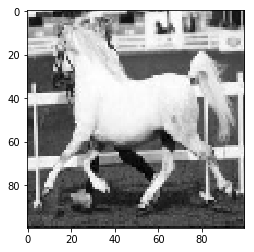

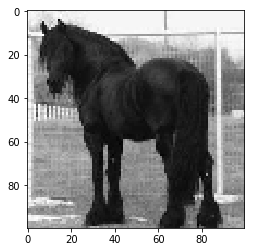

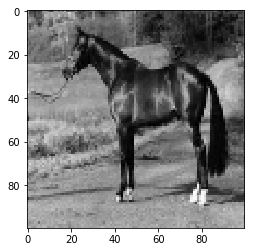

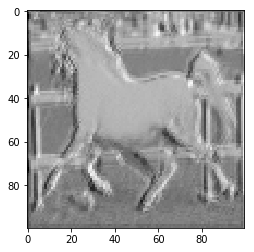

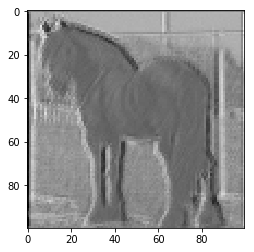

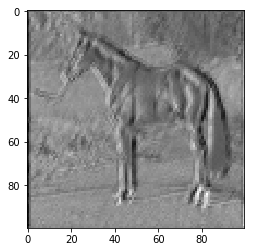

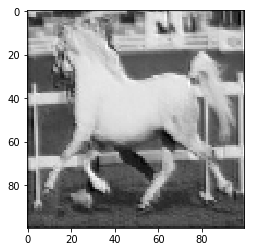

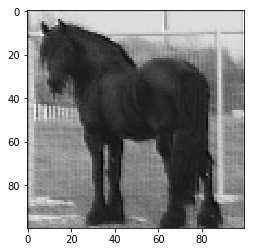

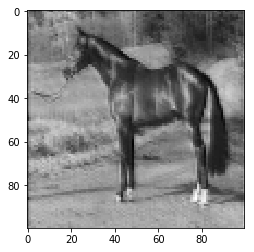

In [26]:
arr2 = generator.draw()
plot(np.expand_dims(arr2[:, 1], axis=1))
plot(np.expand_dims(arr2[:, 0], axis=1))
plot(np.expand_dims(np.sum(arr2, axis=1), axis=1))

In [27]:
generator, discriminator = GAN.train(
    true_sampler=conditional_image_true_sampler,
    generative_model=generator,
    discriminative_model=discriminator,
    iter_n=100,
    k_step=10
)

----------------------------------------------------------------------------------------------------
Iterations: (1/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5559356179475754
And update the `discriminator` by descending its stochastic gradient(means): -3.502169438593738
Probability inferenced by the `discriminator` (mean): 0.6043903187523867
And update the `discriminator` by descending its stochastic gradient(means): -3.579590971015924
Probability inferenced by the `discriminator` (mean): 0.5888172038569991
And update the `discriminator` by descending its stochastic gradient(means): -3.8748465374850882
Probability inferenced by the `discriminator` (mean): 0.5121158872686944
And update the `discriminator` by descending its stochastic gradient

And update the `discriminator` by descending its stochastic gradient(means): -3.6807566052381704
Probability inferenced by the `discriminator` (mean): 0.45795954098293434
And update the `discriminator` by descending its stochastic gradient(means): -2.9994683665012736
Probability inferenced by the `discriminator` (mean): 0.4148885950036515
And update the `discriminator` by descending its stochastic gradient(means): -3.2523436506151553
Probability inferenced by the `discriminator` (mean): 0.4505030979303527
And update the `discriminator` by descending its stochastic gradient(means): -3.292323098594264
Probability inferenced by the `discriminator` (mean): 0.6103806212415079
And update the `discriminator` by descending its stochastic gradient(means): -3.4648296272984083
Probability inferenced by the `discriminator` (mean): 0.5628196671946981
And update the `discriminator` by descending its stochastic gradient(means): -3.34643644166079
Probability inferenced by the `discriminator` (mean): 0

Probability inferenced by the `discriminator` (mean): 0.4536728381553502
And update the `discriminator` by descending its stochastic gradient(means): -3.197033173073681
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6583716359551587
And update the `generator` by descending its stochastic gradient(means): -9.167933003366066e-06
----------------------------------------------------------------------------------------------------
Iterations: (8/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.45452849072547774
And update 

Probability inferenced by the `discriminator` (mean): 0.5404070620749797
And update the `discriminator` by descending its stochastic gradient(means): -3.7651204023630647
Probability inferenced by the `discriminator` (mean): 0.29694074844682
And update the `discriminator` by descending its stochastic gradient(means): -3.633148126196744
Probability inferenced by the `discriminator` (mean): 0.6155677451485805
And update the `discriminator` by descending its stochastic gradient(means): -3.49168608055849
Probability inferenced by the `discriminator` (mean): 0.41784458837442323
And update the `discriminator` by descending its stochastic gradient(means): -3.14294291844572
Probability inferenced by the `discriminator` (mean): 0.4348780094235261
And update the `discriminator` by descending its stochastic gradient(means): -3.4694164023064062
Probability inferenced by the `discriminator` (mean): 0.42741535659678637
And update the `discriminator` by descending its stochastic gradient(means): -3.09

And update the `discriminator` by descending its stochastic gradient(means): -3.6447481528409567
Probability inferenced by the `discriminator` (mean): 0.6264095465910885
And update the `discriminator` by descending its stochastic gradient(means): -3.568153797316748
Probability inferenced by the `discriminator` (mean): 0.5602944774201315
And update the `discriminator` by descending its stochastic gradient(means): -3.491305172530906
Probability inferenced by the `discriminator` (mean): 0.6619501544478019
And update the `discriminator` by descending its stochastic gradient(means): -3.659166964436731
Probability inferenced by the `discriminator` (mean): 0.6059480215274448
And update the `discriminator` by descending its stochastic gradient(means): -3.9699187396890734
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------


The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5109107333107937
And update the `generator` by descending its stochastic gradient(means): -2.1624466751816118e-06
----------------------------------------------------------------------------------------------------
Iterations: (18/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5528198989190789
And update the `discriminator` by descending its stochastic gradient(means): -3.3116632405250557
Probability inferenced by the `discriminator` (mean): 0.6572031487852701
And update the `discriminator` by descending its stochastic gradient(means): -4.149334307115349
Probability in

And update the `discriminator` by descending its stochastic gradient(means): -3.089076557971041
Probability inferenced by the `discriminator` (mean): 0.44114458019238867
And update the `discriminator` by descending its stochastic gradient(means): -3.2430357996103645
Probability inferenced by the `discriminator` (mean): 0.4776695221311159
And update the `discriminator` by descending its stochastic gradient(means): -3.550432126075864
Probability inferenced by the `discriminator` (mean): 0.4437520534357514
And update the `discriminator` by descending its stochastic gradient(means): -3.1982138527046904
Probability inferenced by the `discriminator` (mean): 0.5044281856506319
And update the `discriminator` by descending its stochastic gradient(means): -3.355030340992492
Probability inferenced by the `discriminator` (mean): 0.403417820307976
And update the `discriminator` by descending its stochastic gradient(means): -3.620073023929507
Probability inferenced by the `discriminator` (mean): 0.5

Probability inferenced by the `discriminator` (mean): 0.5493052164807021
And update the `discriminator` by descending its stochastic gradient(means): -3.527694098362017
Probability inferenced by the `discriminator` (mean): 0.3295614789908775
And update the `discriminator` by descending its stochastic gradient(means): -2.8045221915229916
Probability inferenced by the `discriminator` (mean): 0.6006472924133623
And update the `discriminator` by descending its stochastic gradient(means): -4.0083747696030585
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5166314147385849
And update the `generator` by descending its stochastic gradient(means): 3.84378885216977e-06
--------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Iterations: (28/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.47273756391302113
And update the `discriminator` by descending its stochastic gradient(means): -3.1763349033477826
Probability inferenced by the `discriminator` (mean): 0.5789052528009455
And update the `discriminator` by descending its stochastic gradient(means): -3.6606070048770265
Probability inferenced by the `discriminator` (mean): 0.5417269814421496
And update the `discriminator` by descending its stochastic gradient(means): -3.220645751388266
Probability inferenced by the `discriminator` (mean): 0.4717120422868065
And update the `discriminator` by descending its stochastic gradi

And update the `discriminator` by descending its stochastic gradient(means): -2.6815620083568703
Probability inferenced by the `discriminator` (mean): 0.5284631801949292
And update the `discriminator` by descending its stochastic gradient(means): -3.137479908061379
Probability inferenced by the `discriminator` (mean): 0.4423682628399875
And update the `discriminator` by descending its stochastic gradient(means): -3.340562420879118
Probability inferenced by the `discriminator` (mean): 0.5240552058138988
And update the `discriminator` by descending its stochastic gradient(means): -3.3976850472852993
Probability inferenced by the `discriminator` (mean): 0.38670836218587795
And update the `discriminator` by descending its stochastic gradient(means): -2.7398725287074894
Probability inferenced by the `discriminator` (mean): 0.5175217875994765
And update the `discriminator` by descending its stochastic gradient(means): -3.300207514826026
Probability inferenced by the `discriminator` (mean): 0

Probability inferenced by the `discriminator` (mean): 0.47449083104003076
And update the `discriminator` by descending its stochastic gradient(means): -3.4869111637643884
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5539958696831981
And update the `generator` by descending its stochastic gradient(means): 4.6516853401224255e-06
----------------------------------------------------------------------------------------------------
Iterations: (35/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5556391338538433
And updat

Probability inferenced by the `discriminator` (mean): 0.32403606076005737
And update the `discriminator` by descending its stochastic gradient(means): -3.5993531853999463
Probability inferenced by the `discriminator` (mean): 0.5456587891238884
And update the `discriminator` by descending its stochastic gradient(means): -3.7488950878007046
Probability inferenced by the `discriminator` (mean): 0.5283171873163848
And update the `discriminator` by descending its stochastic gradient(means): -3.1567059342642665
Probability inferenced by the `discriminator` (mean): 0.5152453176410939
And update the `discriminator` by descending its stochastic gradient(means): -3.1693230049755017
Probability inferenced by the `discriminator` (mean): 0.5206948138054581
And update the `discriminator` by descending its stochastic gradient(means): -3.1253433750863673
Probability inferenced by the `discriminator` (mean): 0.3922784865454385
And update the `discriminator` by descending its stochastic gradient(means):

And update the `discriminator` by descending its stochastic gradient(means): -3.808933572046441
Probability inferenced by the `discriminator` (mean): 0.5084628075833105
And update the `discriminator` by descending its stochastic gradient(means): -3.34799787205471
Probability inferenced by the `discriminator` (mean): 0.4088978802850883
And update the `discriminator` by descending its stochastic gradient(means): -3.2977926203841124
Probability inferenced by the `discriminator` (mean): 0.37756090384848856
And update the `discriminator` by descending its stochastic gradient(means): -3.318057416661671
Probability inferenced by the `discriminator` (mean): 0.3669445158929935
And update the `discriminator` by descending its stochastic gradient(means): -3.441407831064436
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
P

The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5660549759428611
And update the `generator` by descending its stochastic gradient(means): -2.6641368177856906e-05
----------------------------------------------------------------------------------------------------
Iterations: (45/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.46797947534908974
And update the `discriminator` by descending its stochastic gradient(means): -3.2921386444950236
Probability inferenced by the `discriminator` (mean): 0.6769833613027865
And update the `discriminator` by descending its stochastic gradient(means): -4.12317809536072
Probability in

And update the `discriminator` by descending its stochastic gradient(means): -3.186697023485019
Probability inferenced by the `discriminator` (mean): 0.40002238637894505
And update the `discriminator` by descending its stochastic gradient(means): -3.000328457224899
Probability inferenced by the `discriminator` (mean): 0.5227860997155342
And update the `discriminator` by descending its stochastic gradient(means): -4.230156706939953
Probability inferenced by the `discriminator` (mean): 0.5132250103086167
And update the `discriminator` by descending its stochastic gradient(means): -3.3896746360528347
Probability inferenced by the `discriminator` (mean): 0.6411647291452048
And update the `discriminator` by descending its stochastic gradient(means): -3.8325283873704583
Probability inferenced by the `discriminator` (mean): 0.5399930235886881
And update the `discriminator` by descending its stochastic gradient(means): -3.0213115479844133
Probability inferenced by the `discriminator` (mean): 0

Probability inferenced by the `discriminator` (mean): 0.5647857605318962
And update the `discriminator` by descending its stochastic gradient(means): -3.63386298128374
Probability inferenced by the `discriminator` (mean): 0.5015001413483025
And update the `discriminator` by descending its stochastic gradient(means): -3.9380767764177187
Probability inferenced by the `discriminator` (mean): 0.5564006501609314
And update the `discriminator` by descending its stochastic gradient(means): -4.055060785125232
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5918112906907153
And update the `generator` by descending its stochastic gradient(means): -1.8345310320968867e-05
-------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Iterations: (55/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5603566647411724
And update the `discriminator` by descending its stochastic gradient(means): -3.713430667842996
Probability inferenced by the `discriminator` (mean): 0.5130541644514475
And update the `discriminator` by descending its stochastic gradient(means): -3.555599231567675
Probability inferenced by the `discriminator` (mean): 0.4581952533140897
And update the `discriminator` by descending its stochastic gradient(means): -3.352623637978212
Probability inferenced by the `discriminator` (mean): 0.5874284163283247
And update the `discriminator` by descending its stochastic gradient

And update the `discriminator` by descending its stochastic gradient(means): -3.16905433887166
Probability inferenced by the `discriminator` (mean): 0.5563137428142287
And update the `discriminator` by descending its stochastic gradient(means): -3.5430942328394095
Probability inferenced by the `discriminator` (mean): 0.3273878810053531
And update the `discriminator` by descending its stochastic gradient(means): -3.0729523269556815
Probability inferenced by the `discriminator` (mean): 0.6615696321889135
And update the `discriminator` by descending its stochastic gradient(means): -4.144057830398605
Probability inferenced by the `discriminator` (mean): 0.6348296980036212
And update the `discriminator` by descending its stochastic gradient(means): -4.292366226410009
Probability inferenced by the `discriminator` (mean): 0.4595758550105037
And update the `discriminator` by descending its stochastic gradient(means): -3.250893233925005
Probability inferenced by the `discriminator` (mean): 0.42

Probability inferenced by the `discriminator` (mean): 0.501900872230528
And update the `discriminator` by descending its stochastic gradient(means): -3.1897182844589906
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5187865886654579
And update the `generator` by descending its stochastic gradient(means): -1.1497246631984543e-05
----------------------------------------------------------------------------------------------------
Iterations: (62/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.42822660941937685
And updat

Probability inferenced by the `discriminator` (mean): 0.5794071370636316
And update the `discriminator` by descending its stochastic gradient(means): -3.8387834953678768
Probability inferenced by the `discriminator` (mean): 0.48705812147662614
And update the `discriminator` by descending its stochastic gradient(means): -3.499551837442317
Probability inferenced by the `discriminator` (mean): 0.481690028765492
And update the `discriminator` by descending its stochastic gradient(means): -3.364898710862414
Probability inferenced by the `discriminator` (mean): 0.5725717737688033
And update the `discriminator` by descending its stochastic gradient(means): -3.685691951788275
Probability inferenced by the `discriminator` (mean): 0.4428186748144386
And update the `discriminator` by descending its stochastic gradient(means): -3.3075985561554404
Probability inferenced by the `discriminator` (mean): 0.3785482213988344
And update the `discriminator` by descending its stochastic gradient(means): -2.

And update the `discriminator` by descending its stochastic gradient(means): -3.3022520068123016
Probability inferenced by the `discriminator` (mean): 0.430266723090224
And update the `discriminator` by descending its stochastic gradient(means): -2.965295570698637
Probability inferenced by the `discriminator` (mean): 0.6079918492882603
And update the `discriminator` by descending its stochastic gradient(means): -3.895561217171366
Probability inferenced by the `discriminator` (mean): 0.6148436470179652
And update the `discriminator` by descending its stochastic gradient(means): -3.410383664666483
Probability inferenced by the `discriminator` (mean): 0.44187403740119613
And update the `discriminator` by descending its stochastic gradient(means): -3.0968216818453658
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------


The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3797296518103654
And update the `generator` by descending its stochastic gradient(means): 3.7525197741605644e-06
----------------------------------------------------------------------------------------------------
Iterations: (72/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6451851440851352
And update the `discriminator` by descending its stochastic gradient(means): -4.523934186089522
Probability inferenced by the `discriminator` (mean): 0.42257061671372503
And update the `discriminator` by descending its stochastic gradient(means): -3.619203061368295
Probability inf

And update the `discriminator` by descending its stochastic gradient(means): -3.4220348294783287
Probability inferenced by the `discriminator` (mean): 0.49890996192440085
And update the `discriminator` by descending its stochastic gradient(means): -4.110082888130725
Probability inferenced by the `discriminator` (mean): 0.5545226985489312
And update the `discriminator` by descending its stochastic gradient(means): -3.9597172595025207
Probability inferenced by the `discriminator` (mean): 0.3850737072302919
And update the `discriminator` by descending its stochastic gradient(means): -2.9291680610598676
Probability inferenced by the `discriminator` (mean): 0.43766498126594067
And update the `discriminator` by descending its stochastic gradient(means): -3.7195287955343526
Probability inferenced by the `discriminator` (mean): 0.49116538577237573
And update the `discriminator` by descending its stochastic gradient(means): -3.005542948736455
Probability inferenced by the `discriminator` (mean)

Probability inferenced by the `discriminator` (mean): 0.49770129273286445
And update the `discriminator` by descending its stochastic gradient(means): -3.127137255638683
Probability inferenced by the `discriminator` (mean): 0.5425070423388724
And update the `discriminator` by descending its stochastic gradient(means): -3.6731733139192153
Probability inferenced by the `discriminator` (mean): 0.5853100382373634
And update the `discriminator` by descending its stochastic gradient(means): -3.1953882618187395
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4121115361355339
And update the `generator` by descending its stochastic gradient(means): 1.8635967604850802e-06
-----------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Iterations: (82/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5853781706197208
And update the `discriminator` by descending its stochastic gradient(means): -3.739661812583229
Probability inferenced by the `discriminator` (mean): 0.5757020803483516
And update the `discriminator` by descending its stochastic gradient(means): -3.67610587940789
Probability inferenced by the `discriminator` (mean): 0.5646527230314419
And update the `discriminator` by descending its stochastic gradient(means): -3.4896802400565496
Probability inferenced by the `discriminator` (mean): 0.4886092762729003
And update the `discriminator` by descending its stochastic gradient

And update the `discriminator` by descending its stochastic gradient(means): -3.622513139449004
Probability inferenced by the `discriminator` (mean): 0.5457555066893933
And update the `discriminator` by descending its stochastic gradient(means): -3.2133871017486357
Probability inferenced by the `discriminator` (mean): 0.613248695356995
And update the `discriminator` by descending its stochastic gradient(means): -3.525573782555803
Probability inferenced by the `discriminator` (mean): 0.5509124697055116
And update the `discriminator` by descending its stochastic gradient(means): -3.6843746143446943
Probability inferenced by the `discriminator` (mean): 0.3584833334721061
And update the `discriminator` by descending its stochastic gradient(means): -2.950435955011873
Probability inferenced by the `discriminator` (mean): 0.4453300450201267
And update the `discriminator` by descending its stochastic gradient(means): -3.3025133673976006
Probability inferenced by the `discriminator` (mean): 0.4

Probability inferenced by the `discriminator` (mean): 0.34186711584521057
And update the `discriminator` by descending its stochastic gradient(means): -3.3592306629398876
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5205153240343906
And update the `generator` by descending its stochastic gradient(means): 8.166103522375272e-06
----------------------------------------------------------------------------------------------------
Iterations: (89/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.59869095933129
And update t

Probability inferenced by the `discriminator` (mean): 0.4511229197957811
And update the `discriminator` by descending its stochastic gradient(means): -3.2789445348623536
Probability inferenced by the `discriminator` (mean): 0.4415785619383306
And update the `discriminator` by descending its stochastic gradient(means): -3.484786092614357
Probability inferenced by the `discriminator` (mean): 0.39446818631420955
And update the `discriminator` by descending its stochastic gradient(means): -2.8297172148050125
Probability inferenced by the `discriminator` (mean): 0.6468809694335291
And update the `discriminator` by descending its stochastic gradient(means): -3.544682276476691
Probability inferenced by the `discriminator` (mean): 0.654325478939894
And update the `discriminator` by descending its stochastic gradient(means): -3.5163372302143623
Probability inferenced by the `discriminator` (mean): 0.425204819839163
And update the `discriminator` by descending its stochastic gradient(means): -3.

And update the `discriminator` by descending its stochastic gradient(means): -3.2143332827975626
Probability inferenced by the `discriminator` (mean): 0.5523383806674206
And update the `discriminator` by descending its stochastic gradient(means): -3.671952677566872
Probability inferenced by the `discriminator` (mean): 0.40718833029859003
And update the `discriminator` by descending its stochastic gradient(means): -3.9193464224476857
Probability inferenced by the `discriminator` (mean): 0.6125040853189218
And update the `discriminator` by descending its stochastic gradient(means): -3.751489161354786
Probability inferenced by the `discriminator` (mean): 0.5119680213945663
And update the `discriminator` by descending its stochastic gradient(means): -3.525653361515083
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------

The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5963931114420424
And update the `generator` by descending its stochastic gradient(means): 2.42300489865608e-07
----------------------------------------------------------------------------------------------------
Iterations: (99/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3512680756321235
And update the `discriminator` by descending its stochastic gradient(means): -2.8700961484690515
Probability inferenced by the `discriminator` (mean): 0.4324701400457207
And update the `discriminator` by descending its stochastic gradient(means): -3.338659507188628
Probability infer

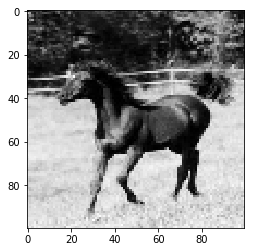

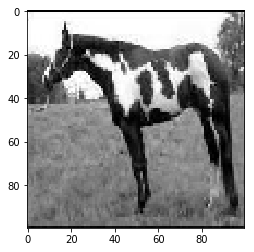

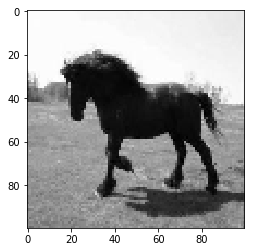

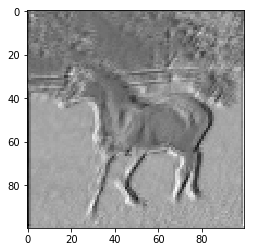

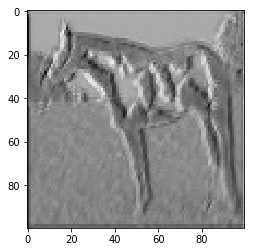

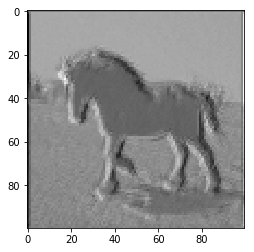

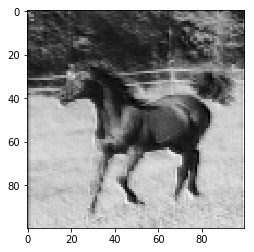

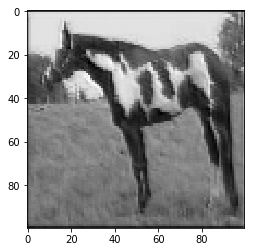

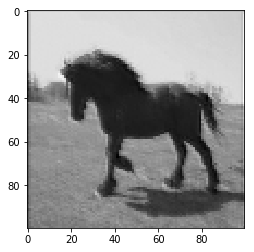

In [28]:
arr2 = generator.draw()
plot(np.expand_dims(arr2[:, 1], axis=1))
plot(np.expand_dims(arr2[:, 0], axis=1))
plot(np.expand_dims(np.sum(arr2, axis=1), axis=1))

In [29]:
d_logs_list, g_logs_list = GAN.extract_logs_tuple()

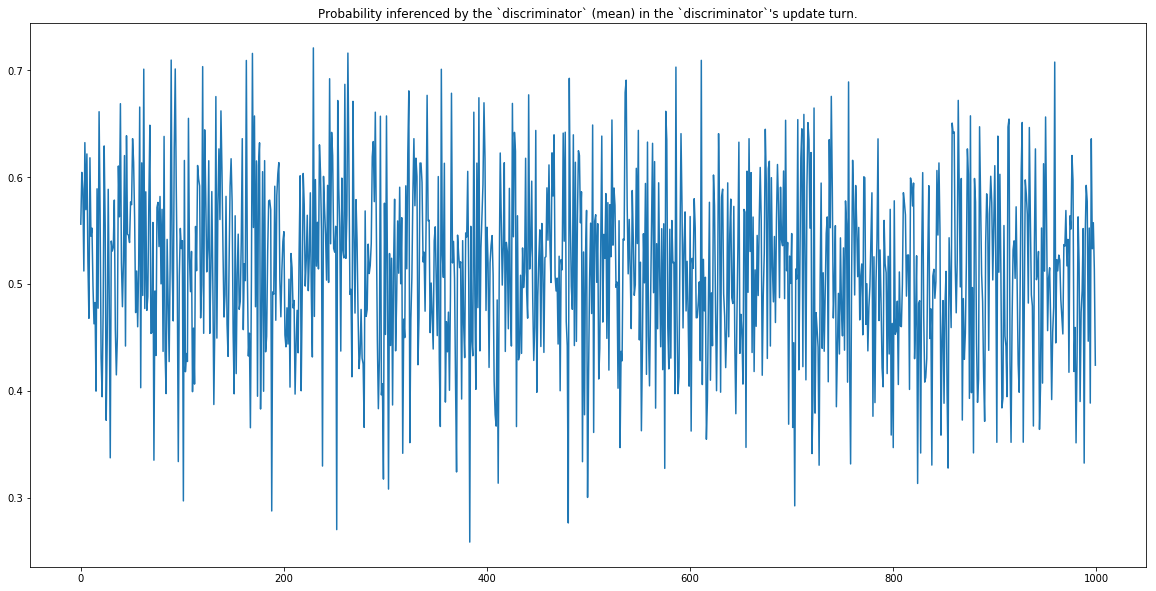

In [30]:
plt.figure(figsize=(20, 10))
plt.title("Probability inferenced by the `discriminator` (mean) in the `discriminator`'s update turn.")
plt.plot(d_logs_list)
plt.show()
plt.close()

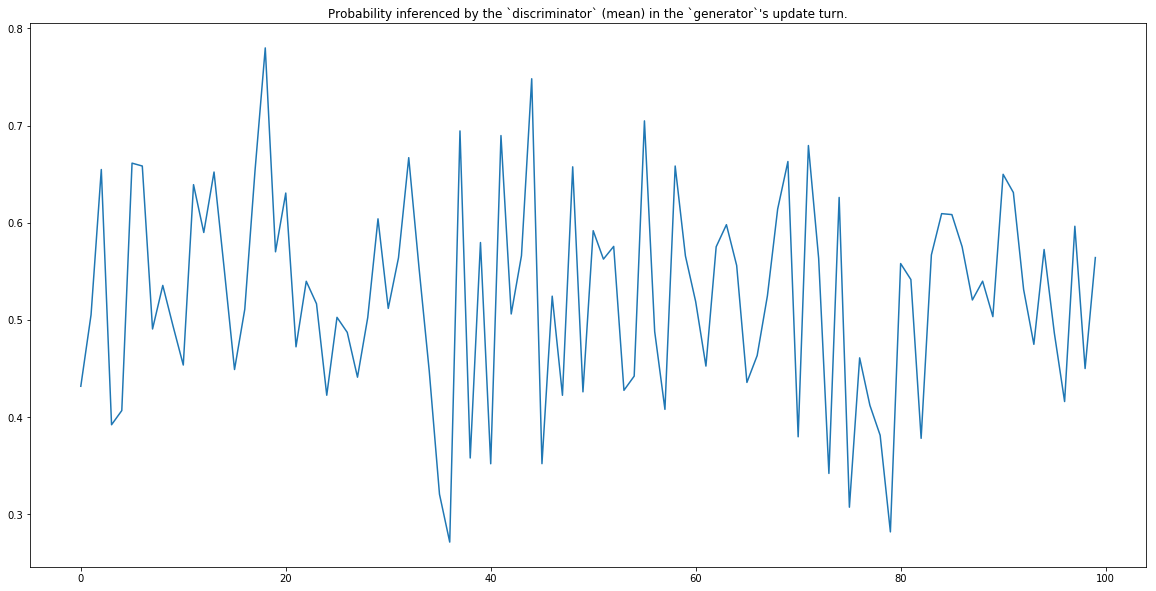

In [31]:
plt.figure(figsize=(20, 10))
plt.title("Probability inferenced by the `discriminator` (mean) in the `generator`'s update turn.")
plt.plot(g_logs_list)
plt.show()
plt.close()

In [32]:
generator, discriminator = GAN.train(
    true_sampler=conditional_image_true_sampler,
    generative_model=generator,
    discriminative_model=discriminator,
    iter_n=100,
    k_step=10
)

----------------------------------------------------------------------------------------------------
Iterations: (1/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5598765412684633
And update the `discriminator` by descending its stochastic gradient(means): -3.4956165036855777
Probability inferenced by the `discriminator` (mean): 0.5135378552064742
And update the `discriminator` by descending its stochastic gradient(means): -3.3074944758385207
Probability inferenced by the `discriminator` (mean): 0.5436679077084652
And update the `discriminator` by descending its stochastic gradient(means): -3.7913420660983284
Probability inferenced by the `discriminator` (mean): 0.5610241052169227
And update the `discriminator` by descending its stochastic gradie

And update the `discriminator` by descending its stochastic gradient(means): -3.3029835316318406
Probability inferenced by the `discriminator` (mean): 0.6521169537524263
And update the `discriminator` by descending its stochastic gradient(means): -3.7248851318472176
Probability inferenced by the `discriminator` (mean): 0.485144572531435
And update the `discriminator` by descending its stochastic gradient(means): -3.2101124714662346
Probability inferenced by the `discriminator` (mean): 0.4514438793393764
And update the `discriminator` by descending its stochastic gradient(means): -3.0969341082188677
Probability inferenced by the `discriminator` (mean): 0.6160114888238959
And update the `discriminator` by descending its stochastic gradient(means): -4.267212378492067
Probability inferenced by the `discriminator` (mean): 0.6064864846730221
And update the `discriminator` by descending its stochastic gradient(means): -3.4693493947786562
Probability inferenced by the `discriminator` (mean): 0

Probability inferenced by the `discriminator` (mean): 0.5112316437979015
And update the `discriminator` by descending its stochastic gradient(means): -3.4241139831919236
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.44149567746772356
And update the `generator` by descending its stochastic gradient(means): -1.3236437405563343e-05
----------------------------------------------------------------------------------------------------
Iterations: (8/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.42864854655733736
And upda

Probability inferenced by the `discriminator` (mean): 0.3844395707017109
And update the `discriminator` by descending its stochastic gradient(means): -2.8871574979260783
Probability inferenced by the `discriminator` (mean): 0.34613178170692926
And update the `discriminator` by descending its stochastic gradient(means): -3.117652920618872
Probability inferenced by the `discriminator` (mean): 0.5559233657969815
And update the `discriminator` by descending its stochastic gradient(means): -3.4117580621406853
Probability inferenced by the `discriminator` (mean): 0.6473723110451616
And update the `discriminator` by descending its stochastic gradient(means): -3.6865826610545946
Probability inferenced by the `discriminator` (mean): 0.513908800816995
And update the `discriminator` by descending its stochastic gradient(means): -3.6547673634511413
Probability inferenced by the `discriminator` (mean): 0.5043990628383982
And update the `discriminator` by descending its stochastic gradient(means): -

And update the `discriminator` by descending its stochastic gradient(means): -2.95838510367029
Probability inferenced by the `discriminator` (mean): 0.41872749630011485
And update the `discriminator` by descending its stochastic gradient(means): -3.481780873602048
Probability inferenced by the `discriminator` (mean): 0.44799637963488836
And update the `discriminator` by descending its stochastic gradient(means): -4.05327058658929
Probability inferenced by the `discriminator` (mean): 0.5293445867439773
And update the `discriminator` by descending its stochastic gradient(means): -3.5454534201706727
Probability inferenced by the `discriminator` (mean): 0.6376182539142314
And update the `discriminator` by descending its stochastic gradient(means): -4.038330573580254
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
P

The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4640047436977201
And update the `generator` by descending its stochastic gradient(means): 8.401030163623354e-06
----------------------------------------------------------------------------------------------------
Iterations: (18/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4863155116889347
And update the `discriminator` by descending its stochastic gradient(means): -3.480655851050191
Probability inferenced by the `discriminator` (mean): 0.454673289527227
And update the `discriminator` by descending its stochastic gradient(means): -3.1997822607148336
Probability infer

And update the `discriminator` by descending its stochastic gradient(means): -2.974372576706384
Probability inferenced by the `discriminator` (mean): 0.5418379314686417
And update the `discriminator` by descending its stochastic gradient(means): -3.364397216443625
Probability inferenced by the `discriminator` (mean): 0.5689995701319542
And update the `discriminator` by descending its stochastic gradient(means): -3.866599039419411
Probability inferenced by the `discriminator` (mean): 0.5375324593751027
And update the `discriminator` by descending its stochastic gradient(means): -3.328597095720305
Probability inferenced by the `discriminator` (mean): 0.5907791092352336
And update the `discriminator` by descending its stochastic gradient(means): -3.975488725780816
Probability inferenced by the `discriminator` (mean): 0.35546643852337023
And update the `discriminator` by descending its stochastic gradient(means): -3.003866400120276
Probability inferenced by the `discriminator` (mean): 0.67

Probability inferenced by the `discriminator` (mean): 0.38938799292105025
And update the `discriminator` by descending its stochastic gradient(means): -3.552302599350515
Probability inferenced by the `discriminator` (mean): 0.6104496371497357
And update the `discriminator` by descending its stochastic gradient(means): -3.6635674774282863
Probability inferenced by the `discriminator` (mean): 0.6197334569481845
And update the `discriminator` by descending its stochastic gradient(means): -3.7819873653923324
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4457457521790369
And update the `generator` by descending its stochastic gradient(means): 1.7674796907163398e-06
-----------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Iterations: (28/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4734982331846534
And update the `discriminator` by descending its stochastic gradient(means): -3.430892573008079
Probability inferenced by the `discriminator` (mean): 0.4034042346843366
And update the `discriminator` by descending its stochastic gradient(means): -3.0636547327523225
Probability inferenced by the `discriminator` (mean): 0.5421079603994037
And update the `discriminator` by descending its stochastic gradient(means): -3.8957724642886804
Probability inferenced by the `discriminator` (mean): 0.4905345713248212
And update the `discriminator` by descending its stochastic gradie

And update the `discriminator` by descending its stochastic gradient(means): -2.983779918100339
Probability inferenced by the `discriminator` (mean): 0.6675783515508743
And update the `discriminator` by descending its stochastic gradient(means): -3.5363030054967366
Probability inferenced by the `discriminator` (mean): 0.5362319494978063
And update the `discriminator` by descending its stochastic gradient(means): -3.257612983662748
Probability inferenced by the `discriminator` (mean): 0.3740035211678168
And update the `discriminator` by descending its stochastic gradient(means): -3.0314650667495027
Probability inferenced by the `discriminator` (mean): 0.5010372798148847
And update the `discriminator` by descending its stochastic gradient(means): -3.0310481250888563
Probability inferenced by the `discriminator` (mean): 0.4400880771628494
And update the `discriminator` by descending its stochastic gradient(means): -3.0006289002416344
Probability inferenced by the `discriminator` (mean): 0

Probability inferenced by the `discriminator` (mean): 0.6032802611697229
And update the `discriminator` by descending its stochastic gradient(means): -4.0766175502827
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.46469863208651824
And update the `generator` by descending its stochastic gradient(means): -1.1940210350441866e-06
----------------------------------------------------------------------------------------------------
Iterations: (35/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5222134978536033
And update 

Probability inferenced by the `discriminator` (mean): 0.5953401789256265
And update the `discriminator` by descending its stochastic gradient(means): -3.6038450994129505
Probability inferenced by the `discriminator` (mean): 0.4967766207703875
And update the `discriminator` by descending its stochastic gradient(means): -3.2376829949432953
Probability inferenced by the `discriminator` (mean): 0.3212889112194935
And update the `discriminator` by descending its stochastic gradient(means): -3.0435529906573735
Probability inferenced by the `discriminator` (mean): 0.44703575714160965
And update the `discriminator` by descending its stochastic gradient(means): -2.853484764692544
Probability inferenced by the `discriminator` (mean): 0.47310104967723127
And update the `discriminator` by descending its stochastic gradient(means): -3.400105282523898
Probability inferenced by the `discriminator` (mean): 0.40863149356524336
And update the `discriminator` by descending its stochastic gradient(means):

And update the `discriminator` by descending its stochastic gradient(means): -3.948227480272319
Probability inferenced by the `discriminator` (mean): 0.6413061701157278
And update the `discriminator` by descending its stochastic gradient(means): -3.5526325570927164
Probability inferenced by the `discriminator` (mean): 0.4760530536701076
And update the `discriminator` by descending its stochastic gradient(means): -3.462603893612819
Probability inferenced by the `discriminator` (mean): 0.48867302754691566
And update the `discriminator` by descending its stochastic gradient(means): -3.1085762575215083
Probability inferenced by the `discriminator` (mean): 0.6174412133871939
And update the `discriminator` by descending its stochastic gradient(means): -3.662696051503236
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------

The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5462193583803969
And update the `generator` by descending its stochastic gradient(means): -6.039622133611393e-06
----------------------------------------------------------------------------------------------------
Iterations: (45/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5576646304264806
And update the `discriminator` by descending its stochastic gradient(means): -3.6402799478885144
Probability inferenced by the `discriminator` (mean): 0.5002811286482923
And update the `discriminator` by descending its stochastic gradient(means): -3.5904093407292477
Probability in

And update the `discriminator` by descending its stochastic gradient(means): -2.8076669735597948
Probability inferenced by the `discriminator` (mean): 0.4501083326336353
And update the `discriminator` by descending its stochastic gradient(means): -3.5409056881140812
Probability inferenced by the `discriminator` (mean): 0.4713336758506796
And update the `discriminator` by descending its stochastic gradient(means): -3.1913950285335737
Probability inferenced by the `discriminator` (mean): 0.44433079080121374
And update the `discriminator` by descending its stochastic gradient(means): -3.3549582215334732
Probability inferenced by the `discriminator` (mean): 0.3651432772511234
And update the `discriminator` by descending its stochastic gradient(means): -2.8551371249026447
Probability inferenced by the `discriminator` (mean): 0.6100121795757873
And update the `discriminator` by descending its stochastic gradient(means): -4.0065652214043315
Probability inferenced by the `discriminator` (mean)

Probability inferenced by the `discriminator` (mean): 0.6110139235045878
And update the `discriminator` by descending its stochastic gradient(means): -3.544855679706783
Probability inferenced by the `discriminator` (mean): 0.5120024796465505
And update the `discriminator` by descending its stochastic gradient(means): -3.38155206850763
Probability inferenced by the `discriminator` (mean): 0.5271951769625988
And update the `discriminator` by descending its stochastic gradient(means): -3.391111839822689
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.45499248551105087
And update the `generator` by descending its stochastic gradient(means): 1.512491092044119e-05
---------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Iterations: (55/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5203222553613026
And update the `discriminator` by descending its stochastic gradient(means): -3.662577749315949
Probability inferenced by the `discriminator` (mean): 0.5145199152879113
And update the `discriminator` by descending its stochastic gradient(means): -3.574337482900161
Probability inferenced by the `discriminator` (mean): 0.38441412009053777
And update the `discriminator` by descending its stochastic gradient(means): -2.8225118402292515
Probability inferenced by the `discriminator` (mean): 0.5387751642543368
And update the `discriminator` by descending its stochastic gradie

And update the `discriminator` by descending its stochastic gradient(means): -3.280182261232234
Probability inferenced by the `discriminator` (mean): 0.6193153168862062
And update the `discriminator` by descending its stochastic gradient(means): -3.6538449205107177
Probability inferenced by the `discriminator` (mean): 0.39504823310844206
And update the `discriminator` by descending its stochastic gradient(means): -3.0038052400305815
Probability inferenced by the `discriminator` (mean): 0.4406974494421208
And update the `discriminator` by descending its stochastic gradient(means): -3.705744518171761
Probability inferenced by the `discriminator` (mean): 0.29753154293747586
And update the `discriminator` by descending its stochastic gradient(means): -2.908206461880746
Probability inferenced by the `discriminator` (mean): 0.5605968887166812
And update the `discriminator` by descending its stochastic gradient(means): -3.7008348804467004
Probability inferenced by the `discriminator` (mean): 

Probability inferenced by the `discriminator` (mean): 0.4146554204813281
And update the `discriminator` by descending its stochastic gradient(means): -3.2758996177918185
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.47024307985644576
And update the `generator` by descending its stochastic gradient(means): 4.775654868739179e-06
----------------------------------------------------------------------------------------------------
Iterations: (62/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5061741946654428
And update

Probability inferenced by the `discriminator` (mean): 0.4264571990167413
And update the `discriminator` by descending its stochastic gradient(means): -2.9588932569418094
Probability inferenced by the `discriminator` (mean): 0.4086654447058775
And update the `discriminator` by descending its stochastic gradient(means): -3.1659136544149384
Probability inferenced by the `discriminator` (mean): 0.39191999129044996
And update the `discriminator` by descending its stochastic gradient(means): -3.05872772715635
Probability inferenced by the `discriminator` (mean): 0.5054969323730976
And update the `discriminator` by descending its stochastic gradient(means): -3.2895687101944175
Probability inferenced by the `discriminator` (mean): 0.48162905444798626
And update the `discriminator` by descending its stochastic gradient(means): -3.074996563145042
Probability inferenced by the `discriminator` (mean): 0.4155650806926084
And update the `discriminator` by descending its stochastic gradient(means): -

And update the `discriminator` by descending its stochastic gradient(means): -3.352651637198575
Probability inferenced by the `discriminator` (mean): 0.55963594304702
And update the `discriminator` by descending its stochastic gradient(means): -3.289572275982299
Probability inferenced by the `discriminator` (mean): 0.41714626640200214
And update the `discriminator` by descending its stochastic gradient(means): -3.641321833687047
Probability inferenced by the `discriminator` (mean): 0.6407372045794164
And update the `discriminator` by descending its stochastic gradient(means): -4.2605750734932695
Probability inferenced by the `discriminator` (mean): 0.3738841406684669
And update the `discriminator` by descending its stochastic gradient(means): -3.4257131851461557
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
P

The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5038695113559377
And update the `generator` by descending its stochastic gradient(means): 6.798359717328453e-06
----------------------------------------------------------------------------------------------------
Iterations: (72/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3477771257677034
And update the `discriminator` by descending its stochastic gradient(means): -3.416891578984894
Probability inferenced by the `discriminator` (mean): 0.38058843845028434
And update the `discriminator` by descending its stochastic gradient(means): -3.16845141790735
Probability infer

And update the `discriminator` by descending its stochastic gradient(means): -3.856450092468625
Probability inferenced by the `discriminator` (mean): 0.634051427452955
And update the `discriminator` by descending its stochastic gradient(means): -3.372665070244404
Probability inferenced by the `discriminator` (mean): 0.4590844078010579
And update the `discriminator` by descending its stochastic gradient(means): -2.9079251720400796
Probability inferenced by the `discriminator` (mean): 0.48474091248247964
And update the `discriminator` by descending its stochastic gradient(means): -3.6428251915138157
Probability inferenced by the `discriminator` (mean): 0.5002726296152724
And update the `discriminator` by descending its stochastic gradient(means): -3.3984774098616746
Probability inferenced by the `discriminator` (mean): 0.49423169718131915
And update the `discriminator` by descending its stochastic gradient(means): -2.884991535294867
Probability inferenced by the `discriminator` (mean): 0

Probability inferenced by the `discriminator` (mean): 0.4256735237643149
And update the `discriminator` by descending its stochastic gradient(means): -3.5460976379547318
Probability inferenced by the `discriminator` (mean): 0.40189311314395776
And update the `discriminator` by descending its stochastic gradient(means): -3.759962178797976
Probability inferenced by the `discriminator` (mean): 0.5021326388688309
And update the `discriminator` by descending its stochastic gradient(means): -3.2858998867046587
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6532179160064178
And update the `generator` by descending its stochastic gradient(means): -1.3233947728373532e-05
----------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Iterations: (82/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4461751581640379
And update the `discriminator` by descending its stochastic gradient(means): -3.3189369173226013
Probability inferenced by the `discriminator` (mean): 0.5660087401739672
And update the `discriminator` by descending its stochastic gradient(means): -3.2066816686261106
Probability inferenced by the `discriminator` (mean): 0.4170917369463766
And update the `discriminator` by descending its stochastic gradient(means): -2.759298348080255
Probability inferenced by the `discriminator` (mean): 0.4133573258154879
And update the `discriminator` by descending its stochastic gradie

And update the `discriminator` by descending its stochastic gradient(means): -3.6166495302627695
Probability inferenced by the `discriminator` (mean): 0.4461434773946821
And update the `discriminator` by descending its stochastic gradient(means): -3.032802097671033
Probability inferenced by the `discriminator` (mean): 0.5171299563469708
And update the `discriminator` by descending its stochastic gradient(means): -3.278019156088819
Probability inferenced by the `discriminator` (mean): 0.3532342924958538
And update the `discriminator` by descending its stochastic gradient(means): -3.028517174145887
Probability inferenced by the `discriminator` (mean): 0.573619992476095
And update the `discriminator` by descending its stochastic gradient(means): -3.9195736306048836
Probability inferenced by the `discriminator` (mean): 0.531373227857284
And update the `discriminator` by descending its stochastic gradient(means): -3.3545369505368114
Probability inferenced by the `discriminator` (mean): 0.47

Probability inferenced by the `discriminator` (mean): 0.5278318337098582
And update the `discriminator` by descending its stochastic gradient(means): -3.563753279520628
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.45501253283573745
And update the `generator` by descending its stochastic gradient(means): -5.749885919451388e-06
----------------------------------------------------------------------------------------------------
Iterations: (89/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3497068929929618
And update

Probability inferenced by the `discriminator` (mean): 0.43192333594495036
And update the `discriminator` by descending its stochastic gradient(means): -3.5586591813690864
Probability inferenced by the `discriminator` (mean): 0.4694630940817782
And update the `discriminator` by descending its stochastic gradient(means): -3.6777189680854954
Probability inferenced by the `discriminator` (mean): 0.404195888419391
And update the `discriminator` by descending its stochastic gradient(means): -2.884445783574192
Probability inferenced by the `discriminator` (mean): 0.3453673601953984
And update the `discriminator` by descending its stochastic gradient(means): -3.0801102916080665
Probability inferenced by the `discriminator` (mean): 0.44249511815238274
And update the `discriminator` by descending its stochastic gradient(means): -2.816657226767652
Probability inferenced by the `discriminator` (mean): 0.42547700785882075
And update the `discriminator` by descending its stochastic gradient(means): 

And update the `discriminator` by descending its stochastic gradient(means): -3.698510151887688
Probability inferenced by the `discriminator` (mean): 0.40467930044653083
And update the `discriminator` by descending its stochastic gradient(means): -2.8453767015774187
Probability inferenced by the `discriminator` (mean): 0.5179849499380716
And update the `discriminator` by descending its stochastic gradient(means): -3.428873398763998
Probability inferenced by the `discriminator` (mean): 0.39772549560348536
And update the `discriminator` by descending its stochastic gradient(means): -3.3684600658557855
Probability inferenced by the `discriminator` (mean): 0.46471041593788576
And update the `discriminator` by descending its stochastic gradient(means): -3.3163123762564184
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
-------------------------------------------------------------------------------------------------

The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4356696695022143
And update the `generator` by descending its stochastic gradient(means): -1.9276938316509882e-05
----------------------------------------------------------------------------------------------------
Iterations: (99/100)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.654370696165469
And update the `discriminator` by descending its stochastic gradient(means): -4.134511469858369
Probability inferenced by the `discriminator` (mean): 0.5155866300835502
And update the `discriminator` by descending its stochastic gradient(means): -3.5419197155450233
Probability inf

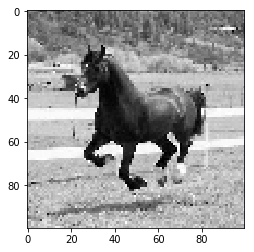

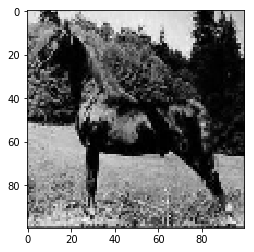

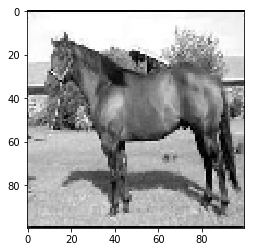

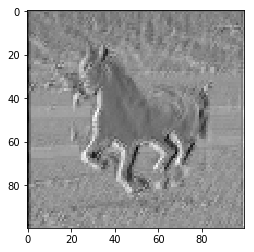

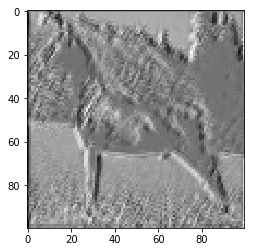

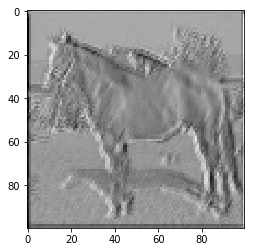

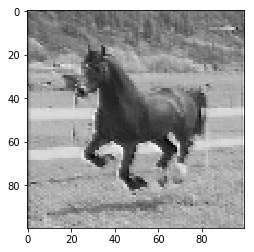

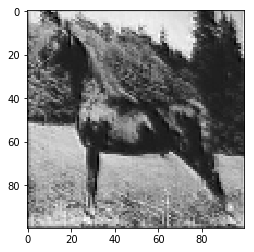

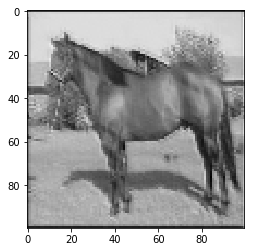

In [33]:
arr2 = generator.draw()
plot(np.expand_dims(arr2[:, 1], axis=1))
plot(np.expand_dims(arr2[:, 0], axis=1))
plot(np.expand_dims(np.sum(arr2, axis=1), axis=1))

In [34]:
d_logs_list, g_logs_list = GAN.extract_logs_tuple()

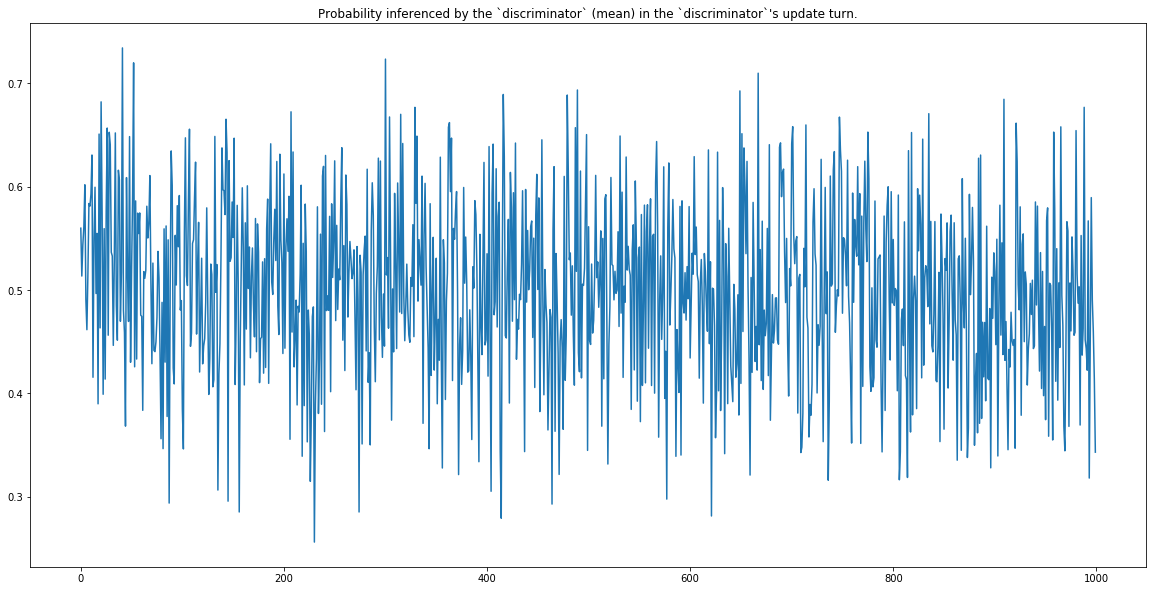

In [35]:
plt.figure(figsize=(20, 10))
plt.title("Probability inferenced by the `discriminator` (mean) in the `discriminator`'s update turn.")
plt.plot(d_logs_list)
plt.show()
plt.close()

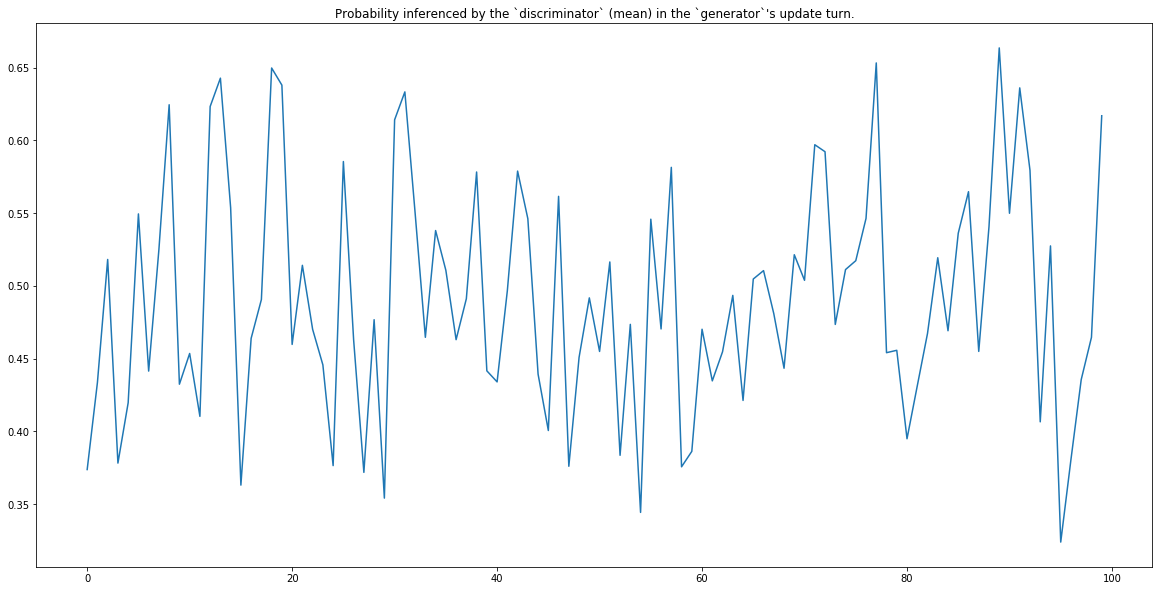

In [36]:
plt.figure(figsize=(20, 10))
plt.title("Probability inferenced by the `discriminator` (mean) in the `generator`'s update turn.")
plt.plot(g_logs_list)
plt.show()
plt.close()

In [37]:
generator, discriminator = GAN.train(
    true_sampler=conditional_image_true_sampler,
    generative_model=generator,
    discriminative_model=discriminator,
    iter_n=800,
    k_step=10
)

----------------------------------------------------------------------------------------------------
Iterations: (1/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4114515426476563
And update the `discriminator` by descending its stochastic gradient(means): -3.435728117615068
Probability inferenced by the `discriminator` (mean): 0.551811537892637
And update the `discriminator` by descending its stochastic gradient(means): -3.5982638308943558
Probability inferenced by the `discriminator` (mean): 0.4565146071140142
And update the `discriminator` by descending its stochastic gradient(means): -3.765344526343651
Probability inferenced by the `discriminator` (mean): 0.3363264935458644
And update the `discriminator` by descending its stochastic gradient(

And update the `discriminator` by descending its stochastic gradient(means): -3.5376068173812185
Probability inferenced by the `discriminator` (mean): 0.5081131501566112
And update the `discriminator` by descending its stochastic gradient(means): -3.645543255249032
Probability inferenced by the `discriminator` (mean): 0.4855946451804981
And update the `discriminator` by descending its stochastic gradient(means): -3.141769617471502
Probability inferenced by the `discriminator` (mean): 0.5954682972544124
And update the `discriminator` by descending its stochastic gradient(means): -4.032626862310574
Probability inferenced by the `discriminator` (mean): 0.4511643936089708
And update the `discriminator` by descending its stochastic gradient(means): -3.1158803116729987
Probability inferenced by the `discriminator` (mean): 0.4767533166821945
And update the `discriminator` by descending its stochastic gradient(means): -3.389352671172214
Probability inferenced by the `discriminator` (mean): 0.4

Probability inferenced by the `discriminator` (mean): 0.48086662886582865
And update the `discriminator` by descending its stochastic gradient(means): -3.456276499781647
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6837194710406249
And update the `generator` by descending its stochastic gradient(means): -1.9527506737835986e-05
----------------------------------------------------------------------------------------------------
Iterations: (8/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.45216743895420286
And updat

Probability inferenced by the `discriminator` (mean): 0.4176329804077434
And update the `discriminator` by descending its stochastic gradient(means): -3.5845669991056575
Probability inferenced by the `discriminator` (mean): 0.6350532441557262
And update the `discriminator` by descending its stochastic gradient(means): -3.6414725785128694
Probability inferenced by the `discriminator` (mean): 0.55426664969378
And update the `discriminator` by descending its stochastic gradient(means): -3.3415068598684234
Probability inferenced by the `discriminator` (mean): 0.5759766483893074
And update the `discriminator` by descending its stochastic gradient(means): -3.65637971088304
Probability inferenced by the `discriminator` (mean): 0.41104106583889344
And update the `discriminator` by descending its stochastic gradient(means): -3.0000505987794766
Probability inferenced by the `discriminator` (mean): 0.3480298844207733
And update the `discriminator` by descending its stochastic gradient(means): -3.

And update the `discriminator` by descending its stochastic gradient(means): -3.2552133018144915
Probability inferenced by the `discriminator` (mean): 0.5262939361125257
And update the `discriminator` by descending its stochastic gradient(means): -3.366760621016234
Probability inferenced by the `discriminator` (mean): 0.40224101025457754
And update the `discriminator` by descending its stochastic gradient(means): -3.0683544586193596
Probability inferenced by the `discriminator` (mean): 0.5948505226379791
And update the `discriminator` by descending its stochastic gradient(means): -3.2478547897156624
Probability inferenced by the `discriminator` (mean): 0.45394010984278876
And update the `discriminator` by descending its stochastic gradient(means): -3.3125398114200215
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
-------------------------------------------------------------------------------------------------

The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4761864822801852
And update the `generator` by descending its stochastic gradient(means): 1.8611621378808152e-06
----------------------------------------------------------------------------------------------------
Iterations: (18/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4110835226955151
And update the `discriminator` by descending its stochastic gradient(means): -3.2437571684420248
Probability inferenced by the `discriminator` (mean): 0.46657179240866764
And update the `discriminator` by descending its stochastic gradient(means): -3.3997547320823225
Probability i

And update the `discriminator` by descending its stochastic gradient(means): -3.5116073511975943
Probability inferenced by the `discriminator` (mean): 0.46505623228902015
And update the `discriminator` by descending its stochastic gradient(means): -3.979679880697355
Probability inferenced by the `discriminator` (mean): 0.5257727655506391
And update the `discriminator` by descending its stochastic gradient(means): -3.649292767470178
Probability inferenced by the `discriminator` (mean): 0.43424924428909567
And update the `discriminator` by descending its stochastic gradient(means): -3.4070595269778616
Probability inferenced by the `discriminator` (mean): 0.4980769043885897
And update the `discriminator` by descending its stochastic gradient(means): -3.3070813036639337
Probability inferenced by the `discriminator` (mean): 0.4332923386781671
And update the `discriminator` by descending its stochastic gradient(means): -3.494053690758117
Probability inferenced by the `discriminator` (mean): 

Probability inferenced by the `discriminator` (mean): 0.47207634820945127
And update the `discriminator` by descending its stochastic gradient(means): -3.427575406469798
Probability inferenced by the `discriminator` (mean): 0.5510405804434485
And update the `discriminator` by descending its stochastic gradient(means): -3.2240797583594913
Probability inferenced by the `discriminator` (mean): 0.43429780242637905
And update the `discriminator` by descending its stochastic gradient(means): -3.3291573908913157
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.36239425325096414
And update the `generator` by descending its stochastic gradient(means): -1.9959160590281097e-05
--------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Iterations: (28/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.48773475718486203
And update the `discriminator` by descending its stochastic gradient(means): -3.465956097024305
Probability inferenced by the `discriminator` (mean): 0.49526414483895165
And update the `discriminator` by descending its stochastic gradient(means): -3.555701065679532
Probability inferenced by the `discriminator` (mean): 0.46839171904410826
And update the `discriminator` by descending its stochastic gradient(means): -3.0739967719522534
Probability inferenced by the `discriminator` (mean): 0.49684875684198093
And update the `discriminator` by descending its stochastic gra

Probability inferenced by the `discriminator` (mean): 0.6231191476731284
And update the `discriminator` by descending its stochastic gradient(means): -3.5739227320313014
Probability inferenced by the `discriminator` (mean): 0.5716523913748901
And update the `discriminator` by descending its stochastic gradient(means): -3.611006026401001
Probability inferenced by the `discriminator` (mean): 0.4443023878458024
And update the `discriminator` by descending its stochastic gradient(means): -2.9961292626409413
Probability inferenced by the `discriminator` (mean): 0.4094708365270372
And update the `discriminator` by descending its stochastic gradient(means): -3.3155177005872583
Probability inferenced by the `discriminator` (mean): 0.42370465170529015
And update the `discriminator` by descending its stochastic gradient(means): -2.7062912264832155
Probability inferenced by the `discriminator` (mean): 0.5911209255894208
And update the `discriminator` by descending its stochastic gradient(means): 

And update the `discriminator` by descending its stochastic gradient(means): -3.023189323489296
Probability inferenced by the `discriminator` (mean): 0.6395263867762726
And update the `discriminator` by descending its stochastic gradient(means): -4.098485101665922
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4359535440147696
And update the `generator` by descending its stochastic gradient(means): 1.3960959782849666e-05
----------------------------------------------------------------------------------------------------
Iterations: (35/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
-----------------------------------------------------------------------------------------

The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4560003497212211
And update the `discriminator` by descending its stochastic gradient(means): -3.05026862051172
Probability inferenced by the `discriminator` (mean): 0.44504257675670117
And update the `discriminator` by descending its stochastic gradient(means): -3.6458065083104123
Probability inferenced by the `discriminator` (mean): 0.5088158495432724
And update the `discriminator` by descending its stochastic gradient(means): -3.3930263527251308
Probability inferenced by the `discriminator` (mean): 0.6703567528026764
And update the `discriminator` by descending its stochastic gradient(means): -4.131177372362234
Probability inferenced by the `discriminator` (mean): 0.39551316651816776
And update the `discriminator` by descending its stochastic gradient(means): -3.220800864950231
Probability inferenced 

And update the `discriminator` by descending its stochastic gradient(means): -3.798362310528178
Probability inferenced by the `discriminator` (mean): 0.5064405408422362
And update the `discriminator` by descending its stochastic gradient(means): -3.2944264398164416
Probability inferenced by the `discriminator` (mean): 0.530390407248604
And update the `discriminator` by descending its stochastic gradient(means): -3.3751755365801883
Probability inferenced by the `discriminator` (mean): 0.35807772775667707
And update the `discriminator` by descending its stochastic gradient(means): -3.158992832556399
Probability inferenced by the `discriminator` (mean): 0.3445361476667334
And update the `discriminator` by descending its stochastic gradient(means): -2.946198120969686
Probability inferenced by the `discriminator` (mean): 0.6006488929256439
And update the `discriminator` by descending its stochastic gradient(means): -3.521639041248297
---------------------------------------------------------

----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4803621076123917
And update the `generator` by descending its stochastic gradient(means): -6.710581579454169e-06
----------------------------------------------------------------------------------------------------
Iterations: (45/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.49175701307042397
And update the `discriminator` by descending its stochastic gradient(means): -3.1507951226198068
Probability inferenced by the `discriminator` (mean): 0.6129541555803901
And updat

Probability inferenced by the `discriminator` (mean): 0.4002672905956695
And update the `discriminator` by descending its stochastic gradient(means): -3.400287470811589
Probability inferenced by the `discriminator` (mean): 0.44718809798515713
And update the `discriminator` by descending its stochastic gradient(means): -2.970652340778815
Probability inferenced by the `discriminator` (mean): 0.5914324473569554
And update the `discriminator` by descending its stochastic gradient(means): -3.1734508089790228
Probability inferenced by the `discriminator` (mean): 0.4930912314942352
And update the `discriminator` by descending its stochastic gradient(means): -3.5999106845509545
Probability inferenced by the `discriminator` (mean): 0.44453683540568606
And update the `discriminator` by descending its stochastic gradient(means): -3.0259078295044093
Probability inferenced by the `discriminator` (mean): 0.3379427212130068
And update the `discriminator` by descending its stochastic gradient(means): 

And update the `discriminator` by descending its stochastic gradient(means): -3.19272005807886
Probability inferenced by the `discriminator` (mean): 0.5869745472919831
And update the `discriminator` by descending its stochastic gradient(means): -3.8161625850358454
Probability inferenced by the `discriminator` (mean): 0.48328874291072726
And update the `discriminator` by descending its stochastic gradient(means): -3.3506666151314297
Probability inferenced by the `discriminator` (mean): 0.4301340558006803
And update the `discriminator` by descending its stochastic gradient(means): -3.3146227954545457
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.39458915770682307
And update the `generator` by descending its stochastic gradient(means): 8.245021866565859e-07

And update the `generator` by descending its stochastic gradient(means): 2.0803030518593136e-05
----------------------------------------------------------------------------------------------------
Iterations: (55/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5523806504039145
And update the `discriminator` by descending its stochastic gradient(means): -3.3831265961572043
Probability inferenced by the `discriminator` (mean): 0.4426056950132285
And update the `discriminator` by descending its stochastic gradient(means): -3.3379498232882576
Probability inferenced by the `discriminator` (mean): 0.49431417019828194
And update the `discriminator` by descending its stochastic gradient(means): -2.9759381280778534
Probability inferenced by the `discrimina

Probability inferenced by the `discriminator` (mean): 0.4668636923771238
And update the `discriminator` by descending its stochastic gradient(means): -3.009883027942731
Probability inferenced by the `discriminator` (mean): 0.5769899547999966
And update the `discriminator` by descending its stochastic gradient(means): -3.832187944241297
Probability inferenced by the `discriminator` (mean): 0.35439326513145597
And update the `discriminator` by descending its stochastic gradient(means): -3.00267042015747
Probability inferenced by the `discriminator` (mean): 0.5112401242848048
And update the `discriminator` by descending its stochastic gradient(means): -3.3348445137690392
Probability inferenced by the `discriminator` (mean): 0.6440819207025967
And update the `discriminator` by descending its stochastic gradient(means): -4.139429328569351
Probability inferenced by the `discriminator` (mean): 0.590391513571468
And update the `discriminator` by descending its stochastic gradient(means): -3.98

And update the `discriminator` by descending its stochastic gradient(means): -2.8298791756279678
Probability inferenced by the `discriminator` (mean): 0.47846639220312176
And update the `discriminator` by descending its stochastic gradient(means): -3.345373979605712
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5694891708884057
And update the `generator` by descending its stochastic gradient(means): -1.7596154268735924e-05
----------------------------------------------------------------------------------------------------
Iterations: (62/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
--------------------------------------------------------------------------------------

The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.662032292178323
And update the `discriminator` by descending its stochastic gradient(means): -3.58878904477711
Probability inferenced by the `discriminator` (mean): 0.48570661212874217
And update the `discriminator` by descending its stochastic gradient(means): -3.862160830341872
Probability inferenced by the `discriminator` (mean): 0.4334208499278218
And update the `discriminator` by descending its stochastic gradient(means): -3.1637650845518053
Probability inferenced by the `discriminator` (mean): 0.3839171151362035
And update the `discriminator` by descending its stochastic gradient(means): -3.712986265509861
Probability inferenced by the `discriminator` (mean): 0.5374558176586572
And update the `discriminator` by descending its stochastic gradient(means): -3.3719591429298417
Probability inferenced by

And update the `discriminator` by descending its stochastic gradient(means): -3.093821481672846
Probability inferenced by the `discriminator` (mean): 0.5315139046814741
And update the `discriminator` by descending its stochastic gradient(means): -3.4088069441182056
Probability inferenced by the `discriminator` (mean): 0.5448064558001449
And update the `discriminator` by descending its stochastic gradient(means): -3.695994967617054
Probability inferenced by the `discriminator` (mean): 0.47722812538505366
And update the `discriminator` by descending its stochastic gradient(means): -3.4369742589785455
Probability inferenced by the `discriminator` (mean): 0.5103602633794079
And update the `discriminator` by descending its stochastic gradient(means): -3.2798797379259668
Probability inferenced by the `discriminator` (mean): 0.4653878875416301
And update the `discriminator` by descending its stochastic gradient(means): -3.495165665625813
-------------------------------------------------------

----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4346739288424267
And update the `generator` by descending its stochastic gradient(means): 1.960308056507944e-05
----------------------------------------------------------------------------------------------------
Iterations: (72/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.30586260031765605
And update the `discriminator` by descending its stochastic gradient(means): -3.2800506359888493
Probability inferenced by the `discriminator` (mean): 0.5279982424421531
And update

Probability inferenced by the `discriminator` (mean): 0.4689634424247718
And update the `discriminator` by descending its stochastic gradient(means): -3.296858743837204
Probability inferenced by the `discriminator` (mean): 0.48216816941967017
And update the `discriminator` by descending its stochastic gradient(means): -3.1253160655486214
Probability inferenced by the `discriminator` (mean): 0.4227502261711761
And update the `discriminator` by descending its stochastic gradient(means): -3.1863735454488133
Probability inferenced by the `discriminator` (mean): 0.4940689623923049
And update the `discriminator` by descending its stochastic gradient(means): -3.50058949826251
Probability inferenced by the `discriminator` (mean): 0.6575182307608944
And update the `discriminator` by descending its stochastic gradient(means): -4.548847486310059
Probability inferenced by the `discriminator` (mean): 0.5555340514551064
And update the `discriminator` by descending its stochastic gradient(means): -3.

And update the `discriminator` by descending its stochastic gradient(means): -3.804907413144882
Probability inferenced by the `discriminator` (mean): 0.5483456828592199
And update the `discriminator` by descending its stochastic gradient(means): -3.3044959671918948
Probability inferenced by the `discriminator` (mean): 0.5433051716760959
And update the `discriminator` by descending its stochastic gradient(means): -3.8085214435178507
Probability inferenced by the `discriminator` (mean): 0.5829711684234018
And update the `discriminator` by descending its stochastic gradient(means): -3.9594335148032442
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5278787632342243
And update the `generator` by descending its stochastic gradient(means): -1.7391086426794683e-0

And update the `generator` by descending its stochastic gradient(means): -1.3234135669465243e-05
----------------------------------------------------------------------------------------------------
Iterations: (82/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.49867547141599927
And update the `discriminator` by descending its stochastic gradient(means): -3.3188300802637087
Probability inferenced by the `discriminator` (mean): 0.4821804614713585
And update the `discriminator` by descending its stochastic gradient(means): -3.43432567055664
Probability inferenced by the `discriminator` (mean): 0.6275086025970144
And update the `discriminator` by descending its stochastic gradient(means): -3.824755918978737
Probability inferenced by the `discriminato

Probability inferenced by the `discriminator` (mean): 0.7252738791505051
And update the `discriminator` by descending its stochastic gradient(means): -4.543363472341655
Probability inferenced by the `discriminator` (mean): 0.43403767785588043
And update the `discriminator` by descending its stochastic gradient(means): -3.5014898384594786
Probability inferenced by the `discriminator` (mean): 0.5438014634405128
And update the `discriminator` by descending its stochastic gradient(means): -3.5726450233131977
Probability inferenced by the `discriminator` (mean): 0.46100231018362364
And update the `discriminator` by descending its stochastic gradient(means): -3.1159261944957493
Probability inferenced by the `discriminator` (mean): 0.5914948612280226
And update the `discriminator` by descending its stochastic gradient(means): -3.9684004663833385
Probability inferenced by the `discriminator` (mean): 0.49213216343004795
And update the `discriminator` by descending its stochastic gradient(means)

And update the `discriminator` by descending its stochastic gradient(means): -3.154504194657318
Probability inferenced by the `discriminator` (mean): 0.3514293730001864
And update the `discriminator` by descending its stochastic gradient(means): -3.2466120826727973
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4762555003415502
And update the `generator` by descending its stochastic gradient(means): -6.083119880561952e-06
----------------------------------------------------------------------------------------------------
Iterations: (89/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------

The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.36008590658239414
And update the `discriminator` by descending its stochastic gradient(means): -3.0648013733813864
Probability inferenced by the `discriminator` (mean): 0.5630082214454688
And update the `discriminator` by descending its stochastic gradient(means): -3.63016578370308
Probability inferenced by the `discriminator` (mean): 0.529043074333039
And update the `discriminator` by descending its stochastic gradient(means): -3.8019308490394166
Probability inferenced by the `discriminator` (mean): 0.3793277714401419
And update the `discriminator` by descending its stochastic gradient(means): -2.818997422494353
Probability inferenced by the `discriminator` (mean): 0.6039228107251461
And update the `discriminator` by descending its stochastic gradient(means): -3.650579958219576
Probability inferenced by

And update the `discriminator` by descending its stochastic gradient(means): -3.7197027362252655
Probability inferenced by the `discriminator` (mean): 0.36856239693137216
And update the `discriminator` by descending its stochastic gradient(means): -2.69351668647348
Probability inferenced by the `discriminator` (mean): 0.3819859492931698
And update the `discriminator` by descending its stochastic gradient(means): -3.7230113283196324
Probability inferenced by the `discriminator` (mean): 0.47895290507409244
And update the `discriminator` by descending its stochastic gradient(means): -3.0816985273881494
Probability inferenced by the `discriminator` (mean): 0.48656067904682354
And update the `discriminator` by descending its stochastic gradient(means): -3.386572576213328
Probability inferenced by the `discriminator` (mean): 0.46955608637764784
And update the `discriminator` by descending its stochastic gradient(means): -3.57174783316164
------------------------------------------------------

----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.37806160527429733
And update the `generator` by descending its stochastic gradient(means): 2.0900998316447975e-05
----------------------------------------------------------------------------------------------------
Iterations: (99/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3719712961311434
And update the `discriminator` by descending its stochastic gradient(means): -3.511804878449228
Probability inferenced by the `discriminator` (mean): 0.5492963440733855
And update

Probability inferenced by the `discriminator` (mean): 0.4868041810369522
And update the `discriminator` by descending its stochastic gradient(means): -3.5423781584792686
Probability inferenced by the `discriminator` (mean): 0.5081444235395545
And update the `discriminator` by descending its stochastic gradient(means): -3.2493262861349974
Probability inferenced by the `discriminator` (mean): 0.4614265112504171
And update the `discriminator` by descending its stochastic gradient(means): -3.5248365109165314
Probability inferenced by the `discriminator` (mean): 0.3196280185905702
And update the `discriminator` by descending its stochastic gradient(means): -2.624792700415643
Probability inferenced by the `discriminator` (mean): 0.4036752814141276
And update the `discriminator` by descending its stochastic gradient(means): -3.3057749106208134
Probability inferenced by the `discriminator` (mean): 0.33685258948480856
And update the `discriminator` by descending its stochastic gradient(means): 

And update the `discriminator` by descending its stochastic gradient(means): -3.01782794472363
Probability inferenced by the `discriminator` (mean): 0.4557597739380421
And update the `discriminator` by descending its stochastic gradient(means): -3.226534946090549
Probability inferenced by the `discriminator` (mean): 0.37757103669054093
And update the `discriminator` by descending its stochastic gradient(means): -3.3424642982142814
Probability inferenced by the `discriminator` (mean): 0.3509004667745045
And update the `discriminator` by descending its stochastic gradient(means): -2.9018733342170826
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5262478350997022
And update the `generator` by descending its stochastic gradient(means): -4.325741787423658e-06


And update the `generator` by descending its stochastic gradient(means): -1.821981944824367e-05
----------------------------------------------------------------------------------------------------
Iterations: (109/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5576051451951287
And update the `discriminator` by descending its stochastic gradient(means): -3.9488125935880247
Probability inferenced by the `discriminator` (mean): 0.5006324683321448
And update the `discriminator` by descending its stochastic gradient(means): -3.4991323022225607
Probability inferenced by the `discriminator` (mean): 0.4156469504982603
And update the `discriminator` by descending its stochastic gradient(means): -3.0584211834379973
Probability inferenced by the `discrimina

And update the `discriminator` by descending its stochastic gradient(means): -3.185724389811586
Probability inferenced by the `discriminator` (mean): 0.5246026355271051
And update the `discriminator` by descending its stochastic gradient(means): -3.1313274821351675
Probability inferenced by the `discriminator` (mean): 0.5647672520352572
And update the `discriminator` by descending its stochastic gradient(means): -3.751374714475974
Probability inferenced by the `discriminator` (mean): 0.392064356574526
And update the `discriminator` by descending its stochastic gradient(means): -3.299720156901654
Probability inferenced by the `discriminator` (mean): 0.40983770712995654
And update the `discriminator` by descending its stochastic gradient(means): -2.959445461563315
Probability inferenced by the `discriminator` (mean): 0.38207072205316706
And update the `discriminator` by descending its stochastic gradient(means): -3.5325134415159405
Probability inferenced by the `discriminator` (mean): 0.

Probability inferenced by the `discriminator` (mean): 0.5268867381639781
And update the `discriminator` by descending its stochastic gradient(means): -3.240861965863762
Probability inferenced by the `discriminator` (mean): 0.6126326824218957
And update the `discriminator` by descending its stochastic gradient(means): -3.6238934019849176
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.49477296493857165
And update the `generator` by descending its stochastic gradient(means): 4.093984170490241e-06
----------------------------------------------------------------------------------------------------
Iterations: (116/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
--------------

----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.48304708117025663
And update the `discriminator` by descending its stochastic gradient(means): -3.3853951740981314
Probability inferenced by the `discriminator` (mean): 0.5499947365659165
And update the `discriminator` by descending its stochastic gradient(means): -3.4538744666067585
Probability inferenced by the `discriminator` (mean): 0.6476471958472987
And update the `discriminator` by descending its stochastic gradient(means): -3.96477291644835
Probability inferenced by the `discriminator` (mean): 0.4063043943342806
And update the `discriminator` by descending its stochastic gradient(means): -3.3338089524979018
Probability inferenced by the `discriminator` (mean): 0.6234157689156573
And update the `di

Probability inferenced by the `discriminator` (mean): 0.4347660544180411
And update the `discriminator` by descending its stochastic gradient(means): -2.919603058636498
Probability inferenced by the `discriminator` (mean): 0.44704894620037017
And update the `discriminator` by descending its stochastic gradient(means): -3.24126393620143
Probability inferenced by the `discriminator` (mean): 0.3672761992158138
And update the `discriminator` by descending its stochastic gradient(means): -3.023077346668704
Probability inferenced by the `discriminator` (mean): 0.3707459295408195
And update the `discriminator` by descending its stochastic gradient(means): -3.062991090431631
Probability inferenced by the `discriminator` (mean): 0.4653398339318372
And update the `discriminator` by descending its stochastic gradient(means): -3.6029468776026854
Probability inferenced by the `discriminator` (mean): 0.44752936981312896
And update the `discriminator` by descending its stochastic gradient(means): -3.

And update the `discriminator` by descending its stochastic gradient(means): -3.1731663906312386
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5739482459222282
And update the `generator` by descending its stochastic gradient(means): 9.154835464039306e-06
----------------------------------------------------------------------------------------------------
Iterations: (126/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.40309418832099564
And update the `discriminator` by descending its stochastic gradient(means): -3.04

And update the `discriminator` by descending its stochastic gradient(means): -3.454798270139812
Probability inferenced by the `discriminator` (mean): 0.42089584340165187
And update the `discriminator` by descending its stochastic gradient(means): -3.0289164057419744
Probability inferenced by the `discriminator` (mean): 0.3992734452491778
And update the `discriminator` by descending its stochastic gradient(means): -3.282514837754584
Probability inferenced by the `discriminator` (mean): 0.4634878635091576
And update the `discriminator` by descending its stochastic gradient(means): -3.077150499727535
Probability inferenced by the `discriminator` (mean): 0.34342933096431866
And update the `discriminator` by descending its stochastic gradient(means): -3.3238274191011192
Probability inferenced by the `discriminator` (mean): 0.3779031805068835
And update the `discriminator` by descending its stochastic gradient(means): -3.443321145309759
Probability inferenced by the `discriminator` (mean): 0

Probability inferenced by the `discriminator` (mean): 0.5975613736205879
And update the `discriminator` by descending its stochastic gradient(means): -3.501772438020788
Probability inferenced by the `discriminator` (mean): 0.5765049079219777
And update the `discriminator` by descending its stochastic gradient(means): -3.6063191819102074
Probability inferenced by the `discriminator` (mean): 0.6264056569782336
And update the `discriminator` by descending its stochastic gradient(means): -4.022574233052238
Probability inferenced by the `discriminator` (mean): 0.6074955919446478
And update the `discriminator` by descending its stochastic gradient(means): -4.152871417045323
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.580022078248994
And update the `generator

Probability inferenced by the `discriminator` (mean): 0.6595523186485767
And update the `generator` by descending its stochastic gradient(means): 1.811755172190492e-05
----------------------------------------------------------------------------------------------------
Iterations: (136/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.42039718341798815
And update the `discriminator` by descending its stochastic gradient(means): -3.4169410860892375
Probability inferenced by the `discriminator` (mean): 0.47731694312857426
And update the `discriminator` by descending its stochastic gradient(means): -3.083796600520664
Probability inferenced by the `discriminator` (mean): 0.48115470447175934
And update the `discriminator` by descending its stochastic grad

Probability inferenced by the `discriminator` (mean): 0.4619959708946162
And update the `discriminator` by descending its stochastic gradient(means): -3.30880674780905
Probability inferenced by the `discriminator` (mean): 0.5317492511091519
And update the `discriminator` by descending its stochastic gradient(means): -3.478729531951431
Probability inferenced by the `discriminator` (mean): 0.5453968004640992
And update the `discriminator` by descending its stochastic gradient(means): -3.933010041165322
Probability inferenced by the `discriminator` (mean): 0.4560837534324974
And update the `discriminator` by descending its stochastic gradient(means): -3.326909674467964
Probability inferenced by the `discriminator` (mean): 0.3770441754405499
And update the `discriminator` by descending its stochastic gradient(means): -3.1783514675661615
Probability inferenced by the `discriminator` (mean): 0.3160479287890789
And update the `discriminator` by descending its stochastic gradient(means): -3.34

And update the `discriminator` by descending its stochastic gradient(means): -2.926124498940282
Probability inferenced by the `discriminator` (mean): 0.47264481927750934
And update the `discriminator` by descending its stochastic gradient(means): -3.345822509010982
Probability inferenced by the `discriminator` (mean): 0.26844237464035053
And update the `discriminator` by descending its stochastic gradient(means): -2.9516643528050346
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.406995257615959
And update the `generator` by descending its stochastic gradient(means): 3.2826005841479e-06
----------------------------------------------------------------------------------------------------
Iterations: (143/800)
-------------------------------------------------

Iterations: (146/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4324201542439162
And update the `discriminator` by descending its stochastic gradient(means): -3.2092995763716177
Probability inferenced by the `discriminator` (mean): 0.5829564500234496
And update the `discriminator` by descending its stochastic gradient(means): -3.4297690275505985
Probability inferenced by the `discriminator` (mean): 0.45869653454840176
And update the `discriminator` by descending its stochastic gradient(means): -3.276146705027268
Probability inferenced by the `discriminator` (mean): 0.6511666881335567
And update the `discriminator` by descending its stochastic gradient(means): -3.820836205676366
Probability inferenced by the `discriminator` (mean): 0.4368389322049

Probability inferenced by the `discriminator` (mean): 0.5078897967542069
And update the `discriminator` by descending its stochastic gradient(means): -3.2594074933556003
Probability inferenced by the `discriminator` (mean): 0.541720925805299
And update the `discriminator` by descending its stochastic gradient(means): -3.937588808241105
Probability inferenced by the `discriminator` (mean): 0.42241898115360776
And update the `discriminator` by descending its stochastic gradient(means): -3.0610405920236365
Probability inferenced by the `discriminator` (mean): 0.46979789817689904
And update the `discriminator` by descending its stochastic gradient(means): -3.187796422081801
Probability inferenced by the `discriminator` (mean): 0.6308383198401957
And update the `discriminator` by descending its stochastic gradient(means): -3.665992566455343
Probability inferenced by the `discriminator` (mean): 0.509775813122832
And update the `discriminator` by descending its stochastic gradient(means): -3.

And update the `discriminator` by descending its stochastic gradient(means): -3.1545615806250327
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.46038380731984063
And update the `generator` by descending its stochastic gradient(means): 4.37969396788907e-06
----------------------------------------------------------------------------------------------------
Iterations: (153/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.44268630815652343
And update the `discriminator` by descending its stochastic gradient(means): -3.16

And update the `discriminator` by descending its stochastic gradient(means): -3.1375005876343356
Probability inferenced by the `discriminator` (mean): 0.47239316945110055
And update the `discriminator` by descending its stochastic gradient(means): -3.3706449897713617
Probability inferenced by the `discriminator` (mean): 0.47798398404008624
And update the `discriminator` by descending its stochastic gradient(means): -3.1472388372280875
Probability inferenced by the `discriminator` (mean): 0.3938465817604095
And update the `discriminator` by descending its stochastic gradient(means): -3.199918503100504
Probability inferenced by the `discriminator` (mean): 0.49689544881021186
And update the `discriminator` by descending its stochastic gradient(means): -3.423902398645133
Probability inferenced by the `discriminator` (mean): 0.5861528627254853
And update the `discriminator` by descending its stochastic gradient(means): -3.4996256193485222
Probability inferenced by the `discriminator` (mean)

Probability inferenced by the `discriminator` (mean): 0.4363400924352021
And update the `discriminator` by descending its stochastic gradient(means): -3.093340482172359
Probability inferenced by the `discriminator` (mean): 0.45977308986321075
And update the `discriminator` by descending its stochastic gradient(means): -3.4367726693219227
Probability inferenced by the `discriminator` (mean): 0.48997648922052905
And update the `discriminator` by descending its stochastic gradient(means): -3.842474319608975
Probability inferenced by the `discriminator` (mean): 0.3432505158813067
And update the `discriminator` by descending its stochastic gradient(means): -2.9774346353913
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4354936414918721
And update the `generato

Probability inferenced by the `discriminator` (mean): 0.45084935403174314
And update the `generator` by descending its stochastic gradient(means): -2.4047378095955775e-06
----------------------------------------------------------------------------------------------------
Iterations: (163/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3417415359350374
And update the `discriminator` by descending its stochastic gradient(means): -3.357395345210633
Probability inferenced by the `discriminator` (mean): 0.4199687872420256
And update the `discriminator` by descending its stochastic gradient(means): -2.9739141550602084
Probability inferenced by the `discriminator` (mean): 0.40755884445198287
And update the `discriminator` by descending its stochastic gra

And update the `discriminator` by descending its stochastic gradient(means): -3.70483606023825
Probability inferenced by the `discriminator` (mean): 0.5236727865627324
And update the `discriminator` by descending its stochastic gradient(means): -3.359818679031961
Probability inferenced by the `discriminator` (mean): 0.4136783054598
And update the `discriminator` by descending its stochastic gradient(means): -2.9188274339320683
Probability inferenced by the `discriminator` (mean): 0.46580746819667357
And update the `discriminator` by descending its stochastic gradient(means): -3.4048667675114737
Probability inferenced by the `discriminator` (mean): 0.4863867935966086
And update the `discriminator` by descending its stochastic gradient(means): -3.1999989012622754
Probability inferenced by the `discriminator` (mean): 0.5824291188649384
And update the `discriminator` by descending its stochastic gradient(means): -3.572237546152313
Probability inferenced by the `discriminator` (mean): 0.547

Probability inferenced by the `discriminator` (mean): 0.5323368041257183
And update the `discriminator` by descending its stochastic gradient(means): -3.3433786201207463
Probability inferenced by the `discriminator` (mean): 0.4874729089575053
And update the `discriminator` by descending its stochastic gradient(means): -3.981293506486091
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.36543374269928774
And update the `generator` by descending its stochastic gradient(means): 6.617317598140574e-06
----------------------------------------------------------------------------------------------------
Iterations: (170/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
--------------

----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4657460012804945
And update the `discriminator` by descending its stochastic gradient(means): -3.455858837019015
Probability inferenced by the `discriminator` (mean): 0.4918949503267355
And update the `discriminator` by descending its stochastic gradient(means): -3.5187444273125763
Probability inferenced by the `discriminator` (mean): 0.43965101664957135
And update the `discriminator` by descending its stochastic gradient(means): -3.1085073870373288
Probability inferenced by the `discriminator` (mean): 0.3682521226456482
And update the `discriminator` by descending its stochastic gradient(means): -3.166052506278324
Probability inferenced by the `discriminator` (mean): 0.3827530416238683
And update the `di

Probability inferenced by the `discriminator` (mean): 0.48240366013086505
And update the `discriminator` by descending its stochastic gradient(means): -2.9468602170660603
Probability inferenced by the `discriminator` (mean): 0.4371544309205174
And update the `discriminator` by descending its stochastic gradient(means): -3.0803266897922255
Probability inferenced by the `discriminator` (mean): 0.5859772842853515
And update the `discriminator` by descending its stochastic gradient(means): -3.7529902419369834
Probability inferenced by the `discriminator` (mean): 0.5329426121591563
And update the `discriminator` by descending its stochastic gradient(means): -3.598494613973248
Probability inferenced by the `discriminator` (mean): 0.6234640741877311
And update the `discriminator` by descending its stochastic gradient(means): -3.6279610864882685
Probability inferenced by the `discriminator` (mean): 0.40287858051459996
And update the `discriminator` by descending its stochastic gradient(means):

And update the `discriminator` by descending its stochastic gradient(means): -3.1007912752799194
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.41401125851909326
And update the `generator` by descending its stochastic gradient(means): -2.2455426048850165e-05
----------------------------------------------------------------------------------------------------
Iterations: (180/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.38001396328539105
And update the `discriminator` by descending its stochastic gradient(means): -3

And update the `discriminator` by descending its stochastic gradient(means): -3.16365317322927
Probability inferenced by the `discriminator` (mean): 0.496884996294647
And update the `discriminator` by descending its stochastic gradient(means): -3.124682957608292
Probability inferenced by the `discriminator` (mean): 0.5326064123011458
And update the `discriminator` by descending its stochastic gradient(means): -3.442209217548902
Probability inferenced by the `discriminator` (mean): 0.4452698352633844
And update the `discriminator` by descending its stochastic gradient(means): -3.3235555086491515
Probability inferenced by the `discriminator` (mean): 0.5070681610027878
And update the `discriminator` by descending its stochastic gradient(means): -3.5419922381308693
Probability inferenced by the `discriminator` (mean): 0.642236312481329
And update the `discriminator` by descending its stochastic gradient(means): -4.292880988746302
Probability inferenced by the `discriminator` (mean): 0.3841

Probability inferenced by the `discriminator` (mean): 0.3452077831528183
And update the `discriminator` by descending its stochastic gradient(means): -3.4618551452808917
Probability inferenced by the `discriminator` (mean): 0.5283281398932798
And update the `discriminator` by descending its stochastic gradient(means): -3.1492049047414006
Probability inferenced by the `discriminator` (mean): 0.5162017725067515
And update the `discriminator` by descending its stochastic gradient(means): -3.340585610573683
Probability inferenced by the `discriminator` (mean): 0.3671133619573198
And update the `discriminator` by descending its stochastic gradient(means): -3.2492125920213724
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3758394045611412
And update the `genera

Probability inferenced by the `discriminator` (mean): 0.45046268571942427
And update the `generator` by descending its stochastic gradient(means): -3.439344454231804e-06
----------------------------------------------------------------------------------------------------
Iterations: (190/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.47327088858235394
And update the `discriminator` by descending its stochastic gradient(means): -3.154431828588119
Probability inferenced by the `discriminator` (mean): 0.3675965387595949
And update the `discriminator` by descending its stochastic gradient(means): -3.0153302600893808
Probability inferenced by the `discriminator` (mean): 0.422902532950222
And update the `discriminator` by descending its stochastic gradi

Probability inferenced by the `discriminator` (mean): 0.414633072937644
And update the `discriminator` by descending its stochastic gradient(means): -3.431346907778488
Probability inferenced by the `discriminator` (mean): 0.48309053239175287
And update the `discriminator` by descending its stochastic gradient(means): -3.4846872276814964
Probability inferenced by the `discriminator` (mean): 0.7134870826077017
And update the `discriminator` by descending its stochastic gradient(means): -4.177672646287981
Probability inferenced by the `discriminator` (mean): 0.44746555112383446
And update the `discriminator` by descending its stochastic gradient(means): -3.4864262997374746
Probability inferenced by the `discriminator` (mean): 0.5258381165021959
And update the `discriminator` by descending its stochastic gradient(means): -3.7759280964205333
Probability inferenced by the `discriminator` (mean): 0.4394493441157382
And update the `discriminator` by descending its stochastic gradient(means): -

And update the `discriminator` by descending its stochastic gradient(means): -3.1296552664991504
Probability inferenced by the `discriminator` (mean): 0.3460164801793056
And update the `discriminator` by descending its stochastic gradient(means): -3.3682479157119376
Probability inferenced by the `discriminator` (mean): 0.3748218401745269
And update the `discriminator` by descending its stochastic gradient(means): -3.1323468794091727
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4112558610051636
And update the `generator` by descending its stochastic gradient(means): 1.1192164875844662e-05
----------------------------------------------------------------------------------------------------
Iterations: (197/800)
---------------------------------------------

Iterations: (200/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5496208416446762
And update the `discriminator` by descending its stochastic gradient(means): -3.5452406132529424
Probability inferenced by the `discriminator` (mean): 0.5917414731739987
And update the `discriminator` by descending its stochastic gradient(means): -3.6792209216826928
Probability inferenced by the `discriminator` (mean): 0.4528625935718398
And update the `discriminator` by descending its stochastic gradient(means): -3.1675192852451532
Probability inferenced by the `discriminator` (mean): 0.49379463349932584
And update the `discriminator` by descending its stochastic gradient(means): -3.477777063985056
Probability inferenced by the `discriminator` (mean): 0.474442627094

Probability inferenced by the `discriminator` (mean): 0.5600484357326284
And update the `discriminator` by descending its stochastic gradient(means): -3.414553882638981
Probability inferenced by the `discriminator` (mean): 0.4720790630784153
And update the `discriminator` by descending its stochastic gradient(means): -3.280010435874979
Probability inferenced by the `discriminator` (mean): 0.4613315503136989
And update the `discriminator` by descending its stochastic gradient(means): -2.9788149581678227
Probability inferenced by the `discriminator` (mean): 0.40315885999099715
And update the `discriminator` by descending its stochastic gradient(means): -3.334432977629311
Probability inferenced by the `discriminator` (mean): 0.38520298201800857
And update the `discriminator` by descending its stochastic gradient(means): -2.8231083015984337
Probability inferenced by the `discriminator` (mean): 0.5555139903908921
And update the `discriminator` by descending its stochastic gradient(means): -

And update the `discriminator` by descending its stochastic gradient(means): -3.183009475409256
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4264207113250594
And update the `generator` by descending its stochastic gradient(means): 1.4109770115351428e-05
----------------------------------------------------------------------------------------------------
Iterations: (207/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5919305544466248
And update the `discriminator` by descending its stochastic gradient(means): -3.650

And update the `discriminator` by descending its stochastic gradient(means): -3.042896296540964
Probability inferenced by the `discriminator` (mean): 0.5641023911900439
And update the `discriminator` by descending its stochastic gradient(means): -3.919026995629582
Probability inferenced by the `discriminator` (mean): 0.5156083019973716
And update the `discriminator` by descending its stochastic gradient(means): -3.4628756026451946
Probability inferenced by the `discriminator` (mean): 0.45138557334070806
And update the `discriminator` by descending its stochastic gradient(means): -3.090170016250062
Probability inferenced by the `discriminator` (mean): 0.519482587604606
And update the `discriminator` by descending its stochastic gradient(means): -3.623546137105874
Probability inferenced by the `discriminator` (mean): 0.3736289203439052
And update the `discriminator` by descending its stochastic gradient(means): -2.988078763539275
Probability inferenced by the `discriminator` (mean): 0.43

Probability inferenced by the `discriminator` (mean): 0.2822548824965959
And update the `discriminator` by descending its stochastic gradient(means): -3.204869613132991
Probability inferenced by the `discriminator` (mean): 0.5270426786787359
And update the `discriminator` by descending its stochastic gradient(means): -3.8007590673501106
Probability inferenced by the `discriminator` (mean): 0.5961064792388786
And update the `discriminator` by descending its stochastic gradient(means): -3.6201049351964345
Probability inferenced by the `discriminator` (mean): 0.4196000642000743
And update the `discriminator` by descending its stochastic gradient(means): -2.77208254345982
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.49264070161512896
And update the `generat

Probability inferenced by the `discriminator` (mean): 0.3020137357429106
And update the `generator` by descending its stochastic gradient(means): -9.830449428256293e-06
----------------------------------------------------------------------------------------------------
Iterations: (217/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4890619715504553
And update the `discriminator` by descending its stochastic gradient(means): -3.442195059983412
Probability inferenced by the `discriminator` (mean): 0.31445417548982474
And update the `discriminator` by descending its stochastic gradient(means): -3.147039662592444
Probability inferenced by the `discriminator` (mean): 0.5406117583349225
And update the `discriminator` by descending its stochastic gradie

Probability inferenced by the `discriminator` (mean): 0.5696603272790167
And update the `discriminator` by descending its stochastic gradient(means): -3.580868685744562
Probability inferenced by the `discriminator` (mean): 0.5884265069845315
And update the `discriminator` by descending its stochastic gradient(means): -3.641845651836845
Probability inferenced by the `discriminator` (mean): 0.5300585703391284
And update the `discriminator` by descending its stochastic gradient(means): -3.5588191982368693
Probability inferenced by the `discriminator` (mean): 0.6221555432615965
And update the `discriminator` by descending its stochastic gradient(means): -3.824497663991493
Probability inferenced by the `discriminator` (mean): 0.527059440680072
And update the `discriminator` by descending its stochastic gradient(means): -3.410403763575959
Probability inferenced by the `discriminator` (mean): 0.37166096029724277
And update the `discriminator` by descending its stochastic gradient(means): -2.7

And update the `discriminator` by descending its stochastic gradient(means): -3.3166314324319983
Probability inferenced by the `discriminator` (mean): 0.4408640639278015
And update the `discriminator` by descending its stochastic gradient(means): -3.3400005402624195
Probability inferenced by the `discriminator` (mean): 0.3502512708266679
And update the `discriminator` by descending its stochastic gradient(means): -2.6240296659187683
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.519469095619644
And update the `generator` by descending its stochastic gradient(means): -2.266373449175101e-05
----------------------------------------------------------------------------------------------------
Iterations: (224/800)
----------------------------------------------

Iterations: (227/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.41211105273107157
And update the `discriminator` by descending its stochastic gradient(means): -3.4380142693744693
Probability inferenced by the `discriminator` (mean): 0.6076905562142253
And update the `discriminator` by descending its stochastic gradient(means): -3.831608097612991
Probability inferenced by the `discriminator` (mean): 0.6159647210475311
And update the `discriminator` by descending its stochastic gradient(means): -3.4554284766271595
Probability inferenced by the `discriminator` (mean): 0.5657814437325055
And update the `discriminator` by descending its stochastic gradient(means): -3.5791333607052627
Probability inferenced by the `discriminator` (mean): 0.669504988119

Probability inferenced by the `discriminator` (mean): 0.4791088453109481
And update the `discriminator` by descending its stochastic gradient(means): -3.296877828629661
Probability inferenced by the `discriminator` (mean): 0.5701349791012355
And update the `discriminator` by descending its stochastic gradient(means): -4.0343492838199335
Probability inferenced by the `discriminator` (mean): 0.40818745926165667
And update the `discriminator` by descending its stochastic gradient(means): -3.0935238708863197
Probability inferenced by the `discriminator` (mean): 0.36307938870593615
And update the `discriminator` by descending its stochastic gradient(means): -3.148328048002935
Probability inferenced by the `discriminator` (mean): 0.30406106049713655
And update the `discriminator` by descending its stochastic gradient(means): -3.294376199110675
Probability inferenced by the `discriminator` (mean): 0.40935801567720975
And update the `discriminator` by descending its stochastic gradient(means):

And update the `discriminator` by descending its stochastic gradient(means): -3.0962618995415734
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3406803314496346
And update the `generator` by descending its stochastic gradient(means): 7.059027781444035e-06
----------------------------------------------------------------------------------------------------
Iterations: (234/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6458287000932629
And update the `discriminator` by descending its stochastic gradient(means): -4.116

And update the `discriminator` by descending its stochastic gradient(means): -3.219248518650886
Probability inferenced by the `discriminator` (mean): 0.44821709901276136
And update the `discriminator` by descending its stochastic gradient(means): -3.285815433099482
Probability inferenced by the `discriminator` (mean): 0.4934178986829335
And update the `discriminator` by descending its stochastic gradient(means): -2.9656248899694497
Probability inferenced by the `discriminator` (mean): 0.6227552282810385
And update the `discriminator` by descending its stochastic gradient(means): -4.089359945796644
Probability inferenced by the `discriminator` (mean): 0.4584216387570648
And update the `discriminator` by descending its stochastic gradient(means): -3.2561486752685567
Probability inferenced by the `discriminator` (mean): 0.4610549876483808
And update the `discriminator` by descending its stochastic gradient(means): -3.7140393506365426
Probability inferenced by the `discriminator` (mean): 0

Probability inferenced by the `discriminator` (mean): 0.44753579627809775
And update the `discriminator` by descending its stochastic gradient(means): -3.3831574933655704
Probability inferenced by the `discriminator` (mean): 0.4104962860756717
And update the `discriminator` by descending its stochastic gradient(means): -3.2638226642977566
Probability inferenced by the `discriminator` (mean): 0.5191092485298932
And update the `discriminator` by descending its stochastic gradient(means): -3.3381076665064278
Probability inferenced by the `discriminator` (mean): 0.4578898164989173
And update the `discriminator` by descending its stochastic gradient(means): -3.799239005702912
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.555777623893634
And update the `genera

Probability inferenced by the `discriminator` (mean): 0.3850801505020367
And update the `generator` by descending its stochastic gradient(means): 2.5210884000884942e-05
----------------------------------------------------------------------------------------------------
Iterations: (244/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.44716953370176726
And update the `discriminator` by descending its stochastic gradient(means): -3.5388041809683273
Probability inferenced by the `discriminator` (mean): 0.4899828895099998
And update the `discriminator` by descending its stochastic gradient(means): -3.553653388574019
Probability inferenced by the `discriminator` (mean): 0.5286887320732343
And update the `discriminator` by descending its stochastic gradi

Probability inferenced by the `discriminator` (mean): 0.43370990937729853
And update the `discriminator` by descending its stochastic gradient(means): -3.394491198909459
Probability inferenced by the `discriminator` (mean): 0.5748033090348835
And update the `discriminator` by descending its stochastic gradient(means): -3.4844656285859363
Probability inferenced by the `discriminator` (mean): 0.6495949726780418
And update the `discriminator` by descending its stochastic gradient(means): -4.084044293189555
Probability inferenced by the `discriminator` (mean): 0.3875744940627377
And update the `discriminator` by descending its stochastic gradient(means): -2.9871626425746185
Probability inferenced by the `discriminator` (mean): 0.4233695868831613
And update the `discriminator` by descending its stochastic gradient(means): -3.1950803629338975
Probability inferenced by the `discriminator` (mean): 0.5973060196996653
And update the `discriminator` by descending its stochastic gradient(means): -

And update the `discriminator` by descending its stochastic gradient(means): -3.075655132550203
Probability inferenced by the `discriminator` (mean): 0.4656946576601305
And update the `discriminator` by descending its stochastic gradient(means): -3.1481025322433847
Probability inferenced by the `discriminator` (mean): 0.45450034147922375
And update the `discriminator` by descending its stochastic gradient(means): -3.120952848250982
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4829109471887091
And update the `generator` by descending its stochastic gradient(means): 7.610999839705682e-06
----------------------------------------------------------------------------------------------------
Iterations: (251/800)
-----------------------------------------------

Iterations: (254/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5242489698028863
And update the `discriminator` by descending its stochastic gradient(means): -3.7704819575066617
Probability inferenced by the `discriminator` (mean): 0.3397122579452888
And update the `discriminator` by descending its stochastic gradient(means): -3.0502150324560686
Probability inferenced by the `discriminator` (mean): 0.4781014002387356
And update the `discriminator` by descending its stochastic gradient(means): -3.1405491270897814
Probability inferenced by the `discriminator` (mean): 0.4557120102379014
And update the `discriminator` by descending its stochastic gradient(means): -3.2502905686249166
Probability inferenced by the `discriminator` (mean): 0.438579152309

Probability inferenced by the `discriminator` (mean): 0.4218548110082148
And update the `discriminator` by descending its stochastic gradient(means): -3.3105114941422955
Probability inferenced by the `discriminator` (mean): 0.6053550495570044
And update the `discriminator` by descending its stochastic gradient(means): -3.440201587373102
Probability inferenced by the `discriminator` (mean): 0.31645552796410403
And update the `discriminator` by descending its stochastic gradient(means): -2.890672499926878
Probability inferenced by the `discriminator` (mean): 0.45286363200005886
And update the `discriminator` by descending its stochastic gradient(means): -3.3151383360871827
Probability inferenced by the `discriminator` (mean): 0.3456806318402434
And update the `discriminator` by descending its stochastic gradient(means): -2.876642400979642
Probability inferenced by the `discriminator` (mean): 0.4181617133624371
And update the `discriminator` by descending its stochastic gradient(means): -

And update the `discriminator` by descending its stochastic gradient(means): -3.296296383022723
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5846349474541743
And update the `generator` by descending its stochastic gradient(means): 2.4291703313795727e-05
----------------------------------------------------------------------------------------------------
Iterations: (261/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5938408922821288
And update the `discriminator` by descending its stochastic gradient(means): -3.391

And update the `discriminator` by descending its stochastic gradient(means): -4.34322673598892
Probability inferenced by the `discriminator` (mean): 0.554661892888763
And update the `discriminator` by descending its stochastic gradient(means): -3.482543270428091
Probability inferenced by the `discriminator` (mean): 0.4459862556659863
And update the `discriminator` by descending its stochastic gradient(means): -3.325172005360932
Probability inferenced by the `discriminator` (mean): 0.430552804534124
And update the `discriminator` by descending its stochastic gradient(means): -3.484407064131176
Probability inferenced by the `discriminator` (mean): 0.5189314881762355
And update the `discriminator` by descending its stochastic gradient(means): -3.3950441321810514
Probability inferenced by the `discriminator` (mean): 0.6330285778458538
And update the `discriminator` by descending its stochastic gradient(means): -3.5814250072966347
Probability inferenced by the `discriminator` (mean): 0.5443

Probability inferenced by the `discriminator` (mean): 0.5516421409691328
And update the `discriminator` by descending its stochastic gradient(means): -3.3003217596798473
Probability inferenced by the `discriminator` (mean): 0.3759523303399999
And update the `discriminator` by descending its stochastic gradient(means): -2.980945129863149
Probability inferenced by the `discriminator` (mean): 0.5247349385036799
And update the `discriminator` by descending its stochastic gradient(means): -3.7086413369776468
Probability inferenced by the `discriminator` (mean): 0.4458791887904125
And update the `discriminator` by descending its stochastic gradient(means): -2.921264595441836
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.37932987923032446
And update the `genera

Probability inferenced by the `discriminator` (mean): 0.5616627079235897
And update the `generator` by descending its stochastic gradient(means): -3.695366515212576e-06
----------------------------------------------------------------------------------------------------
Iterations: (271/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5645025793707285
And update the `discriminator` by descending its stochastic gradient(means): -3.426636384270741
Probability inferenced by the `discriminator` (mean): 0.3373014567999565
And update the `discriminator` by descending its stochastic gradient(means): -2.6527143967327373
Probability inferenced by the `discriminator` (mean): 0.49718958197593227
And update the `discriminator` by descending its stochastic gradi

Probability inferenced by the `discriminator` (mean): 0.5072922763651408
And update the `discriminator` by descending its stochastic gradient(means): -3.566431919120293
Probability inferenced by the `discriminator` (mean): 0.5506969011045652
And update the `discriminator` by descending its stochastic gradient(means): -3.6120226243533673
Probability inferenced by the `discriminator` (mean): 0.5044834725945972
And update the `discriminator` by descending its stochastic gradient(means): -3.425475896167465
Probability inferenced by the `discriminator` (mean): 0.44647150749402964
And update the `discriminator` by descending its stochastic gradient(means): -3.004100113790418
Probability inferenced by the `discriminator` (mean): 0.41643179997018703
And update the `discriminator` by descending its stochastic gradient(means): -3.24997034322139
Probability inferenced by the `discriminator` (mean): 0.4530026853108621
And update the `discriminator` by descending its stochastic gradient(means): -3.

And update the `discriminator` by descending its stochastic gradient(means): -3.83673005206467
Probability inferenced by the `discriminator` (mean): 0.5656598995114549
And update the `discriminator` by descending its stochastic gradient(means): -3.991608249943758
Probability inferenced by the `discriminator` (mean): 0.4092336916958148
And update the `discriminator` by descending its stochastic gradient(means): -3.337096594388143
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6190214340123069
And update the `generator` by descending its stochastic gradient(means): -8.726675422576778e-05
----------------------------------------------------------------------------------------------------
Iterations: (278/800)
-------------------------------------------------

Iterations: (281/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.2772190585152563
And update the `discriminator` by descending its stochastic gradient(means): -3.2140512377070536
Probability inferenced by the `discriminator` (mean): 0.5111829495856722
And update the `discriminator` by descending its stochastic gradient(means): -3.478991076044705
Probability inferenced by the `discriminator` (mean): 0.40830281991721795
And update the `discriminator` by descending its stochastic gradient(means): -3.2362938416210545
Probability inferenced by the `discriminator` (mean): 0.5325986810534016
And update the `discriminator` by descending its stochastic gradient(means): -3.307540318517396
Probability inferenced by the `discriminator` (mean): 0.6253100460096

Probability inferenced by the `discriminator` (mean): 0.5306961185449582
And update the `discriminator` by descending its stochastic gradient(means): -3.4550487825096035
Probability inferenced by the `discriminator` (mean): 0.4700055178279047
And update the `discriminator` by descending its stochastic gradient(means): -3.3676899935058167
Probability inferenced by the `discriminator` (mean): 0.4509954941010075
And update the `discriminator` by descending its stochastic gradient(means): -3.327711614203781
Probability inferenced by the `discriminator` (mean): 0.3623652059740158
And update the `discriminator` by descending its stochastic gradient(means): -3.075303955795286
Probability inferenced by the `discriminator` (mean): 0.5995927644739772
And update the `discriminator` by descending its stochastic gradient(means): -3.869611243180846
Probability inferenced by the `discriminator` (mean): 0.4830452792354619
And update the `discriminator` by descending its stochastic gradient(means): -3.

And update the `discriminator` by descending its stochastic gradient(means): -3.8481703922242545
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6154441915731628
And update the `generator` by descending its stochastic gradient(means): -1.656374291303793e-07
----------------------------------------------------------------------------------------------------
Iterations: (288/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.47165062380118183
And update the `discriminator` by descending its stochastic gradient(means): -3.1

And update the `discriminator` by descending its stochastic gradient(means): -2.8984232030261383
Probability inferenced by the `discriminator` (mean): 0.38972525779142064
And update the `discriminator` by descending its stochastic gradient(means): -2.770383516328226
Probability inferenced by the `discriminator` (mean): 0.49043938689573513
And update the `discriminator` by descending its stochastic gradient(means): -3.0487193407483835
Probability inferenced by the `discriminator` (mean): 0.3923983795706488
And update the `discriminator` by descending its stochastic gradient(means): -3.2754371361259467
Probability inferenced by the `discriminator` (mean): 0.48889433830541107
And update the `discriminator` by descending its stochastic gradient(means): -3.212955327959147
Probability inferenced by the `discriminator` (mean): 0.42129563419510274
And update the `discriminator` by descending its stochastic gradient(means): -3.0603929211616987
Probability inferenced by the `discriminator` (mean

Probability inferenced by the `discriminator` (mean): 0.6491344062081055
And update the `discriminator` by descending its stochastic gradient(means): -3.560571833789152
Probability inferenced by the `discriminator` (mean): 0.46926852948037007
And update the `discriminator` by descending its stochastic gradient(means): -3.125708147581529
Probability inferenced by the `discriminator` (mean): 0.5233550102428886
And update the `discriminator` by descending its stochastic gradient(means): -3.9660943974554987
Probability inferenced by the `discriminator` (mean): 0.4612391168898733
And update the `discriminator` by descending its stochastic gradient(means): -3.4274598830126606
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.49560315189340987
And update the `gener

Probability inferenced by the `discriminator` (mean): 0.4846068307739878
And update the `generator` by descending its stochastic gradient(means): 1.976032647286194e-05
----------------------------------------------------------------------------------------------------
Iterations: (298/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4453070131917488
And update the `discriminator` by descending its stochastic gradient(means): -3.2675908977939914
Probability inferenced by the `discriminator` (mean): 0.701228144396366
And update the `discriminator` by descending its stochastic gradient(means): -4.030372598569423
Probability inferenced by the `discriminator` (mean): 0.6007128072245914
And update the `discriminator` by descending its stochastic gradient

And update the `discriminator` by descending its stochastic gradient(means): -3.3951213825079654
Probability inferenced by the `discriminator` (mean): 0.4011073424564785
And update the `discriminator` by descending its stochastic gradient(means): -3.5019032043702567
Probability inferenced by the `discriminator` (mean): 0.43612678642401015
And update the `discriminator` by descending its stochastic gradient(means): -3.225106577937803
Probability inferenced by the `discriminator` (mean): 0.3683579480744486
And update the `discriminator` by descending its stochastic gradient(means): -2.7823832337019505
Probability inferenced by the `discriminator` (mean): 0.4900211892173755
And update the `discriminator` by descending its stochastic gradient(means): -3.3254572517644547
Probability inferenced by the `discriminator` (mean): 0.6623335678106598
And update the `discriminator` by descending its stochastic gradient(means): -4.071113370143285
Probability inferenced by the `discriminator` (mean): 

Probability inferenced by the `discriminator` (mean): 0.3667883205375212
And update the `discriminator` by descending its stochastic gradient(means): -3.1924461467040315
Probability inferenced by the `discriminator` (mean): 0.372005946798013
And update the `discriminator` by descending its stochastic gradient(means): -3.1356462453855074
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.476695306711283
And update the `generator` by descending its stochastic gradient(means): -7.347153152321427e-05
----------------------------------------------------------------------------------------------------
Iterations: (305/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
---------------

The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5962020978225966
And update the `discriminator` by descending its stochastic gradient(means): -3.5237333809497513
Probability inferenced by the `discriminator` (mean): 0.6756643737350985
And update the `discriminator` by descending its stochastic gradient(means): -4.012999688314698
Probability inferenced by the `discriminator` (mean): 0.4094396591606654
And update the `discriminator` by descending its stochastic gradient(means): -2.931263230465096
Probability inferenced by the `discriminator` (mean): 0.4608049544800001
And update the `discriminator` by descending its stochastic gradient(means): -3.4126855955119426
Probability inferenced by the `discriminator` (mean): 0.4704438644765071
And update the `discriminator` by descending its stochastic gradient(means): -3.261724758181996
Probability inferenced b

And update the `discriminator` by descending its stochastic gradient(means): -3.0162343006994687
Probability inferenced by the `discriminator` (mean): 0.4741989828540345
And update the `discriminator` by descending its stochastic gradient(means): -3.385212309063907
Probability inferenced by the `discriminator` (mean): 0.5177820891665952
And update the `discriminator` by descending its stochastic gradient(means): -3.6703188976818346
Probability inferenced by the `discriminator` (mean): 0.5493297788022458
And update the `discriminator` by descending its stochastic gradient(means): -3.976339307366864
Probability inferenced by the `discriminator` (mean): 0.5691472298391586
And update the `discriminator` by descending its stochastic gradient(means): -3.390761345252151
Probability inferenced by the `discriminator` (mean): 0.5433414467591555
And update the `discriminator` by descending its stochastic gradient(means): -3.0104507206462143
--------------------------------------------------------

----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4425819922124591
And update the `generator` by descending its stochastic gradient(means): 3.174163291433806e-06
----------------------------------------------------------------------------------------------------
Iterations: (315/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4673980455783703
And update the `discriminator` by descending its stochastic gradient(means): -3.913874775837454
Probability inferenced by the `discriminator` (mean): 0.5100679811559745
And update 

Probability inferenced by the `discriminator` (mean): 0.33394055738216794
And update the `discriminator` by descending its stochastic gradient(means): -2.949462392358252
Probability inferenced by the `discriminator` (mean): 0.5774649366838791
And update the `discriminator` by descending its stochastic gradient(means): -3.8687588366040657
Probability inferenced by the `discriminator` (mean): 0.47035840931492345
And update the `discriminator` by descending its stochastic gradient(means): -3.332813741723393
Probability inferenced by the `discriminator` (mean): 0.5641000492720812
And update the `discriminator` by descending its stochastic gradient(means): -3.6373172667398883
Probability inferenced by the `discriminator` (mean): 0.471526041533203
And update the `discriminator` by descending its stochastic gradient(means): -3.2094324173382818
Probability inferenced by the `discriminator` (mean): 0.3902479154643283
And update the `discriminator` by descending its stochastic gradient(means): -

And update the `discriminator` by descending its stochastic gradient(means): -2.8148103997475244
Probability inferenced by the `discriminator` (mean): 0.4665476033599715
And update the `discriminator` by descending its stochastic gradient(means): -3.012395795605155
Probability inferenced by the `discriminator` (mean): 0.48943735373852454
And update the `discriminator` by descending its stochastic gradient(means): -4.084782858626544
Probability inferenced by the `discriminator` (mean): 0.45494582429726327
And update the `discriminator` by descending its stochastic gradient(means): -3.090295921483017
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.504544651575298
And update the `generator` by descending its stochastic gradient(means): -3.0217343088639278e-05

And update the `generator` by descending its stochastic gradient(means): -3.064079704174837e-05
----------------------------------------------------------------------------------------------------
Iterations: (325/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4804531081424866
And update the `discriminator` by descending its stochastic gradient(means): -3.1175873382658463
Probability inferenced by the `discriminator` (mean): 0.4051907508106728
And update the `discriminator` by descending its stochastic gradient(means): -3.550910425652222
Probability inferenced by the `discriminator` (mean): 0.4514407086908284
And update the `discriminator` by descending its stochastic gradient(means): -2.9345749425156145
Probability inferenced by the `discriminat

Probability inferenced by the `discriminator` (mean): 0.4653796603050795
And update the `discriminator` by descending its stochastic gradient(means): -3.4198730293111232
Probability inferenced by the `discriminator` (mean): 0.3469470319444084
And update the `discriminator` by descending its stochastic gradient(means): -3.129469248251394
Probability inferenced by the `discriminator` (mean): 0.6653883979387247
And update the `discriminator` by descending its stochastic gradient(means): -3.787448135526577
Probability inferenced by the `discriminator` (mean): 0.49079029101336785
And update the `discriminator` by descending its stochastic gradient(means): -3.8754677725736855
Probability inferenced by the `discriminator` (mean): 0.44728891043702124
And update the `discriminator` by descending its stochastic gradient(means): -3.704564014990175
Probability inferenced by the `discriminator` (mean): 0.566527855436191
And update the `discriminator` by descending its stochastic gradient(means): -3

And update the `discriminator` by descending its stochastic gradient(means): -3.7440254420082972
Probability inferenced by the `discriminator` (mean): 0.46197314232530695
And update the `discriminator` by descending its stochastic gradient(means): -3.0454013859223434
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5908965331820808
And update the `generator` by descending its stochastic gradient(means): -9.265416974270282e-06
----------------------------------------------------------------------------------------------------
Iterations: (332/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
-------------------------------------------------------------------------------------

The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4259403694199212
And update the `discriminator` by descending its stochastic gradient(means): -3.328467080092408
Probability inferenced by the `discriminator` (mean): 0.4547119508491259
And update the `discriminator` by descending its stochastic gradient(means): -2.88612709194826
Probability inferenced by the `discriminator` (mean): 0.4289163393351341
And update the `discriminator` by descending its stochastic gradient(means): -3.176346372622206
Probability inferenced by the `discriminator` (mean): 0.42693919237149425
And update the `discriminator` by descending its stochastic gradient(means): -3.07081900848943
Probability inferenced by the `discriminator` (mean): 0.411585438937699
And update the `discriminator` by descending its stochastic gradient(means): -3.4440787286069523
Probability inferenced by t

And update the `discriminator` by descending its stochastic gradient(means): -3.0654012059624063
Probability inferenced by the `discriminator` (mean): 0.3804404846003995
And update the `discriminator` by descending its stochastic gradient(means): -3.5072079479952762
Probability inferenced by the `discriminator` (mean): 0.4911128270069532
And update the `discriminator` by descending its stochastic gradient(means): -3.0347871360530507
Probability inferenced by the `discriminator` (mean): 0.3853980248226344
And update the `discriminator` by descending its stochastic gradient(means): -3.0481845903786935
Probability inferenced by the `discriminator` (mean): 0.4296584432012719
And update the `discriminator` by descending its stochastic gradient(means): -3.4905299673159127
Probability inferenced by the `discriminator` (mean): 0.4205470274023252
And update the `discriminator` by descending its stochastic gradient(means): -3.1211418475643082
-----------------------------------------------------

----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4311359757442971
And update the `generator` by descending its stochastic gradient(means): -1.968751723345938e-05
----------------------------------------------------------------------------------------------------
Iterations: (342/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3937438667260717
And update the `discriminator` by descending its stochastic gradient(means): -3.6508949626642377
Probability inferenced by the `discriminator` (mean): 0.3719583741488169
And updat

Probability inferenced by the `discriminator` (mean): 0.46081335607199725
And update the `discriminator` by descending its stochastic gradient(means): -3.0196426565885
Probability inferenced by the `discriminator` (mean): 0.45623894576670576
And update the `discriminator` by descending its stochastic gradient(means): -3.1553468578766823
Probability inferenced by the `discriminator` (mean): 0.4589565046626376
And update the `discriminator` by descending its stochastic gradient(means): -3.3046443916077584
Probability inferenced by the `discriminator` (mean): 0.6097658602339234
And update the `discriminator` by descending its stochastic gradient(means): -3.5170406104534364
Probability inferenced by the `discriminator` (mean): 0.41345924512414456
And update the `discriminator` by descending its stochastic gradient(means): -3.2288624878039407
Probability inferenced by the `discriminator` (mean): 0.3503096786019592
And update the `discriminator` by descending its stochastic gradient(means): 

And update the `discriminator` by descending its stochastic gradient(means): -3.3018774596924816
Probability inferenced by the `discriminator` (mean): 0.41903652130264096
And update the `discriminator` by descending its stochastic gradient(means): -2.987745286758289
Probability inferenced by the `discriminator` (mean): 0.4449884495202817
And update the `discriminator` by descending its stochastic gradient(means): -2.949106906524073
Probability inferenced by the `discriminator` (mean): 0.4254585553795612
And update the `discriminator` by descending its stochastic gradient(means): -3.4042038261644074
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4488305406031004
And update the `generator` by descending its stochastic gradient(means): 3.449556622891006e-05


And update the `generator` by descending its stochastic gradient(means): -3.5750182632436445e-05
----------------------------------------------------------------------------------------------------
Iterations: (352/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4637296999709652
And update the `discriminator` by descending its stochastic gradient(means): -3.038018630451634
Probability inferenced by the `discriminator` (mean): 0.43863695287929094
And update the `discriminator` by descending its stochastic gradient(means): -2.9089602252824154
Probability inferenced by the `discriminator` (mean): 0.5918147223215354
And update the `discriminator` by descending its stochastic gradient(means): -3.9283582725944086
Probability inferenced by the `discrimin

And update the `discriminator` by descending its stochastic gradient(means): -3.6334098291115042
Probability inferenced by the `discriminator` (mean): 0.5267460710190349
And update the `discriminator` by descending its stochastic gradient(means): -3.5069367206613804
Probability inferenced by the `discriminator` (mean): 0.28848601018199954
And update the `discriminator` by descending its stochastic gradient(means): -2.917988996529076
Probability inferenced by the `discriminator` (mean): 0.4365358369060745
And update the `discriminator` by descending its stochastic gradient(means): -3.122440790769834
Probability inferenced by the `discriminator` (mean): 0.39638002503661407
And update the `discriminator` by descending its stochastic gradient(means): -2.904011913604511
Probability inferenced by the `discriminator` (mean): 0.34531121973240037
And update the `discriminator` by descending its stochastic gradient(means): -3.3213073925969048
Probability inferenced by the `discriminator` (mean):

Probability inferenced by the `discriminator` (mean): 0.5133648139178272
And update the `discriminator` by descending its stochastic gradient(means): -3.626398525316722
Probability inferenced by the `discriminator` (mean): 0.3613368291995613
And update the `discriminator` by descending its stochastic gradient(means): -2.7120175696641904
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5312242166440128
And update the `generator` by descending its stochastic gradient(means): -1.0544390878691433e-05
----------------------------------------------------------------------------------------------------
Iterations: (359/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
-------------

----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.39862727394933894
And update the `discriminator` by descending its stochastic gradient(means): -2.8377252213552473
Probability inferenced by the `discriminator` (mean): 0.5593567215861955
And update the `discriminator` by descending its stochastic gradient(means): -3.3464053119521635
Probability inferenced by the `discriminator` (mean): 0.4365426144919363
And update the `discriminator` by descending its stochastic gradient(means): -3.207046269280565
Probability inferenced by the `discriminator` (mean): 0.5802341537408457
And update the `discriminator` by descending its stochastic gradient(means): -3.516167345899961
Probability inferenced by the `discriminator` (mean): 0.5128807693971089
And update the `di

Probability inferenced by the `discriminator` (mean): 0.38773472995763497
And update the `discriminator` by descending its stochastic gradient(means): -3.0037277519405556
Probability inferenced by the `discriminator` (mean): 0.5698296356382222
And update the `discriminator` by descending its stochastic gradient(means): -3.764856570022855
Probability inferenced by the `discriminator` (mean): 0.42961629091047887
And update the `discriminator` by descending its stochastic gradient(means): -3.3155934118731096
Probability inferenced by the `discriminator` (mean): 0.46094390530457413
And update the `discriminator` by descending its stochastic gradient(means): -3.1891294501416096
Probability inferenced by the `discriminator` (mean): 0.42407029136311836
And update the `discriminator` by descending its stochastic gradient(means): -3.36548505632591
Probability inferenced by the `discriminator` (mean): 0.6099342014558158
And update the `discriminator` by descending its stochastic gradient(means):

And update the `discriminator` by descending its stochastic gradient(means): -3.924358956694671
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5155336220914403
And update the `generator` by descending its stochastic gradient(means): -8.165567986520353e-06
----------------------------------------------------------------------------------------------------
Iterations: (369/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.49393179824275774
And update the `discriminator` by descending its stochastic gradient(means): -3.44

And update the `discriminator` by descending its stochastic gradient(means): -3.749183386001261
Probability inferenced by the `discriminator` (mean): 0.45527946703724
And update the `discriminator` by descending its stochastic gradient(means): -3.112257977475428
Probability inferenced by the `discriminator` (mean): 0.5114185349902931
And update the `discriminator` by descending its stochastic gradient(means): -3.290818662282855
Probability inferenced by the `discriminator` (mean): 0.6511727681566939
And update the `discriminator` by descending its stochastic gradient(means): -4.4963828688560925
Probability inferenced by the `discriminator` (mean): 0.4874757997430555
And update the `discriminator` by descending its stochastic gradient(means): -3.993600539253575
Probability inferenced by the `discriminator` (mean): 0.6699897929072903
And update the `discriminator` by descending its stochastic gradient(means): -3.9273614673807535
Probability inferenced by the `discriminator` (mean): 0.443

Probability inferenced by the `discriminator` (mean): 0.5709283937391432
And update the `discriminator` by descending its stochastic gradient(means): -3.678035503832574
Probability inferenced by the `discriminator` (mean): 0.4443972584240251
And update the `discriminator` by descending its stochastic gradient(means): -4.034500287633029
Probability inferenced by the `discriminator` (mean): 0.5507515568954954
And update the `discriminator` by descending its stochastic gradient(means): -3.4737794557865875
Probability inferenced by the `discriminator` (mean): 0.4701572084915905
And update the `discriminator` by descending its stochastic gradient(means): -3.7295608101629085
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3584208489518785
And update the `generat

Probability inferenced by the `discriminator` (mean): 0.5337926068426804
And update the `generator` by descending its stochastic gradient(means): 1.8165547344305177e-05
----------------------------------------------------------------------------------------------------
Iterations: (379/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5583018617193963
And update the `discriminator` by descending its stochastic gradient(means): -3.914488630581193
Probability inferenced by the `discriminator` (mean): 0.6244721629989839
And update the `discriminator` by descending its stochastic gradient(means): -4.006852047654071
Probability inferenced by the `discriminator` (mean): 0.3965787455518127
And update the `discriminator` by descending its stochastic gradien

Probability inferenced by the `discriminator` (mean): 0.48008365926275953
And update the `discriminator` by descending its stochastic gradient(means): -3.3314662504327837
Probability inferenced by the `discriminator` (mean): 0.583750945858027
And update the `discriminator` by descending its stochastic gradient(means): -3.8274804086237895
Probability inferenced by the `discriminator` (mean): 0.5382796659185721
And update the `discriminator` by descending its stochastic gradient(means): -3.3675820273302386
Probability inferenced by the `discriminator` (mean): 0.4585247502266558
And update the `discriminator` by descending its stochastic gradient(means): -3.1959390012938655
Probability inferenced by the `discriminator` (mean): 0.6391685129133002
And update the `discriminator` by descending its stochastic gradient(means): -3.897797744273705
Probability inferenced by the `discriminator` (mean): 0.4861254609114803
And update the `discriminator` by descending its stochastic gradient(means): -

And update the `discriminator` by descending its stochastic gradient(means): -3.1200364349860963
Probability inferenced by the `discriminator` (mean): 0.4500993667022982
And update the `discriminator` by descending its stochastic gradient(means): -3.022619543635929
Probability inferenced by the `discriminator` (mean): 0.3882983359609342
And update the `discriminator` by descending its stochastic gradient(means): -2.9976014956826154
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.2698482938294471
And update the `generator` by descending its stochastic gradient(means): -4.135206428557849e-05
----------------------------------------------------------------------------------------------------
Iterations: (386/800)
----------------------------------------------

Iterations: (389/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.39809072554753516
And update the `discriminator` by descending its stochastic gradient(means): -3.1801911688823608
Probability inferenced by the `discriminator` (mean): 0.4849124706092847
And update the `discriminator` by descending its stochastic gradient(means): -3.5394944041546403
Probability inferenced by the `discriminator` (mean): 0.5195862207034014
And update the `discriminator` by descending its stochastic gradient(means): -3.8888728557109076
Probability inferenced by the `discriminator` (mean): 0.46767728115705476
And update the `discriminator` by descending its stochastic gradient(means): -3.3953360661920593
Probability inferenced by the `discriminator` (mean): 0.4684644530

Probability inferenced by the `discriminator` (mean): 0.5079380280465965
And update the `discriminator` by descending its stochastic gradient(means): -4.277501908186833
Probability inferenced by the `discriminator` (mean): 0.6188023496722795
And update the `discriminator` by descending its stochastic gradient(means): -3.8605410939940557
Probability inferenced by the `discriminator` (mean): 0.6121381586221134
And update the `discriminator` by descending its stochastic gradient(means): -3.8514060684089606
Probability inferenced by the `discriminator` (mean): 0.341179885049833
And update the `discriminator` by descending its stochastic gradient(means): -2.8849149524355946
Probability inferenced by the `discriminator` (mean): 0.4360806345897859
And update the `discriminator` by descending its stochastic gradient(means): -2.93517437738169
Probability inferenced by the `discriminator` (mean): 0.4442479599797983
And update the `discriminator` by descending its stochastic gradient(means): -3.2

And update the `discriminator` by descending its stochastic gradient(means): -3.441282831127004
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5408823153861839
And update the `generator` by descending its stochastic gradient(means): 4.07582547231184e-05
----------------------------------------------------------------------------------------------------
Iterations: (396/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.48451927173501097
And update the `discriminator` by descending its stochastic gradient(means): -3.7363

And update the `discriminator` by descending its stochastic gradient(means): -3.34035788704438
Probability inferenced by the `discriminator` (mean): 0.5039926165888542
And update the `discriminator` by descending its stochastic gradient(means): -3.478753410328506
Probability inferenced by the `discriminator` (mean): 0.6330848834311894
And update the `discriminator` by descending its stochastic gradient(means): -3.7031641896874197
Probability inferenced by the `discriminator` (mean): 0.6112545111205242
And update the `discriminator` by descending its stochastic gradient(means): -3.7850886313654897
Probability inferenced by the `discriminator` (mean): 0.4247125847028479
And update the `discriminator` by descending its stochastic gradient(means): -3.1733883961014766
Probability inferenced by the `discriminator` (mean): 0.6694566276485888
And update the `discriminator` by descending its stochastic gradient(means): -3.911112489126919
Probability inferenced by the `discriminator` (mean): 0.4

Probability inferenced by the `discriminator` (mean): 0.4648471850979664
And update the `discriminator` by descending its stochastic gradient(means): -3.178171471237066
Probability inferenced by the `discriminator` (mean): 0.40984538519099833
And update the `discriminator` by descending its stochastic gradient(means): -3.486470568277896
Probability inferenced by the `discriminator` (mean): 0.4433748179349267
And update the `discriminator` by descending its stochastic gradient(means): -3.711708166615702
Probability inferenced by the `discriminator` (mean): 0.3923702661699083
And update the `discriminator` by descending its stochastic gradient(means): -3.2870990556181687
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.47897241794204015
And update the `genera

Probability inferenced by the `discriminator` (mean): 0.2809543181780073
And update the `generator` by descending its stochastic gradient(means): 3.49351075724419e-05
----------------------------------------------------------------------------------------------------
Iterations: (406/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5027263330536931
And update the `discriminator` by descending its stochastic gradient(means): -3.2353043754462876
Probability inferenced by the `discriminator` (mean): 0.42291441952871656
And update the `discriminator` by descending its stochastic gradient(means): -3.1065722124598993
Probability inferenced by the `discriminator` (mean): 0.5355243458275677
And update the `discriminator` by descending its stochastic gradie

And update the `discriminator` by descending its stochastic gradient(means): -3.410869270289215
Probability inferenced by the `discriminator` (mean): 0.374789284440051
And update the `discriminator` by descending its stochastic gradient(means): -2.9996309513449217
Probability inferenced by the `discriminator` (mean): 0.45904946833368515
And update the `discriminator` by descending its stochastic gradient(means): -3.580640368697716
Probability inferenced by the `discriminator` (mean): 0.5981131557312195
And update the `discriminator` by descending its stochastic gradient(means): -3.880663270487532
Probability inferenced by the `discriminator` (mean): 0.3784118607531606
And update the `discriminator` by descending its stochastic gradient(means): -3.1373368842524374
Probability inferenced by the `discriminator` (mean): 0.36107825794960474
And update the `discriminator` by descending its stochastic gradient(means): -3.196769972675066
Probability inferenced by the `discriminator` (mean): 0.

Probability inferenced by the `discriminator` (mean): 0.5780711540954693
And update the `discriminator` by descending its stochastic gradient(means): -3.661574215983672
Probability inferenced by the `discriminator` (mean): 0.5612730387914633
And update the `discriminator` by descending its stochastic gradient(means): -3.58429808618331
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4372624692915519
And update the `generator` by descending its stochastic gradient(means): 1.3178139289608959e-05
----------------------------------------------------------------------------------------------------
Iterations: (413/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------

----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3884060229601068
And update the `discriminator` by descending its stochastic gradient(means): -3.147829064087227
Probability inferenced by the `discriminator` (mean): 0.5766720391640365
And update the `discriminator` by descending its stochastic gradient(means): -3.752218091170414
Probability inferenced by the `discriminator` (mean): 0.4487862821312495
And update the `discriminator` by descending its stochastic gradient(means): -3.02612064029863
Probability inferenced by the `discriminator` (mean): 0.47920419365878475
And update the `discriminator` by descending its stochastic gradient(means): -3.62532978346601
Probability inferenced by the `discriminator` (mean): 0.6375119349477527
And update the `discri

Probability inferenced by the `discriminator` (mean): 0.48164575708490387
And update the `discriminator` by descending its stochastic gradient(means): -3.332622317286888
Probability inferenced by the `discriminator` (mean): 0.4330367003536505
And update the `discriminator` by descending its stochastic gradient(means): -3.459300062536373
Probability inferenced by the `discriminator` (mean): 0.5837707750644886
And update the `discriminator` by descending its stochastic gradient(means): -4.023311204637645
Probability inferenced by the `discriminator` (mean): 0.407111085800316
And update the `discriminator` by descending its stochastic gradient(means): -2.9948211857765323
Probability inferenced by the `discriminator` (mean): 0.5454208323057375
And update the `discriminator` by descending its stochastic gradient(means): -3.5324751116223316
Probability inferenced by the `discriminator` (mean): 0.4658471655067653
And update the `discriminator` by descending its stochastic gradient(means): -3.

And update the `discriminator` by descending its stochastic gradient(means): -3.681205142895466
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.390596444104061
And update the `generator` by descending its stochastic gradient(means): 2.6892382794596184e-05
----------------------------------------------------------------------------------------------------
Iterations: (423/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3715057019707656
And update the `discriminator` by descending its stochastic gradient(means): -3.5927

And update the `discriminator` by descending its stochastic gradient(means): -2.797412798697464
Probability inferenced by the `discriminator` (mean): 0.3996620426997848
And update the `discriminator` by descending its stochastic gradient(means): -3.00415803233085
Probability inferenced by the `discriminator` (mean): 0.4909943243708709
And update the `discriminator` by descending its stochastic gradient(means): -3.646820500179637
Probability inferenced by the `discriminator` (mean): 0.5112508225466232
And update the `discriminator` by descending its stochastic gradient(means): -4.016836921852312
Probability inferenced by the `discriminator` (mean): 0.46498810738489527
And update the `discriminator` by descending its stochastic gradient(means): -3.274754799913743
Probability inferenced by the `discriminator` (mean): 0.4188410811981763
And update the `discriminator` by descending its stochastic gradient(means): -3.1422618878301125
Probability inferenced by the `discriminator` (mean): 0.49

Probability inferenced by the `discriminator` (mean): 0.4680692797644771
And update the `discriminator` by descending its stochastic gradient(means): -3.0517079884784235
Probability inferenced by the `discriminator` (mean): 0.7695322315792292
And update the `discriminator` by descending its stochastic gradient(means): -4.697493531969628
Probability inferenced by the `discriminator` (mean): 0.28993263441052747
And update the `discriminator` by descending its stochastic gradient(means): -2.8693288852695904
Probability inferenced by the `discriminator` (mean): 0.7002742242189659
And update the `discriminator` by descending its stochastic gradient(means): -4.5128082949902275
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.33466328549340646
And update the `gene

Probability inferenced by the `discriminator` (mean): 0.5404039576425466
And update the `generator` by descending its stochastic gradient(means): 8.514377672617504e-08
----------------------------------------------------------------------------------------------------
Iterations: (433/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5592192320874714
And update the `discriminator` by descending its stochastic gradient(means): -3.5473972106235054
Probability inferenced by the `discriminator` (mean): 0.42097110291924944
And update the `discriminator` by descending its stochastic gradient(means): -3.318346490800324
Probability inferenced by the `discriminator` (mean): 0.432535804592815
And update the `discriminator` by descending its stochastic gradien

And update the `discriminator` by descending its stochastic gradient(means): -3.364641166428817
Probability inferenced by the `discriminator` (mean): 0.4007772341401249
And update the `discriminator` by descending its stochastic gradient(means): -3.2332744357245398
Probability inferenced by the `discriminator` (mean): 0.3285810266699591
And update the `discriminator` by descending its stochastic gradient(means): -3.091661830171343
Probability inferenced by the `discriminator` (mean): 0.42452333980722246
And update the `discriminator` by descending its stochastic gradient(means): -3.7420459002290043
Probability inferenced by the `discriminator` (mean): 0.5628803572462123
And update the `discriminator` by descending its stochastic gradient(means): -3.449002958006699
Probability inferenced by the `discriminator` (mean): 0.5259491960646135
And update the `discriminator` by descending its stochastic gradient(means): -3.441629709036615
Probability inferenced by the `discriminator` (mean): 0.

Probability inferenced by the `discriminator` (mean): 0.29922621366846747
And update the `discriminator` by descending its stochastic gradient(means): -3.657176502228541
Probability inferenced by the `discriminator` (mean): 0.5451564304706855
And update the `discriminator` by descending its stochastic gradient(means): -3.787586859441375
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5510239800559049
And update the `generator` by descending its stochastic gradient(means): -2.4566647654675178e-05
----------------------------------------------------------------------------------------------------
Iterations: (440/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
-------------

The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.2984841008357185
And update the `discriminator` by descending its stochastic gradient(means): -2.8280956615098276
Probability inferenced by the `discriminator` (mean): 0.6315071957467897
And update the `discriminator` by descending its stochastic gradient(means): -3.7254319946316103
Probability inferenced by the `discriminator` (mean): 0.49908340453402184
And update the `discriminator` by descending its stochastic gradient(means): -3.152671576277632
Probability inferenced by the `discriminator` (mean): 0.5159741780929666
And update the `discriminator` by descending its stochastic gradient(means): -3.181389948320562
Probability inferenced by the `discriminator` (mean): 0.489626240030668
And update the `discriminator` by descending its stochastic gradient(means): -3.316531720643339
Probability inferenced b

And update the `discriminator` by descending its stochastic gradient(means): -3.5978300386855793
Probability inferenced by the `discriminator` (mean): 0.5406494203275491
And update the `discriminator` by descending its stochastic gradient(means): -4.252340511871347
Probability inferenced by the `discriminator` (mean): 0.5900021753973805
And update the `discriminator` by descending its stochastic gradient(means): -3.4342030752367285
Probability inferenced by the `discriminator` (mean): 0.5806057850704375
And update the `discriminator` by descending its stochastic gradient(means): -3.802819635580412
Probability inferenced by the `discriminator` (mean): 0.4059648287782623
And update the `discriminator` by descending its stochastic gradient(means): -3.0842218668455255
Probability inferenced by the `discriminator` (mean): 0.5575140538672612
And update the `discriminator` by descending its stochastic gradient(means): -3.32434713879233
---------------------------------------------------------

----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.568164586979685
And update the `generator` by descending its stochastic gradient(means): 4.571686796968914e-05
----------------------------------------------------------------------------------------------------
Iterations: (450/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.43964025284938535
And update the `discriminator` by descending its stochastic gradient(means): -3.439017463140425
Probability inferenced by the `discriminator` (mean): 0.42389359784262437
And update

Probability inferenced by the `discriminator` (mean): 0.46227617689887107
And update the `discriminator` by descending its stochastic gradient(means): -3.0805167802425464
Probability inferenced by the `discriminator` (mean): 0.4918652417331633
And update the `discriminator` by descending its stochastic gradient(means): -3.5221884090631783
Probability inferenced by the `discriminator` (mean): 0.5674896121584425
And update the `discriminator` by descending its stochastic gradient(means): -3.9219701966802503
Probability inferenced by the `discriminator` (mean): 0.5539451088624001
And update the `discriminator` by descending its stochastic gradient(means): -3.780675963182574
Probability inferenced by the `discriminator` (mean): 0.4459258728237729
And update the `discriminator` by descending its stochastic gradient(means): -3.09995701667881
Probability inferenced by the `discriminator` (mean): 0.39370740380237634
And update the `discriminator` by descending its stochastic gradient(means): -

And update the `discriminator` by descending its stochastic gradient(means): -2.928605238030685
Probability inferenced by the `discriminator` (mean): 0.5554532729934752
And update the `discriminator` by descending its stochastic gradient(means): -3.801328574798189
Probability inferenced by the `discriminator` (mean): 0.49575341847887405
And update the `discriminator` by descending its stochastic gradient(means): -3.3765232252721957
Probability inferenced by the `discriminator` (mean): 0.5867241497183977
And update the `discriminator` by descending its stochastic gradient(means): -4.066699307720169
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3944220894956848
And update the `generator` by descending its stochastic gradient(means): -3.152026486474417e-05


And update the `generator` by descending its stochastic gradient(means): 3.0183881920515358e-05
----------------------------------------------------------------------------------------------------
Iterations: (460/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.580783370460598
And update the `discriminator` by descending its stochastic gradient(means): -3.787134770297075
Probability inferenced by the `discriminator` (mean): 0.5351526934781425
And update the `discriminator` by descending its stochastic gradient(means): -3.177663701667778
Probability inferenced by the `discriminator` (mean): 0.44850287267115957
And update the `discriminator` by descending its stochastic gradient(means): -3.088263324561141
Probability inferenced by the `discriminator

And update the `discriminator` by descending its stochastic gradient(means): -3.4660713049164604
Probability inferenced by the `discriminator` (mean): 0.5315757588869258
And update the `discriminator` by descending its stochastic gradient(means): -3.4571582336031463
Probability inferenced by the `discriminator` (mean): 0.5958837368502892
And update the `discriminator` by descending its stochastic gradient(means): -3.5120040400588395
Probability inferenced by the `discriminator` (mean): 0.3777886597496973
And update the `discriminator` by descending its stochastic gradient(means): -3.1540694134434593
Probability inferenced by the `discriminator` (mean): 0.5133816132933642
And update the `discriminator` by descending its stochastic gradient(means): -3.4980111927508886
Probability inferenced by the `discriminator` (mean): 0.4159769298679633
And update the `discriminator` by descending its stochastic gradient(means): -3.5285191428224536
Probability inferenced by the `discriminator` (mean):

Probability inferenced by the `discriminator` (mean): 0.5947096354888688
And update the `discriminator` by descending its stochastic gradient(means): -3.7001170857502528
Probability inferenced by the `discriminator` (mean): 0.3771844760361999
And update the `discriminator` by descending its stochastic gradient(means): -3.080092031208812
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.38786822593442655
And update the `generator` by descending its stochastic gradient(means): 2.3492746911527417e-05
----------------------------------------------------------------------------------------------------
Iterations: (467/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
-------------

----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4313262539213514
And update the `discriminator` by descending its stochastic gradient(means): -3.250038495200615
Probability inferenced by the `discriminator` (mean): 0.5236407493647405
And update the `discriminator` by descending its stochastic gradient(means): -3.4092312656849266
Probability inferenced by the `discriminator` (mean): 0.5605142834881572
And update the `discriminator` by descending its stochastic gradient(means): -3.7352877943584097
Probability inferenced by the `discriminator` (mean): 0.5952562290907288
And update the `discriminator` by descending its stochastic gradient(means): -4.046698796785077
Probability inferenced by the `discriminator` (mean): 0.7083010821931683
And update the `dis

Probability inferenced by the `discriminator` (mean): 0.49182095368452644
And update the `discriminator` by descending its stochastic gradient(means): -3.6409708508020726
Probability inferenced by the `discriminator` (mean): 0.5982236577052837
And update the `discriminator` by descending its stochastic gradient(means): -3.816872173933099
Probability inferenced by the `discriminator` (mean): 0.5128013282218775
And update the `discriminator` by descending its stochastic gradient(means): -3.375046128898847
Probability inferenced by the `discriminator` (mean): 0.3601393370487172
And update the `discriminator` by descending its stochastic gradient(means): -2.8954755287968235
Probability inferenced by the `discriminator` (mean): 0.5840076635583344
And update the `discriminator` by descending its stochastic gradient(means): -3.4446694248816043
Probability inferenced by the `discriminator` (mean): 0.4273888545638932
And update the `discriminator` by descending its stochastic gradient(means): -

And update the `discriminator` by descending its stochastic gradient(means): -4.223709665511993
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.47216103048822927
And update the `generator` by descending its stochastic gradient(means): 4.8214381749296084e-05
----------------------------------------------------------------------------------------------------
Iterations: (477/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4699134347047146
And update the `discriminator` by descending its stochastic gradient(means): -3.57

And update the `discriminator` by descending its stochastic gradient(means): -4.198144273215976
Probability inferenced by the `discriminator` (mean): 0.5486310126609595
And update the `discriminator` by descending its stochastic gradient(means): -3.112300005227947
Probability inferenced by the `discriminator` (mean): 0.44504770320815884
And update the `discriminator` by descending its stochastic gradient(means): -3.480064067993318
Probability inferenced by the `discriminator` (mean): 0.33869220261967414
And update the `discriminator` by descending its stochastic gradient(means): -3.304743924468397
Probability inferenced by the `discriminator` (mean): 0.3754676957586854
And update the `discriminator` by descending its stochastic gradient(means): -3.2209798565509495
Probability inferenced by the `discriminator` (mean): 0.5118842767973903
And update the `discriminator` by descending its stochastic gradient(means): -3.702226835914016
Probability inferenced by the `discriminator` (mean): 0.

Probability inferenced by the `discriminator` (mean): 0.5869999951574775
And update the `discriminator` by descending its stochastic gradient(means): -3.4063433397157725
Probability inferenced by the `discriminator` (mean): 0.478070221087789
And update the `discriminator` by descending its stochastic gradient(means): -3.1477312373762834
Probability inferenced by the `discriminator` (mean): 0.3865547099808169
And update the `discriminator` by descending its stochastic gradient(means): -3.1656401118364887
Probability inferenced by the `discriminator` (mean): 0.3724501595033895
And update the `discriminator` by descending its stochastic gradient(means): -2.9111237616474703
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5077767061290828
And update the `genera

Probability inferenced by the `discriminator` (mean): 0.4873450834010121
And update the `generator` by descending its stochastic gradient(means): -3.930567993783456e-05
----------------------------------------------------------------------------------------------------
Iterations: (487/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.43697731799476386
And update the `discriminator` by descending its stochastic gradient(means): -3.0914625584625233
Probability inferenced by the `discriminator` (mean): 0.2879873927872854
And update the `discriminator` by descending its stochastic gradient(means): -3.025416332477259
Probability inferenced by the `discriminator` (mean): 0.5085460841874033
And update the `discriminator` by descending its stochastic gradi

And update the `discriminator` by descending its stochastic gradient(means): -3.543486087243209
Probability inferenced by the `discriminator` (mean): 0.396612933635553
And update the `discriminator` by descending its stochastic gradient(means): -3.977281388272228
Probability inferenced by the `discriminator` (mean): 0.44272148905753356
And update the `discriminator` by descending its stochastic gradient(means): -3.029073340778878
Probability inferenced by the `discriminator` (mean): 0.4942405411225767
And update the `discriminator` by descending its stochastic gradient(means): -3.3733137677665965
Probability inferenced by the `discriminator` (mean): 0.3251802183801814
And update the `discriminator` by descending its stochastic gradient(means): -4.071535145148449
Probability inferenced by the `discriminator` (mean): 0.45425384601873253
And update the `discriminator` by descending its stochastic gradient(means): -3.3656437403765183
Probability inferenced by the `discriminator` (mean): 0.

Probability inferenced by the `discriminator` (mean): 0.3648832015441301
And update the `discriminator` by descending its stochastic gradient(means): -3.3030103869756076
Probability inferenced by the `discriminator` (mean): 0.3680909395702631
And update the `discriminator` by descending its stochastic gradient(means): -2.925159449529666
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5236988778299868
And update the `generator` by descending its stochastic gradient(means): -4.9096936246606425e-05
----------------------------------------------------------------------------------------------------
Iterations: (494/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
-------------

----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.413913107804578
And update the `discriminator` by descending its stochastic gradient(means): -3.071820537278809
Probability inferenced by the `discriminator` (mean): 0.3466711431125554
And update the `discriminator` by descending its stochastic gradient(means): -3.089810971256308
Probability inferenced by the `discriminator` (mean): 0.481812051146413
And update the `discriminator` by descending its stochastic gradient(means): -3.9745277372443377
Probability inferenced by the `discriminator` (mean): 0.5705660234655336
And update the `discriminator` by descending its stochastic gradient(means): -3.905246925336366
Probability inferenced by the `discriminator` (mean): 0.4569824982395053
And update the `discri

Probability inferenced by the `discriminator` (mean): 0.6356336185496783
And update the `discriminator` by descending its stochastic gradient(means): -3.638207461297971
Probability inferenced by the `discriminator` (mean): 0.38250474115612915
And update the `discriminator` by descending its stochastic gradient(means): -3.0258467351783183
Probability inferenced by the `discriminator` (mean): 0.37835950725832906
And update the `discriminator` by descending its stochastic gradient(means): -3.233363628340181
Probability inferenced by the `discriminator` (mean): 0.5273588888916321
And update the `discriminator` by descending its stochastic gradient(means): -3.7242389671657135
Probability inferenced by the `discriminator` (mean): 0.6156840420244072
And update the `discriminator` by descending its stochastic gradient(means): -3.5185119664952267
Probability inferenced by the `discriminator` (mean): 0.42068378039307597
And update the `discriminator` by descending its stochastic gradient(means):

Probability inferenced by the `discriminator` (mean): 0.42880833757711806
And update the `discriminator` by descending its stochastic gradient(means): -3.3865553472793772
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.520689918338666
And update the `generator` by descending its stochastic gradient(means): 4.522209986995106e-05
----------------------------------------------------------------------------------------------------
Iterations: (504/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5794200843402149
And update

Probability inferenced by the `discriminator` (mean): 0.4518357769486716
And update the `discriminator` by descending its stochastic gradient(means): -3.251640805400469
Probability inferenced by the `discriminator` (mean): 0.32474923205694106
And update the `discriminator` by descending its stochastic gradient(means): -3.376060185873592
Probability inferenced by the `discriminator` (mean): 0.37784105105799337
And update the `discriminator` by descending its stochastic gradient(means): -3.3512316714230095
Probability inferenced by the `discriminator` (mean): 0.42717686928386767
And update the `discriminator` by descending its stochastic gradient(means): -3.399469661277996
Probability inferenced by the `discriminator` (mean): 0.5077350528898499
And update the `discriminator` by descending its stochastic gradient(means): -3.2317739668129635
Probability inferenced by the `discriminator` (mean): 0.49234114018886005
And update the `discriminator` by descending its stochastic gradient(means):

And update the `discriminator` by descending its stochastic gradient(means): -3.6061124369016895
Probability inferenced by the `discriminator` (mean): 0.4616092024640979
And update the `discriminator` by descending its stochastic gradient(means): -3.257457989046897
Probability inferenced by the `discriminator` (mean): 0.4820625934197419
And update the `discriminator` by descending its stochastic gradient(means): -3.410634530445583
Probability inferenced by the `discriminator` (mean): 0.25402094192255903
And update the `discriminator` by descending its stochastic gradient(means): -2.9917910452433696
Probability inferenced by the `discriminator` (mean): 0.3912072898577958
And update the `discriminator` by descending its stochastic gradient(means): -3.1057820033737356
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
---------------------------------------------------------------------------------------------------

The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.40417308273507696
And update the `generator` by descending its stochastic gradient(means): 4.903308737858519e-05
----------------------------------------------------------------------------------------------------
Iterations: (514/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.42928715886813446
And update the `discriminator` by descending its stochastic gradient(means): -2.9541608033898856
Probability inferenced by the `discriminator` (mean): 0.5440281046435537
And update the `discriminator` by descending its stochastic gradient(means): -3.6299921476175165
Probability 

And update the `discriminator` by descending its stochastic gradient(means): -3.6141537723020294
Probability inferenced by the `discriminator` (mean): 0.39097516138241917
And update the `discriminator` by descending its stochastic gradient(means): -3.4346251417719444
Probability inferenced by the `discriminator` (mean): 0.3751072788899144
And update the `discriminator` by descending its stochastic gradient(means): -2.9219156477386368
Probability inferenced by the `discriminator` (mean): 0.487525628104156
And update the `discriminator` by descending its stochastic gradient(means): -2.942986696190594
Probability inferenced by the `discriminator` (mean): 0.5578378139000894
And update the `discriminator` by descending its stochastic gradient(means): -3.561835496440441
Probability inferenced by the `discriminator` (mean): 0.4521284462065472
And update the `discriminator` by descending its stochastic gradient(means): -3.234229851186889
Probability inferenced by the `discriminator` (mean): 0.

Probability inferenced by the `discriminator` (mean): 0.5140189825145741
And update the `discriminator` by descending its stochastic gradient(means): -3.66726293145091
Probability inferenced by the `discriminator` (mean): 0.41156184768472076
And update the `discriminator` by descending its stochastic gradient(means): -3.3572987672662693
Probability inferenced by the `discriminator` (mean): 0.3641260391416913
And update the `discriminator` by descending its stochastic gradient(means): -3.4547206996867175
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3629083503404018
And update the `generator` by descending its stochastic gradient(means): -3.86787929534433e-05
-------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Iterations: (524/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6387004573408748
And update the `discriminator` by descending its stochastic gradient(means): -3.8830752709127836
Probability inferenced by the `discriminator` (mean): 0.5533569833110452
And update the `discriminator` by descending its stochastic gradient(means): -3.1966227080882867
Probability inferenced by the `discriminator` (mean): 0.42891895501821775
And update the `discriminator` by descending its stochastic gradient(means): -3.0779256242981554
Probability inferenced by the `discriminator` (mean): 0.5107016585861919
And update the `discriminator` by descending its stochastic gra

Probability inferenced by the `discriminator` (mean): 0.4588287827592942
And update the `discriminator` by descending its stochastic gradient(means): -3.362079887374312
Probability inferenced by the `discriminator` (mean): 0.4118299153195785
And update the `discriminator` by descending its stochastic gradient(means): -3.4178216976367977
Probability inferenced by the `discriminator` (mean): 0.35876934204709604
And update the `discriminator` by descending its stochastic gradient(means): -3.2862801050651895
Probability inferenced by the `discriminator` (mean): 0.3623208841034534
And update the `discriminator` by descending its stochastic gradient(means): -2.943545208137092
Probability inferenced by the `discriminator` (mean): 0.4722600922071522
And update the `discriminator` by descending its stochastic gradient(means): -3.192133623111772
Probability inferenced by the `discriminator` (mean): 0.5109828317826521
And update the `discriminator` by descending its stochastic gradient(means): -3

And update the `discriminator` by descending its stochastic gradient(means): -3.1677689000243605
Probability inferenced by the `discriminator` (mean): 0.5451076522652795
And update the `discriminator` by descending its stochastic gradient(means): -3.455509756604569
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.40358225624130384
And update the `generator` by descending its stochastic gradient(means): 4.01365377344405e-06
----------------------------------------------------------------------------------------------------
Iterations: (531/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------

The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.34329038962660624
And update the `discriminator` by descending its stochastic gradient(means): -2.719011022718596
Probability inferenced by the `discriminator` (mean): 0.6796676605825814
And update the `discriminator` by descending its stochastic gradient(means): -3.8087020096627406
Probability inferenced by the `discriminator` (mean): 0.47722484441835294
And update the `discriminator` by descending its stochastic gradient(means): -3.0613772754391597
Probability inferenced by the `discriminator` (mean): 0.3424480365050392
And update the `discriminator` by descending its stochastic gradient(means): -3.07415924167076
Probability inferenced by the `discriminator` (mean): 0.4757110026479191
And update the `discriminator` by descending its stochastic gradient(means): -3.9262099869124683
Probability inferenced

And update the `discriminator` by descending its stochastic gradient(means): -2.943849392988535
Probability inferenced by the `discriminator` (mean): 0.5199230549529895
And update the `discriminator` by descending its stochastic gradient(means): -3.8691317535314163
Probability inferenced by the `discriminator` (mean): 0.3760502938365805
And update the `discriminator` by descending its stochastic gradient(means): -3.2005940490702303
Probability inferenced by the `discriminator` (mean): 0.3688772461394813
And update the `discriminator` by descending its stochastic gradient(means): -3.078164843730282
Probability inferenced by the `discriminator` (mean): 0.428356759690276
And update the `discriminator` by descending its stochastic gradient(means): -3.206446664036451
Probability inferenced by the `discriminator` (mean): 0.3216955831534673
And update the `discriminator` by descending its stochastic gradient(means): -3.539880372015819
----------------------------------------------------------

----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3731815347869675
And update the `generator` by descending its stochastic gradient(means): 4.5757521593323684e-05
----------------------------------------------------------------------------------------------------
Iterations: (541/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.41727505023212863
And update the `discriminator` by descending its stochastic gradient(means): -3.4801202191888843
Probability inferenced by the `discriminator` (mean): 0.5470888335372409
And upda

Probability inferenced by the `discriminator` (mean): 0.34155228303119883
And update the `discriminator` by descending its stochastic gradient(means): -3.200852853274001
Probability inferenced by the `discriminator` (mean): 0.42238342579545984
And update the `discriminator` by descending its stochastic gradient(means): -3.1116565693566436
Probability inferenced by the `discriminator` (mean): 0.37478590882335316
And update the `discriminator` by descending its stochastic gradient(means): -3.0253429867044423
Probability inferenced by the `discriminator` (mean): 0.5551815086351124
And update the `discriminator` by descending its stochastic gradient(means): -3.964375145398196
Probability inferenced by the `discriminator` (mean): 0.5437932048333227
And update the `discriminator` by descending its stochastic gradient(means): -3.4382759944239005
Probability inferenced by the `discriminator` (mean): 0.3484717961131698
And update the `discriminator` by descending its stochastic gradient(means):

And update the `discriminator` by descending its stochastic gradient(means): -3.3615179670729396
Probability inferenced by the `discriminator` (mean): 0.4078192478248681
And update the `discriminator` by descending its stochastic gradient(means): -3.2713909807004846
Probability inferenced by the `discriminator` (mean): 0.7148041384622452
And update the `discriminator` by descending its stochastic gradient(means): -4.1468286346744305
Probability inferenced by the `discriminator` (mean): 0.48181415158119145
And update the `discriminator` by descending its stochastic gradient(means): -3.518039551096659
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3948000100348751
And update the `generator` by descending its stochastic gradient(means): 1.1466126919612339e-0

And update the `generator` by descending its stochastic gradient(means): 6.419812401868787e-05
----------------------------------------------------------------------------------------------------
Iterations: (551/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.24978224521005318
And update the `discriminator` by descending its stochastic gradient(means): -2.8898497214387815
Probability inferenced by the `discriminator` (mean): 0.5601488670127016
And update the `discriminator` by descending its stochastic gradient(means): -3.7392458893558143
Probability inferenced by the `discriminator` (mean): 0.5721694348801931
And update the `discriminator` by descending its stochastic gradient(means): -3.1819809104808376
Probability inferenced by the `discrimina

And update the `discriminator` by descending its stochastic gradient(means): -3.5590828657264
Probability inferenced by the `discriminator` (mean): 0.51305000921348
And update the `discriminator` by descending its stochastic gradient(means): -3.244203461904977
Probability inferenced by the `discriminator` (mean): 0.32893219639511845
And update the `discriminator` by descending its stochastic gradient(means): -2.876347226081375
Probability inferenced by the `discriminator` (mean): 0.5955713462618691
And update the `discriminator` by descending its stochastic gradient(means): -3.4798149268050267
Probability inferenced by the `discriminator` (mean): 0.48230431530850176
And update the `discriminator` by descending its stochastic gradient(means): -2.9483987897826758
Probability inferenced by the `discriminator` (mean): 0.35260004259828165
And update the `discriminator` by descending its stochastic gradient(means): -3.007471451403147
Probability inferenced by the `discriminator` (mean): 0.48

Probability inferenced by the `discriminator` (mean): 0.35313704064740764
And update the `discriminator` by descending its stochastic gradient(means): -3.6984947852216705
Probability inferenced by the `discriminator` (mean): 0.4602435917746647
And update the `discriminator` by descending its stochastic gradient(means): -3.863757777433919
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.45020256172164047
And update the `generator` by descending its stochastic gradient(means): -7.643095631397686e-05
----------------------------------------------------------------------------------------------------
Iterations: (558/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
------------

The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.43593433473339865
And update the `discriminator` by descending its stochastic gradient(means): -3.376914014139458
Probability inferenced by the `discriminator` (mean): 0.5173815581860286
And update the `discriminator` by descending its stochastic gradient(means): -3.341364294621272
Probability inferenced by the `discriminator` (mean): 0.4464364022931645
And update the `discriminator` by descending its stochastic gradient(means): -2.7802960633290166
Probability inferenced by the `discriminator` (mean): 0.49309880644132803
And update the `discriminator` by descending its stochastic gradient(means): -3.339779228694063
Probability inferenced by the `discriminator` (mean): 0.5946052701542017
And update the `discriminator` by descending its stochastic gradient(means): -3.299053972966719
Probability inferenced 

And update the `discriminator` by descending its stochastic gradient(means): -3.583936055425112
Probability inferenced by the `discriminator` (mean): 0.5847188751035016
And update the `discriminator` by descending its stochastic gradient(means): -3.6249553931088547
Probability inferenced by the `discriminator` (mean): 0.3841028843887115
And update the `discriminator` by descending its stochastic gradient(means): -2.9753218847567404
Probability inferenced by the `discriminator` (mean): 0.35114599258070467
And update the `discriminator` by descending its stochastic gradient(means): -2.9082784305174765
Probability inferenced by the `discriminator` (mean): 0.538085607105128
And update the `discriminator` by descending its stochastic gradient(means): -3.815768076864895
Probability inferenced by the `discriminator` (mean): 0.43943194122170537
And update the `discriminator` by descending its stochastic gradient(means): -3.675798325535756
-------------------------------------------------------

----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6829660802776145
And update the `generator` by descending its stochastic gradient(means): 4.440683397246907e-05
----------------------------------------------------------------------------------------------------
Iterations: (568/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4550500949203865
And update the `discriminator` by descending its stochastic gradient(means): -3.2993372703273662
Probability inferenced by the `discriminator` (mean): 0.3195981808125702
And update

Probability inferenced by the `discriminator` (mean): 0.5029791214272283
And update the `discriminator` by descending its stochastic gradient(means): -3.5677379014792883
Probability inferenced by the `discriminator` (mean): 0.3648651224472522
And update the `discriminator` by descending its stochastic gradient(means): -2.966172024454978
Probability inferenced by the `discriminator` (mean): 0.44525949659329445
And update the `discriminator` by descending its stochastic gradient(means): -2.9425646636894083
Probability inferenced by the `discriminator` (mean): 0.4278021509740052
And update the `discriminator` by descending its stochastic gradient(means): -3.252463648108791
Probability inferenced by the `discriminator` (mean): 0.46218334430291963
And update the `discriminator` by descending its stochastic gradient(means): -3.938491502298519
Probability inferenced by the `discriminator` (mean): 0.3671310573780463
And update the `discriminator` by descending its stochastic gradient(means): -

And update the `discriminator` by descending its stochastic gradient(means): -3.3949325731041027
Probability inferenced by the `discriminator` (mean): 0.6017050826221937
And update the `discriminator` by descending its stochastic gradient(means): -3.672080898233319
Probability inferenced by the `discriminator` (mean): 0.5712389042186283
And update the `discriminator` by descending its stochastic gradient(means): -3.414822671073215
Probability inferenced by the `discriminator` (mean): 0.4695850447696267
And update the `discriminator` by descending its stochastic gradient(means): -3.4720382978845956
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.49389048532203395
And update the `generator` by descending its stochastic gradient(means): -3.603461272344137e-05

And update the `generator` by descending its stochastic gradient(means): -4.246831108921e-05
----------------------------------------------------------------------------------------------------
Iterations: (578/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.46050726800447916
And update the `discriminator` by descending its stochastic gradient(means): -3.2867345328465545
Probability inferenced by the `discriminator` (mean): 0.44261172699979107
And update the `discriminator` by descending its stochastic gradient(means): -3.431672055816738
Probability inferenced by the `discriminator` (mean): 0.4108320247718783
And update the `discriminator` by descending its stochastic gradient(means): -3.000644724133671
Probability inferenced by the `discriminator

Probability inferenced by the `discriminator` (mean): 0.46568705484187867
And update the `discriminator` by descending its stochastic gradient(means): -2.997382825602346
Probability inferenced by the `discriminator` (mean): 0.47926001778464633
And update the `discriminator` by descending its stochastic gradient(means): -3.343497442882282
Probability inferenced by the `discriminator` (mean): 0.5955460875803662
And update the `discriminator` by descending its stochastic gradient(means): -3.5175150065882166
Probability inferenced by the `discriminator` (mean): 0.33076565230574184
And update the `discriminator` by descending its stochastic gradient(means): -3.1523971260817523
Probability inferenced by the `discriminator` (mean): 0.4236437992280406
And update the `discriminator` by descending its stochastic gradient(means): -3.2514840001234218
Probability inferenced by the `discriminator` (mean): 0.4655817733173276
And update the `discriminator` by descending its stochastic gradient(means):

And update the `discriminator` by descending its stochastic gradient(means): -2.718622053798275
Probability inferenced by the `discriminator` (mean): 0.5227421549360864
And update the `discriminator` by descending its stochastic gradient(means): -3.3984825134880183
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.45904619443883093
And update the `generator` by descending its stochastic gradient(means): 2.561630016645893e-05
----------------------------------------------------------------------------------------------------
Iterations: (585/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
---------------------------------------------------------------------------------------

The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5651460300190466
And update the `discriminator` by descending its stochastic gradient(means): -3.1424513505451217
Probability inferenced by the `discriminator` (mean): 0.6359585132130221
And update the `discriminator` by descending its stochastic gradient(means): -4.192663217530063
Probability inferenced by the `discriminator` (mean): 0.45221223909561603
And update the `discriminator` by descending its stochastic gradient(means): -3.5947992191329248
Probability inferenced by the `discriminator` (mean): 0.43788880564335686
And update the `discriminator` by descending its stochastic gradient(means): -3.2714063881430535
Probability inferenced by the `discriminator` (mean): 0.42296763236751334
And update the `discriminator` by descending its stochastic gradient(means): -3.0193563174902556
Probability inferen

And update the `discriminator` by descending its stochastic gradient(means): -3.388583025112139
Probability inferenced by the `discriminator` (mean): 0.4325824544334277
And update the `discriminator` by descending its stochastic gradient(means): -3.3219520042560773
Probability inferenced by the `discriminator` (mean): 0.41291037187989205
And update the `discriminator` by descending its stochastic gradient(means): -2.8470565413844398
Probability inferenced by the `discriminator` (mean): 0.5100752657090839
And update the `discriminator` by descending its stochastic gradient(means): -3.699065881069854
Probability inferenced by the `discriminator` (mean): 0.49314877169045274
And update the `discriminator` by descending its stochastic gradient(means): -3.0548565839450075
Probability inferenced by the `discriminator` (mean): 0.5121121691008163
And update the `discriminator` by descending its stochastic gradient(means): -3.6328057237051197
-----------------------------------------------------

----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.44581494809628214
And update the `generator` by descending its stochastic gradient(means): 4.254286692604146e-05
----------------------------------------------------------------------------------------------------
Iterations: (595/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5884076218590759
And update the `discriminator` by descending its stochastic gradient(means): -3.8907047575965037
Probability inferenced by the `discriminator` (mean): 0.36906711468420517
And upda

Probability inferenced by the `discriminator` (mean): 0.38460467391608016
And update the `discriminator` by descending its stochastic gradient(means): -4.006705620236724
Probability inferenced by the `discriminator` (mean): 0.5269307048178975
And update the `discriminator` by descending its stochastic gradient(means): -3.7250982886538324
Probability inferenced by the `discriminator` (mean): 0.40149141596971394
And update the `discriminator` by descending its stochastic gradient(means): -3.5925297720226697
Probability inferenced by the `discriminator` (mean): 0.4811172500318479
And update the `discriminator` by descending its stochastic gradient(means): -3.3183055561745483
Probability inferenced by the `discriminator` (mean): 0.4600622406146925
And update the `discriminator` by descending its stochastic gradient(means): -3.352444319369088
Probability inferenced by the `discriminator` (mean): 0.5219357075678449
And update the `discriminator` by descending its stochastic gradient(means): 

Probability inferenced by the `discriminator` (mean): 0.446040624627493
And update the `discriminator` by descending its stochastic gradient(means): -3.572217326573301
Probability inferenced by the `discriminator` (mean): 0.4950897312132997
And update the `discriminator` by descending its stochastic gradient(means): -3.6957477109486825
Probability inferenced by the `discriminator` (mean): 0.6505812350114558
And update the `discriminator` by descending its stochastic gradient(means): -3.759601257244539
Probability inferenced by the `discriminator` (mean): 0.5425382911913459
And update the `discriminator` by descending its stochastic gradient(means): -3.341308348903938
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5112892158311921
And update the `generator

Probability inferenced by the `discriminator` (mean): 0.5102299299149717
And update the `generator` by descending its stochastic gradient(means): 6.990261044848254e-05
----------------------------------------------------------------------------------------------------
Iterations: (605/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3129913659350752
And update the `discriminator` by descending its stochastic gradient(means): -2.984549921720691
Probability inferenced by the `discriminator` (mean): 0.5801095739433432
And update the `discriminator` by descending its stochastic gradient(means): -3.3547312834874186
Probability inferenced by the `discriminator` (mean): 0.38120467004242703
And update the `discriminator` by descending its stochastic gradie

Probability inferenced by the `discriminator` (mean): 0.5124121110249685
And update the `discriminator` by descending its stochastic gradient(means): -3.5071214436180944
Probability inferenced by the `discriminator` (mean): 0.5161701114968561
And update the `discriminator` by descending its stochastic gradient(means): -3.2540183132393112
Probability inferenced by the `discriminator` (mean): 0.491831777064185
And update the `discriminator` by descending its stochastic gradient(means): -3.318547835121188
Probability inferenced by the `discriminator` (mean): 0.5249469760790755
And update the `discriminator` by descending its stochastic gradient(means): -3.1994326015950643
Probability inferenced by the `discriminator` (mean): 0.41744481702106234
And update the `discriminator` by descending its stochastic gradient(means): -3.301674852931933
Probability inferenced by the `discriminator` (mean): 0.5006696955774199
And update the `discriminator` by descending its stochastic gradient(means): -3

Probability inferenced by the `discriminator` (mean): 0.6063088180080551
And update the `discriminator` by descending its stochastic gradient(means): -3.568753583902802
Probability inferenced by the `discriminator` (mean): 0.5418339996027427
And update the `discriminator` by descending its stochastic gradient(means): -3.8130967045891695
Probability inferenced by the `discriminator` (mean): 0.32843046709835855
And update the `discriminator` by descending its stochastic gradient(means): -3.1565383723920695
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.44961203319935966
And update the `generator` by descending its stochastic gradient(means): 3.532331319500849e-05
-----------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Iterations: (615/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.32864632443862674
And update the `discriminator` by descending its stochastic gradient(means): -3.5950853560581715
Probability inferenced by the `discriminator` (mean): 0.45832142406558757
And update the `discriminator` by descending its stochastic gradient(means): -3.8830820448777734
Probability inferenced by the `discriminator` (mean): 0.42167419278207185
And update the `discriminator` by descending its stochastic gradient(means): -3.166595892023185
Probability inferenced by the `discriminator` (mean): 0.49510911762337695
And update the `discriminator` by descending its stochastic g

Probability inferenced by the `discriminator` (mean): 0.5708850181725377
And update the `discriminator` by descending its stochastic gradient(means): -3.6821697373660762
Probability inferenced by the `discriminator` (mean): 0.5814748540209803
And update the `discriminator` by descending its stochastic gradient(means): -3.7034802698734035
Probability inferenced by the `discriminator` (mean): 0.27246250306240094
And update the `discriminator` by descending its stochastic gradient(means): -3.022593494571962
Probability inferenced by the `discriminator` (mean): 0.44621093123572697
And update the `discriminator` by descending its stochastic gradient(means): -3.3331813096136456
Probability inferenced by the `discriminator` (mean): 0.3904188712441081
And update the `discriminator` by descending its stochastic gradient(means): -2.941408271808787
Probability inferenced by the `discriminator` (mean): 0.5207368541757903
And update the `discriminator` by descending its stochastic gradient(means): 

And update the `discriminator` by descending its stochastic gradient(means): -3.2830656458033736
Probability inferenced by the `discriminator` (mean): 0.4582986830365597
And update the `discriminator` by descending its stochastic gradient(means): -3.662451644590044
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.38320731448536555
And update the `generator` by descending its stochastic gradient(means): 7.361970116995757e-05
----------------------------------------------------------------------------------------------------
Iterations: (622/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
---------------------------------------------------------------------------------------

The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3342598773860971
And update the `discriminator` by descending its stochastic gradient(means): -3.0358433329859174
Probability inferenced by the `discriminator` (mean): 0.5698865522778698
And update the `discriminator` by descending its stochastic gradient(means): -4.146399312364007
Probability inferenced by the `discriminator` (mean): 0.5588468583862202
And update the `discriminator` by descending its stochastic gradient(means): -4.040221137206551
Probability inferenced by the `discriminator` (mean): 0.4419157573898601
And update the `discriminator` by descending its stochastic gradient(means): -3.516832141679424
Probability inferenced by the `discriminator` (mean): 0.39433875885625747
And update the `discriminator` by descending its stochastic gradient(means): -3.782416037866845
Probability inferenced b

And update the `discriminator` by descending its stochastic gradient(means): -3.193641483582096
Probability inferenced by the `discriminator` (mean): 0.6320021156166763
And update the `discriminator` by descending its stochastic gradient(means): -4.0283527537157715
Probability inferenced by the `discriminator` (mean): 0.4451705438149542
And update the `discriminator` by descending its stochastic gradient(means): -3.6222358138451383
Probability inferenced by the `discriminator` (mean): 0.35467800391388477
And update the `discriminator` by descending its stochastic gradient(means): -2.8146904111363353
Probability inferenced by the `discriminator` (mean): 0.3926728351489494
And update the `discriminator` by descending its stochastic gradient(means): -3.051382916733507
Probability inferenced by the `discriminator` (mean): 0.4795926077768291
And update the `discriminator` by descending its stochastic gradient(means): -3.5766852809697314
------------------------------------------------------

----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3926955917190668
And update the `generator` by descending its stochastic gradient(means): 4.648748172586976e-05
----------------------------------------------------------------------------------------------------
Iterations: (632/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5393021793400463
And update the `discriminator` by descending its stochastic gradient(means): -3.276891886894623
Probability inferenced by the `discriminator` (mean): 0.5747055813793176
And update 

Probability inferenced by the `discriminator` (mean): 0.4200435044825256
And update the `discriminator` by descending its stochastic gradient(means): -3.178844820642319
Probability inferenced by the `discriminator` (mean): 0.33523348658898994
And update the `discriminator` by descending its stochastic gradient(means): -2.750715893324254
Probability inferenced by the `discriminator` (mean): 0.39150076361317865
And update the `discriminator` by descending its stochastic gradient(means): -3.1707089820471115
Probability inferenced by the `discriminator` (mean): 0.3789766925376456
And update the `discriminator` by descending its stochastic gradient(means): -3.168627263924217
Probability inferenced by the `discriminator` (mean): 0.35663771123382915
And update the `discriminator` by descending its stochastic gradient(means): -2.795268698593958
Probability inferenced by the `discriminator` (mean): 0.5479493282614618
And update the `discriminator` by descending its stochastic gradient(means): -

And update the `discriminator` by descending its stochastic gradient(means): -3.1948181744186934
Probability inferenced by the `discriminator` (mean): 0.6003983323720281
And update the `discriminator` by descending its stochastic gradient(means): -3.979149722203089
Probability inferenced by the `discriminator` (mean): 0.48789007982221955
And update the `discriminator` by descending its stochastic gradient(means): -3.307153159648472
Probability inferenced by the `discriminator` (mean): 0.5535088505090634
And update the `discriminator` by descending its stochastic gradient(means): -3.7060594488348024
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3296163924548653
And update the `generator` by descending its stochastic gradient(means): -4.6511286344420454e-0

And update the `generator` by descending its stochastic gradient(means): -5.4133272784997964e-05
----------------------------------------------------------------------------------------------------
Iterations: (642/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.49150823955371603
And update the `discriminator` by descending its stochastic gradient(means): -2.9990645845500583
Probability inferenced by the `discriminator` (mean): 0.4667892501743681
And update the `discriminator` by descending its stochastic gradient(means): -4.349380356739648
Probability inferenced by the `discriminator` (mean): 0.349828931555338
And update the `discriminator` by descending its stochastic gradient(means): -2.726255112351974
Probability inferenced by the `discriminat

And update the `discriminator` by descending its stochastic gradient(means): -3.4384245032383056
Probability inferenced by the `discriminator` (mean): 0.3926861263661626
And update the `discriminator` by descending its stochastic gradient(means): -3.7063093770470927
Probability inferenced by the `discriminator` (mean): 0.4224383440796767
And update the `discriminator` by descending its stochastic gradient(means): -2.9790830860940063
Probability inferenced by the `discriminator` (mean): 0.4276556068276153
And update the `discriminator` by descending its stochastic gradient(means): -3.5784474781239686
Probability inferenced by the `discriminator` (mean): 0.6121680279197654
And update the `discriminator` by descending its stochastic gradient(means): -4.047074156095792
Probability inferenced by the `discriminator` (mean): 0.38764961716193386
And update the `discriminator` by descending its stochastic gradient(means): -3.4031619504530277
Probability inferenced by the `discriminator` (mean):

Probability inferenced by the `discriminator` (mean): 0.4553489707692166
And update the `discriminator` by descending its stochastic gradient(means): -3.6939642866652216
Probability inferenced by the `discriminator` (mean): 0.5695615377225669
And update the `discriminator` by descending its stochastic gradient(means): -3.3082310246901754
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5131876357845778
And update the `generator` by descending its stochastic gradient(means): 7.959363136198343e-06
----------------------------------------------------------------------------------------------------
Iterations: (649/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
--------------

The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3867083652988194
And update the `discriminator` by descending its stochastic gradient(means): -3.2395132108014706
Probability inferenced by the `discriminator` (mean): 0.4359787417535631
And update the `discriminator` by descending its stochastic gradient(means): -2.9144361964584897
Probability inferenced by the `discriminator` (mean): 0.3290172106983398
And update the `discriminator` by descending its stochastic gradient(means): -3.0893832809743538
Probability inferenced by the `discriminator` (mean): 0.3849044224893985
And update the `discriminator` by descending its stochastic gradient(means): -3.0783408363100566
Probability inferenced by the `discriminator` (mean): 0.3071383784198922
And update the `discriminator` by descending its stochastic gradient(means): -2.9214753724174796
Probability inference

And update the `discriminator` by descending its stochastic gradient(means): -3.3494197708295794
Probability inferenced by the `discriminator` (mean): 0.4623576470306344
And update the `discriminator` by descending its stochastic gradient(means): -2.9343002520812966
Probability inferenced by the `discriminator` (mean): 0.3961168227373573
And update the `discriminator` by descending its stochastic gradient(means): -3.044142950826686
Probability inferenced by the `discriminator` (mean): 0.47697143133247594
And update the `discriminator` by descending its stochastic gradient(means): -3.413767475312843
Probability inferenced by the `discriminator` (mean): 0.36984021367314085
And update the `discriminator` by descending its stochastic gradient(means): -3.2997907456617943
Probability inferenced by the `discriminator` (mean): 0.48824622319693073
And update the `discriminator` by descending its stochastic gradient(means): -3.755850025149539
-----------------------------------------------------

----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6599598258951158
And update the `generator` by descending its stochastic gradient(means): -5.8037932327677924e-05
----------------------------------------------------------------------------------------------------
Iterations: (659/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.7078244072826884
And update the `discriminator` by descending its stochastic gradient(means): -4.0413041071474884
Probability inferenced by the `discriminator` (mean): 0.5455194686915431
And upda

Probability inferenced by the `discriminator` (mean): 0.3416047833223208
And update the `discriminator` by descending its stochastic gradient(means): -2.9037055862170416
Probability inferenced by the `discriminator` (mean): 0.44643311390617013
And update the `discriminator` by descending its stochastic gradient(means): -3.0959350486461537
Probability inferenced by the `discriminator` (mean): 0.45276915092570597
And update the `discriminator` by descending its stochastic gradient(means): -3.1560986092507197
Probability inferenced by the `discriminator` (mean): 0.5961475758373241
And update the `discriminator` by descending its stochastic gradient(means): -3.309589475451861
Probability inferenced by the `discriminator` (mean): 0.5556773452854143
And update the `discriminator` by descending its stochastic gradient(means): -4.214482811227848
Probability inferenced by the `discriminator` (mean): 0.4684427857796544
And update the `discriminator` by descending its stochastic gradient(means): 

And update the `discriminator` by descending its stochastic gradient(means): -3.3500779166738384
Probability inferenced by the `discriminator` (mean): 0.3917566407637263
And update the `discriminator` by descending its stochastic gradient(means): -3.1275644823356137
Probability inferenced by the `discriminator` (mean): 0.4510794258764178
And update the `discriminator` by descending its stochastic gradient(means): -3.380772137951117
Probability inferenced by the `discriminator` (mean): 0.4264550903634345
And update the `discriminator` by descending its stochastic gradient(means): -3.164993415141279
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3369583725381034
And update the `generator` by descending its stochastic gradient(means): 1.1105887261856034e-05


And update the `generator` by descending its stochastic gradient(means): 5.20740688717185e-05
----------------------------------------------------------------------------------------------------
Iterations: (669/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6270788537340225
And update the `discriminator` by descending its stochastic gradient(means): -3.8913905414605106
Probability inferenced by the `discriminator` (mean): 0.44322220116038735
And update the `discriminator` by descending its stochastic gradient(means): -3.103588624970487
Probability inferenced by the `discriminator` (mean): 0.5135534767090821
And update the `discriminator` by descending its stochastic gradient(means): -3.421024862296573
Probability inferenced by the `discriminator

Probability inferenced by the `discriminator` (mean): 0.5780576323692375
And update the `discriminator` by descending its stochastic gradient(means): -3.822116576618239
Probability inferenced by the `discriminator` (mean): 0.40953754401720194
And update the `discriminator` by descending its stochastic gradient(means): -3.143512494440756
Probability inferenced by the `discriminator` (mean): 0.5054614790305315
And update the `discriminator` by descending its stochastic gradient(means): -3.535638976707
Probability inferenced by the `discriminator` (mean): 0.4660975027616109
And update the `discriminator` by descending its stochastic gradient(means): -3.4745274041293532
Probability inferenced by the `discriminator` (mean): 0.526668859072838
And update the `discriminator` by descending its stochastic gradient(means): -3.43804892642025
Probability inferenced by the `discriminator` (mean): 0.47038429608586574
And update the `discriminator` by descending its stochastic gradient(means): -3.1091

And update the `discriminator` by descending its stochastic gradient(means): -3.3546149138588675
Probability inferenced by the `discriminator` (mean): 0.5574585369296706
And update the `discriminator` by descending its stochastic gradient(means): -3.8873993412185532
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.539150295664816
And update the `generator` by descending its stochastic gradient(means): -6.041765765767985e-05
----------------------------------------------------------------------------------------------------
Iterations: (676/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
---------------------------------------------------------------------------------------

The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5545632919065385
And update the `discriminator` by descending its stochastic gradient(means): -3.561526293172368
Probability inferenced by the `discriminator` (mean): 0.4724739590144219
And update the `discriminator` by descending its stochastic gradient(means): -3.008068407894985
Probability inferenced by the `discriminator` (mean): 0.4408214125785638
And update the `discriminator` by descending its stochastic gradient(means): -3.255881203301245
Probability inferenced by the `discriminator` (mean): 0.7226927856431578
And update the `discriminator` by descending its stochastic gradient(means): -4.544647640705299
Probability inferenced by the `discriminator` (mean): 0.6359448919263231
And update the `discriminator` by descending its stochastic gradient(means): -3.626368386411272
Probability inferenced by 

And update the `discriminator` by descending its stochastic gradient(means): -3.6037556957870223
Probability inferenced by the `discriminator` (mean): 0.6596026819329749
And update the `discriminator` by descending its stochastic gradient(means): -3.5405863397680735
Probability inferenced by the `discriminator` (mean): 0.5751778171618711
And update the `discriminator` by descending its stochastic gradient(means): -3.4759714486877433
Probability inferenced by the `discriminator` (mean): 0.3802258446097924
And update the `discriminator` by descending its stochastic gradient(means): -3.2240656278968034
Probability inferenced by the `discriminator` (mean): 0.4775367568606418
And update the `discriminator` by descending its stochastic gradient(means): -3.3218291479436948
Probability inferenced by the `discriminator` (mean): 0.4318952406990375
And update the `discriminator` by descending its stochastic gradient(means): -3.170221648217122
------------------------------------------------------

----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.34465212225065034
And update the `generator` by descending its stochastic gradient(means): -7.985255138894228e-05
----------------------------------------------------------------------------------------------------
Iterations: (686/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5191454596034796
And update the `discriminator` by descending its stochastic gradient(means): -3.350793964037713
Probability inferenced by the `discriminator` (mean): 0.5584377028386414
And updat

Probability inferenced by the `discriminator` (mean): 0.5646536023911058
And update the `discriminator` by descending its stochastic gradient(means): -3.321080113242626
Probability inferenced by the `discriminator` (mean): 0.7020879914588225
And update the `discriminator` by descending its stochastic gradient(means): -3.8745826948119677
Probability inferenced by the `discriminator` (mean): 0.5097548028849614
And update the `discriminator` by descending its stochastic gradient(means): -3.6529355157591707
Probability inferenced by the `discriminator` (mean): 0.4436457483720698
And update the `discriminator` by descending its stochastic gradient(means): -3.500975541667394
Probability inferenced by the `discriminator` (mean): 0.49512744476217757
And update the `discriminator` by descending its stochastic gradient(means): -3.109963160812015
Probability inferenced by the `discriminator` (mean): 0.3825872140188595
And update the `discriminator` by descending its stochastic gradient(means): -3

And update the `discriminator` by descending its stochastic gradient(means): -3.0298877074591206
Probability inferenced by the `discriminator` (mean): 0.5239363390062864
And update the `discriminator` by descending its stochastic gradient(means): -3.3807181256885976
Probability inferenced by the `discriminator` (mean): 0.4844326095992357
And update the `discriminator` by descending its stochastic gradient(means): -3.5795583253383745
Probability inferenced by the `discriminator` (mean): 0.482136284745017
And update the `discriminator` by descending its stochastic gradient(means): -3.5336981741778737
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4256546000508969
And update the `generator` by descending its stochastic gradient(means): 1.9299952736152262e-05

And update the `generator` by descending its stochastic gradient(means): -1.2909157279714598e-05
----------------------------------------------------------------------------------------------------
Iterations: (696/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.43629450675812753
And update the `discriminator` by descending its stochastic gradient(means): -2.9056230784786834
Probability inferenced by the `discriminator` (mean): 0.43455275028454154
And update the `discriminator` by descending its stochastic gradient(means): -3.450239330231855
Probability inferenced by the `discriminator` (mean): 0.5773192556947263
And update the `discriminator` by descending its stochastic gradient(means): -3.277014475379411
Probability inferenced by the `discrimin

And update the `discriminator` by descending its stochastic gradient(means): -3.5914777197563916
Probability inferenced by the `discriminator` (mean): 0.595857160303369
And update the `discriminator` by descending its stochastic gradient(means): -3.6649120068901566
Probability inferenced by the `discriminator` (mean): 0.5582335090902937
And update the `discriminator` by descending its stochastic gradient(means): -4.2088489297897835
Probability inferenced by the `discriminator` (mean): 0.40846040645333714
And update the `discriminator` by descending its stochastic gradient(means): -3.434484434046335
Probability inferenced by the `discriminator` (mean): 0.4820276394630083
And update the `discriminator` by descending its stochastic gradient(means): -2.9184043231632835
Probability inferenced by the `discriminator` (mean): 0.6128659188341811
And update the `discriminator` by descending its stochastic gradient(means): -3.762936729716322
Probability inferenced by the `discriminator` (mean): 0

Probability inferenced by the `discriminator` (mean): 0.4754238797710718
And update the `discriminator` by descending its stochastic gradient(means): -3.3681785742201873
Probability inferenced by the `discriminator` (mean): 0.4439279485507873
And update the `discriminator` by descending its stochastic gradient(means): -3.4693578945898906
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.38273214573523506
And update the `generator` by descending its stochastic gradient(means): -4.5585476589631344e-05
----------------------------------------------------------------------------------------------------
Iterations: (703/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
-----------

----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3290325160053908
And update the `discriminator` by descending its stochastic gradient(means): -3.0027702377314625
Probability inferenced by the `discriminator` (mean): 0.35715410388447505
And update the `discriminator` by descending its stochastic gradient(means): -3.0440797775117265
Probability inferenced by the `discriminator` (mean): 0.4718982268810639
And update the `discriminator` by descending its stochastic gradient(means): -3.4257109223570117
Probability inferenced by the `discriminator` (mean): 0.5018121434671041
And update the `discriminator` by descending its stochastic gradient(means): -3.6073716483206857
Probability inferenced by the `discriminator` (mean): 0.5814462785906165
And update the `

Probability inferenced by the `discriminator` (mean): 0.32758775143780255
And update the `discriminator` by descending its stochastic gradient(means): -2.4607039281428973
Probability inferenced by the `discriminator` (mean): 0.5735083772324419
And update the `discriminator` by descending its stochastic gradient(means): -3.380658209146623
Probability inferenced by the `discriminator` (mean): 0.4407541023218105
And update the `discriminator` by descending its stochastic gradient(means): -3.795852521240304
Probability inferenced by the `discriminator` (mean): 0.3871896270071515
And update the `discriminator` by descending its stochastic gradient(means): -3.5887488211166536
Probability inferenced by the `discriminator` (mean): 0.5338304787138242
And update the `discriminator` by descending its stochastic gradient(means): -3.772687472900685
Probability inferenced by the `discriminator` (mean): 0.47887081953724
And update the `discriminator` by descending its stochastic gradient(means): -3.9

And update the `discriminator` by descending its stochastic gradient(means): -3.1223269562835894
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5718481943322873
And update the `generator` by descending its stochastic gradient(means): -1.1792819019175349e-05
----------------------------------------------------------------------------------------------------
Iterations: (713/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.432155141940392
And update the `discriminator` by descending its stochastic gradient(means): -2.93

And update the `discriminator` by descending its stochastic gradient(means): -3.5697859261177514
Probability inferenced by the `discriminator` (mean): 0.377182001253907
And update the `discriminator` by descending its stochastic gradient(means): -3.21161733852392
Probability inferenced by the `discriminator` (mean): 0.3714289402399541
And update the `discriminator` by descending its stochastic gradient(means): -3.160106554467058
Probability inferenced by the `discriminator` (mean): 0.3765908723941221
And update the `discriminator` by descending its stochastic gradient(means): -3.104092011072956
Probability inferenced by the `discriminator` (mean): 0.561073135605191
And update the `discriminator` by descending its stochastic gradient(means): -4.414416424067314
Probability inferenced by the `discriminator` (mean): 0.39788479473582805
And update the `discriminator` by descending its stochastic gradient(means): -3.170479183599835
Probability inferenced by the `discriminator` (mean): 0.5758

Probability inferenced by the `discriminator` (mean): 0.4938800891867669
And update the `discriminator` by descending its stochastic gradient(means): -3.887440981999147
Probability inferenced by the `discriminator` (mean): 0.44983507645160836
And update the `discriminator` by descending its stochastic gradient(means): -3.242644408962989
Probability inferenced by the `discriminator` (mean): 0.4608091305314573
And update the `discriminator` by descending its stochastic gradient(means): -3.6055901395368197
Probability inferenced by the `discriminator` (mean): 0.6996454719238641
And update the `discriminator` by descending its stochastic gradient(means): -4.437319235304544
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.4896853618121936
And update the `generat

Probability inferenced by the `discriminator` (mean): 0.34024380590922065
And update the `generator` by descending its stochastic gradient(means): -6.93083804427695e-05
----------------------------------------------------------------------------------------------------
Iterations: (723/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.47680978273578123
And update the `discriminator` by descending its stochastic gradient(means): -3.1387182115449983
Probability inferenced by the `discriminator` (mean): 0.5788526343033283
And update the `discriminator` by descending its stochastic gradient(means): -3.640533552283896
Probability inferenced by the `discriminator` (mean): 0.43028185653237455
And update the `discriminator` by descending its stochastic grad

And update the `discriminator` by descending its stochastic gradient(means): -3.4867280951624116
Probability inferenced by the `discriminator` (mean): 0.48872427894349946
And update the `discriminator` by descending its stochastic gradient(means): -3.3312119645991407
Probability inferenced by the `discriminator` (mean): 0.5045056253992645
And update the `discriminator` by descending its stochastic gradient(means): -3.827642980029809
Probability inferenced by the `discriminator` (mean): 0.6633243120353121
And update the `discriminator` by descending its stochastic gradient(means): -4.340842249712855
Probability inferenced by the `discriminator` (mean): 0.5214630204274247
And update the `discriminator` by descending its stochastic gradient(means): -3.1120081313494508
Probability inferenced by the `discriminator` (mean): 0.49624653513140127
And update the `discriminator` by descending its stochastic gradient(means): -3.5434541795629473
Probability inferenced by the `discriminator` (mean):

Probability inferenced by the `discriminator` (mean): 0.43531607352720353
And update the `discriminator` by descending its stochastic gradient(means): -3.2739846714282406
Probability inferenced by the `discriminator` (mean): 0.5496380330623937
And update the `discriminator` by descending its stochastic gradient(means): -3.671076147807029
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5531875896095828
And update the `generator` by descending its stochastic gradient(means): -1.550590741869791e-05
----------------------------------------------------------------------------------------------------
Iterations: (730/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
-------------

The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3986516713319997
And update the `discriminator` by descending its stochastic gradient(means): -3.440655434191244
Probability inferenced by the `discriminator` (mean): 0.27732318089124514
And update the `discriminator` by descending its stochastic gradient(means): -2.888258946856986
Probability inferenced by the `discriminator` (mean): 0.5600274214805726
And update the `discriminator` by descending its stochastic gradient(means): -3.510208505114914
Probability inferenced by the `discriminator` (mean): 0.6389320182910703
And update the `discriminator` by descending its stochastic gradient(means): -3.832456702526044
Probability inferenced by the `discriminator` (mean): 0.3152978890943137
And update the `discriminator` by descending its stochastic gradient(means): -3.0862703563724105
Probability inferenced b

And update the `discriminator` by descending its stochastic gradient(means): -2.9497478667900467
Probability inferenced by the `discriminator` (mean): 0.504674596482152
And update the `discriminator` by descending its stochastic gradient(means): -3.6301165456581956
Probability inferenced by the `discriminator` (mean): 0.3391758997630464
And update the `discriminator` by descending its stochastic gradient(means): -3.111332665310875
Probability inferenced by the `discriminator` (mean): 0.4274293824104366
And update the `discriminator` by descending its stochastic gradient(means): -3.3596945889792087
Probability inferenced by the `discriminator` (mean): 0.43052905432011845
And update the `discriminator` by descending its stochastic gradient(means): -3.3558660062131693
Probability inferenced by the `discriminator` (mean): 0.5171075074091804
And update the `discriminator` by descending its stochastic gradient(means): -3.95110068942383
--------------------------------------------------------

----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5009059554115131
And update the `generator` by descending its stochastic gradient(means): 7.635177282155824e-05
----------------------------------------------------------------------------------------------------
Iterations: (740/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5560252233781569
And update the `discriminator` by descending its stochastic gradient(means): -3.3391732664388676
Probability inferenced by the `discriminator` (mean): 0.46932260025333405
And updat

Probability inferenced by the `discriminator` (mean): 0.32627368936290646
And update the `discriminator` by descending its stochastic gradient(means): -3.383058673282773
Probability inferenced by the `discriminator` (mean): 0.4857602799686772
And update the `discriminator` by descending its stochastic gradient(means): -3.369580943676655
Probability inferenced by the `discriminator` (mean): 0.6025350249949729
And update the `discriminator` by descending its stochastic gradient(means): -3.604550522241315
Probability inferenced by the `discriminator` (mean): 0.43434294046117417
And update the `discriminator` by descending its stochastic gradient(means): -3.1965806273336637
Probability inferenced by the `discriminator` (mean): 0.5971301040983241
And update the `discriminator` by descending its stochastic gradient(means): -3.740784849185178
Probability inferenced by the `discriminator` (mean): 0.3514881656433444
And update the `discriminator` by descending its stochastic gradient(means): -3

And update the `discriminator` by descending its stochastic gradient(means): -2.9192943279547863
Probability inferenced by the `discriminator` (mean): 0.4704481158450286
And update the `discriminator` by descending its stochastic gradient(means): -3.1114632168582834
Probability inferenced by the `discriminator` (mean): 0.45594162907550106
And update the `discriminator` by descending its stochastic gradient(means): -3.1345995010224414
Probability inferenced by the `discriminator` (mean): 0.4977048050711277
And update the `discriminator` by descending its stochastic gradient(means): -3.6455428351994157
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3939447126779899
And update the `generator` by descending its stochastic gradient(means): 2.1826508338090633e-

And update the `generator` by descending its stochastic gradient(means): -3.2212909067123853e-05
----------------------------------------------------------------------------------------------------
Iterations: (750/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.518910238613737
And update the `discriminator` by descending its stochastic gradient(means): -3.444872449003337
Probability inferenced by the `discriminator` (mean): 0.5276770286146972
And update the `discriminator` by descending its stochastic gradient(means): -3.445928985698889
Probability inferenced by the `discriminator` (mean): 0.4827342579272299
And update the `discriminator` by descending its stochastic gradient(means): -3.608716287024336
Probability inferenced by the `discriminator

Probability inferenced by the `discriminator` (mean): 0.3907097987713174
And update the `discriminator` by descending its stochastic gradient(means): -3.4675696191553045
Probability inferenced by the `discriminator` (mean): 0.39462601688441545
And update the `discriminator` by descending its stochastic gradient(means): -3.1558969572283426
Probability inferenced by the `discriminator` (mean): 0.343921875113797
And update the `discriminator` by descending its stochastic gradient(means): -3.32687594953632
Probability inferenced by the `discriminator` (mean): 0.5143866120980153
And update the `discriminator` by descending its stochastic gradient(means): -3.4863229063877155
Probability inferenced by the `discriminator` (mean): 0.5755302360116026
And update the `discriminator` by descending its stochastic gradient(means): -3.729300049056312
Probability inferenced by the `discriminator` (mean): 0.572844915857281
And update the `discriminator` by descending its stochastic gradient(means): -3.7

And update the `discriminator` by descending its stochastic gradient(means): -3.618046706106823
Probability inferenced by the `discriminator` (mean): 0.3267006621056066
And update the `discriminator` by descending its stochastic gradient(means): -3.0963263237276935
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.41328144690173135
And update the `generator` by descending its stochastic gradient(means): 7.626847236108399e-05
----------------------------------------------------------------------------------------------------
Iterations: (757/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
---------------------------------------------------------------------------------------

The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.36698927899138784
And update the `discriminator` by descending its stochastic gradient(means): -2.9756426301116337
Probability inferenced by the `discriminator` (mean): 0.340575608427314
And update the `discriminator` by descending its stochastic gradient(means): -3.2178190227779133
Probability inferenced by the `discriminator` (mean): 0.44512543637965657
And update the `discriminator` by descending its stochastic gradient(means): -3.2230245044690236
Probability inferenced by the `discriminator` (mean): 0.37100353844443557
And update the `discriminator` by descending its stochastic gradient(means): -2.88884904984857
Probability inferenced by the `discriminator` (mean): 0.44643830459547845
And update the `discriminator` by descending its stochastic gradient(means): -3.1521400782380753
Probability inferenc

And update the `discriminator` by descending its stochastic gradient(means): -3.8462489919152043
Probability inferenced by the `discriminator` (mean): 0.5407775106290057
And update the `discriminator` by descending its stochastic gradient(means): -3.4935547118835304
Probability inferenced by the `discriminator` (mean): 0.4378203132712847
And update the `discriminator` by descending its stochastic gradient(means): -3.309473785750499
Probability inferenced by the `discriminator` (mean): 0.44445448398519993
And update the `discriminator` by descending its stochastic gradient(means): -3.2888747791735553
Probability inferenced by the `discriminator` (mean): 0.4019075766379102
And update the `discriminator` by descending its stochastic gradient(means): -3.266328169608181
Probability inferenced by the `discriminator` (mean): 0.46689578753201433
And update the `discriminator` by descending its stochastic gradient(means): -3.4607286679074476
-----------------------------------------------------

----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5186870126651812
And update the `generator` by descending its stochastic gradient(means): 0.00010798567758027302
----------------------------------------------------------------------------------------------------
Iterations: (767/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5938366369287063
And update the `discriminator` by descending its stochastic gradient(means): -3.9063129916365833
Probability inferenced by the `discriminator` (mean): 0.48400309347421544
And upda

Probability inferenced by the `discriminator` (mean): 0.49894494813757184
And update the `discriminator` by descending its stochastic gradient(means): -3.374380426462873
Probability inferenced by the `discriminator` (mean): 0.3341989983456378
And update the `discriminator` by descending its stochastic gradient(means): -3.186871914918635
Probability inferenced by the `discriminator` (mean): 0.5219304053777467
And update the `discriminator` by descending its stochastic gradient(means): -3.9170571521458206
Probability inferenced by the `discriminator` (mean): 0.5607020160411921
And update the `discriminator` by descending its stochastic gradient(means): -3.893450960972184
Probability inferenced by the `discriminator` (mean): 0.4708156764622121
And update the `discriminator` by descending its stochastic gradient(means): -3.1704928174291025
Probability inferenced by the `discriminator` (mean): 0.5882960452764975
And update the `discriminator` by descending its stochastic gradient(means): -3

And update the `discriminator` by descending its stochastic gradient(means): -3.417496048413116
Probability inferenced by the `discriminator` (mean): 0.5105373936925488
And update the `discriminator` by descending its stochastic gradient(means): -3.372882853853958
Probability inferenced by the `discriminator` (mean): 0.45862599085968847
And update the `discriminator` by descending its stochastic gradient(means): -3.258485341398964
Probability inferenced by the `discriminator` (mean): 0.36240677218944495
And update the `discriminator` by descending its stochastic gradient(means): -3.0606859701716798
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3727175777537188
And update the `generator` by descending its stochastic gradient(means): -9.256628456717357e-05

And update the `generator` by descending its stochastic gradient(means): -7.832590673803351e-05
----------------------------------------------------------------------------------------------------
Iterations: (777/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5083044073435852
And update the `discriminator` by descending its stochastic gradient(means): -3.578615579685452
Probability inferenced by the `discriminator` (mean): 0.5272090890396145
And update the `discriminator` by descending its stochastic gradient(means): -3.4793844513821606
Probability inferenced by the `discriminator` (mean): 0.42670266448925265
And update the `discriminator` by descending its stochastic gradient(means): -3.152772499616308
Probability inferenced by the `discriminat

Probability inferenced by the `discriminator` (mean): 0.4465064706755907
And update the `discriminator` by descending its stochastic gradient(means): -3.70819484166823
Probability inferenced by the `discriminator` (mean): 0.3883507444565052
And update the `discriminator` by descending its stochastic gradient(means): -3.5491523530356988
Probability inferenced by the `discriminator` (mean): 0.48638101749361445
And update the `discriminator` by descending its stochastic gradient(means): -3.3881609432241264
Probability inferenced by the `discriminator` (mean): 0.37912510742532907
And update the `discriminator` by descending its stochastic gradient(means): -3.2155399137368113
Probability inferenced by the `discriminator` (mean): 0.4203607077018806
And update the `discriminator` by descending its stochastic gradient(means): -3.1810519867067013
Probability inferenced by the `discriminator` (mean): 0.5849383397835117
And update the `discriminator` by descending its stochastic gradient(means): 

And update the `discriminator` by descending its stochastic gradient(means): -2.986101319232886
Probability inferenced by the `discriminator` (mean): 0.4308022649769284
And update the `discriminator` by descending its stochastic gradient(means): -3.2112699342861872
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.3457432771925967
And update the `generator` by descending its stochastic gradient(means): 9.458819843312212e-05
----------------------------------------------------------------------------------------------------
Iterations: (784/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------

The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.34712422206504256
And update the `discriminator` by descending its stochastic gradient(means): -3.689219161300714
Probability inferenced by the `discriminator` (mean): 0.5751967104179803
And update the `discriminator` by descending its stochastic gradient(means): -3.5409302684519575
Probability inferenced by the `discriminator` (mean): 0.45955432575336924
And update the `discriminator` by descending its stochastic gradient(means): -3.333540618207382
Probability inferenced by the `discriminator` (mean): 0.5097920515057457
And update the `discriminator` by descending its stochastic gradient(means): -3.176752413891867
Probability inferenced by the `discriminator` (mean): 0.3774943110266141
And update the `discriminator` by descending its stochastic gradient(means): -3.2254242556968045
Probability inferenced

And update the `discriminator` by descending its stochastic gradient(means): -3.5996904703892896
Probability inferenced by the `discriminator` (mean): 0.5245293883853507
And update the `discriminator` by descending its stochastic gradient(means): -3.56226420399463
Probability inferenced by the `discriminator` (mean): 0.4864244736187757
And update the `discriminator` by descending its stochastic gradient(means): -3.3667638037921854
Probability inferenced by the `discriminator` (mean): 0.5648602115065312
And update the `discriminator` by descending its stochastic gradient(means): -3.865909010937704
Probability inferenced by the `discriminator` (mean): 0.5932443330789747
And update the `discriminator` by descending its stochastic gradient(means): -3.7839767383430862
Probability inferenced by the `discriminator` (mean): 0.4831783805350625
And update the `discriminator` by descending its stochastic gradient(means): -3.6678326511500954
--------------------------------------------------------

----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.6618437317397425
And update the `generator` by descending its stochastic gradient(means): -4.65230408537839e-05
----------------------------------------------------------------------------------------------------
Iterations: (794/800)
----------------------------------------------------------------------------------------------------
The `discriminator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.46329379806713683
And update the `discriminator` by descending its stochastic gradient(means): -3.232345830984039
Probability inferenced by the `discriminator` (mean): 0.5973618095268532
And update

Probability inferenced by the `discriminator` (mean): 0.4661010879752169
And update the `discriminator` by descending its stochastic gradient(means): -3.553911027362421
Probability inferenced by the `discriminator` (mean): 0.5422007698857501
And update the `discriminator` by descending its stochastic gradient(means): -3.331058261146599
Probability inferenced by the `discriminator` (mean): 0.517046131736046
And update the `discriminator` by descending its stochastic gradient(means): -3.5535171089492463
Probability inferenced by the `discriminator` (mean): 0.4419163449042266
And update the `discriminator` by descending its stochastic gradient(means): -2.8952702340224503
Probability inferenced by the `discriminator` (mean): 0.5033656676508124
And update the `discriminator` by descending its stochastic gradient(means): -3.6216108782607153
Probability inferenced by the `discriminator` (mean): 0.3804967746971766
And update the `discriminator` by descending its stochastic gradient(means): -2.

And update the `discriminator` by descending its stochastic gradient(means): -3.339877736174576
Probability inferenced by the `discriminator` (mean): 0.5395679748845686
And update the `discriminator` by descending its stochastic gradient(means): -3.706413827358179
Probability inferenced by the `discriminator` (mean): 0.49631382097851634
And update the `discriminator` by descending its stochastic gradient(means): -3.277669595703729
Probability inferenced by the `discriminator` (mean): 0.4223927449751795
And update the `discriminator` by descending its stochastic gradient(means): -3.4539277317150656
----------------------------------------------------------------------------------------------------
The `generator`'s turn.
----------------------------------------------------------------------------------------------------
Probability inferenced by the `discriminator` (mean): 0.5199151965204821
And update the `generator` by descending its stochastic gradient(means): -1.777556204512407e-05


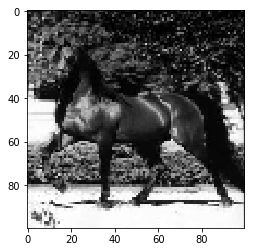

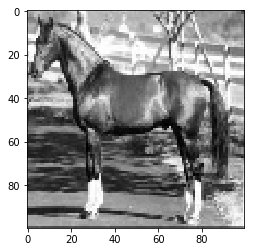

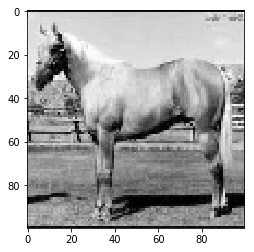

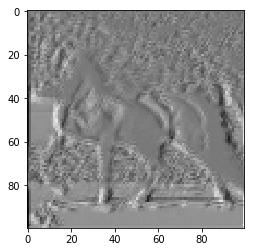

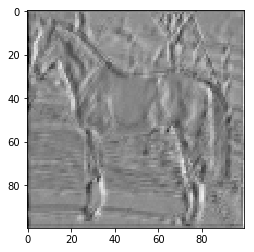

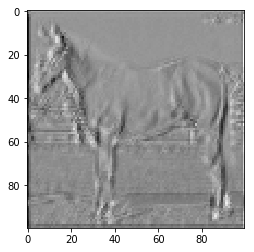

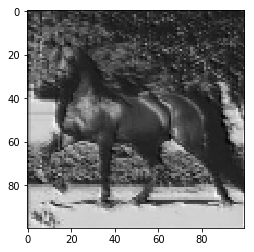

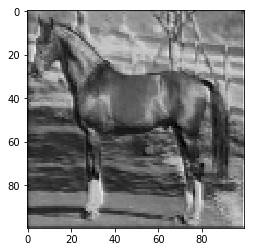

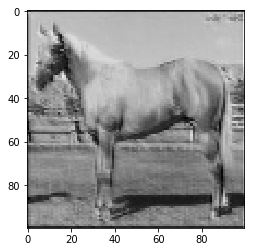

In [38]:
arr2 = generator.draw()
plot(np.expand_dims(arr2[:, 1], axis=1))
plot(np.expand_dims(arr2[:, 0], axis=1))
plot(np.expand_dims(np.sum(arr2, axis=1), axis=1))